In [1]:
import sys

In [2]:
sys.path.insert(0,'utils')
sys.path.insert(0,'../')

In [3]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse

In [4]:
from helper_code import *
from get_feature import *
from utils.models import *
import sys
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import datetime
import tensorflow as tf
from sklearn.impute import SimpleImputer
from tqdm import tqdm

In [5]:
root_dir = '/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir +'/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [6]:
data_folder =  training_data_dir

In [7]:
patient_files = find_patient_files(data_folder)
num_patient_files = len(patient_files)
num_patient_files

942

In [8]:
data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_data_folder =  '/home/ubuntu/data/hmd/murmur/train'
test_data_folder = '/home/ubuntu/data/hmd/murmur/test'

In [9]:
patient_files_trn = find_patient_files(train_data_folder)
patient_files_test = find_patient_files(test_data_folder)

num_patient_files = len(patient_files_trn)
num_patient_files

751

In [10]:
current_patient_data = load_patient_data(patient_files[1])
current_patient_data

'9979 4 4000\nAV 9979_AV.hea 9979_AV.wav 9979_AV.tsv\nPV 9979_PV.hea 9979_PV.wav 9979_PV.tsv\nTV 9979_TV.hea 9979_TV.wav 9979_TV.tsv\nMV 9979_MV.hea 9979_MV.wav 9979_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 103.0\n#Weight: 13.1\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: AV+MV+PV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Diamond\n#Systolic murmur grading: III/VI\n#Systolic murmur pitch: High\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [11]:
fnms = os.listdir(root_dir + '/training_data')

In [12]:
fnms_wav = [a for a in fnms if a.split('.')[1] == 'wav']
fname = root_dir + '/training_data/' + fnms_wav[1]
fname

'/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_MV.wav'

In [13]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt                 # Librery to load .mat files
import peakutils                                # Librery to help in peak detection
from scipy import special

In [49]:
recordings = load_recordings(data_folder, current_patient_data)
recordings

[array([1653, 3815, 3101, ...,  187,  348,   53], dtype=int16),
 array([32596, 28290,  8851, ...,  6449,  6299,  7167], dtype=int16),
 array([   244,  -3588, -22579, ...,   -207,   -205,   -204], dtype=int16),
 array([5039, 5952, 5754, ...,  344,  229,   87], dtype=int16)]

In [50]:
per_sec = 4000*4

In [52]:
n_samp

7

In [53]:
##----------------------------------------------------------------------------
# FUNCTIONS: "execfile"
##----------------------------------------------------------------------------
''' This Function creates a time-vector for any signal given the sampling frequency
    and the duration of a signal'''
def time_vector(sampling_frequency,duration): 
	number_samples= sampling_frequency*duration;
	result=np.arange(1,duration/number_samples,duration-duration/number_samples);

	return result

##----------------------------------------------------------------------------
''' Derivate of an input signal as y[n]= x[n+1]- x[n-1] 
'''
def derivate (x):
	lenght=np.shape(x)				# Get the length of the vector		
	lenght=lenght[0];				# Get the value of the length
	y=np.zeros(lenght);				# Initializate derivate vector
	for i in range(lenght-1):
			y[i]=x[i+1]-x[i];		
	return y

##----------------------------------------------------------------------------
'''To normalized any vector\0-dimentional array in [-1,1] range, by divided the 
   vector by the maximun value of itself, substracting the mean value to the vector
   & dividing each value of the vector by the maximun value of itself 
'''
def vec_nor(x):
	lenght=np.shape(x)				# Get the length of the vector		
	lenght=lenght[0];				# Get the value of the length
	xMax=max(x);					# Get the maximun value of the vector
	nVec=np.zeros(lenght);			        # Initializate derivate vector
	for n in range(lenght):
		nVec[n]=x[n]/xMax;			
	nVec=nVec-np.mean(nVec);
	nVec=np.divide(nVec,np.max(nVec));
	return nVec
##----------------------------------------------------------------------------
'''
  FpassBand is the function that develop a pass band filter of the signal 'x' through the
  discrete convolution of this 'x' first with the coeficients of a High Pass Filter 'hp' and then
  with the discrete convolution of this result with a Low Pass Filter 'lp'
'''
def FpassBand(X,hp,lp):
        llp=np.shape(lp)	  	        # Get the length of the lowpass vector		
        llp=llp[0];				# Get the value of the length
        lhp=np.shape(hp)			# Get the length of the highpass vector		
        lhp=lhp[0];				# Get the value of the length	

        x=np.convolve(X,lp);		        # Disrete convolution 
        x=x[round(llp/2):round(-1-(llp/2))];
        x=x-(np.mean(x));
        x=x/np.max(x);
	
        y=np.convolve(x,hp);			# Disrete onvolution
        y=y[round((lhp/2)):round(-1-(lhp/2))];
        y=y-np.mean(y);
        y=y/np.max(y);

        x=np.convolve(y,lp);		        # Disrete convolution 
        x=x[round((llp/2)):round(-1-(llp/2))];
        x=x-(np.mean(x));
        x=x/np.max(x);
	
        y=np.convolve(x,hp);			# Disrete onvolution
        y=y[round((lhp/2)):round(-1-(lhp/2))];
        y=y-np.mean(y);
        y=y/np.max(y);
        
        y=vec_nor(y);				# Vector Normalizing
        
        return y

In [206]:

def get_interval(datos, per_sec, min_dist) :
#    datos=sp.io.wavfile.read(fname)
    filtros=sio.loadmat('./Filters1')
    tmp_interval = []
    n_samp = len(datos[1])//per_sec


    for k in range(n_samp):
        X = datos[1][k*per_sec:(k+1)*per_sec]
        Fs= datos[0]
        Fpa20=filtros['Fpa20'];			        # High pass filter
        Fpa20=Fpa20[0];					# High pass filter
        Fpb100=filtros['Fpb100'];		        # Low-pass Filter
        Fpb100=Fpb100[0];				# Low-pass Filter
        Xf=FpassBand(X,Fpa20,Fpb100); 	                # Apply a passband filter
        Xf=vec_nor(Xf);			

    # Derivate of the Signal
        dX=derivate(Xf);				# Derivate of the signal
        dX=vec_nor(dX);					# Vector Normalizing
    # Square of the signal
        dy=np.square(Xf);
        dy=vec_nor(dy);

        size=np.shape(Xf)				# Rank or dimension of the array
        fil=size[0];					# Number of rows

        positive=np.zeros((1,fil+1));                   # Initializating Positives Values Vector 
        positive=positive[0];                           # Getting the Vector

        points=np.zeros((1,fil));                       # Initializating the all Peak Points Vector
        points=points[0];                               # Getting the point vector

        peaks=np.zeros((1,fil));                        # Initializating the s1-s1 Peak Vector
        peaks=peaks[0];                                 # Getting the point vector


        for i in range(0,fil):
            if dX[i]>0:
                positive[i]=1;
            else:
                positive[i]=0;

        for i in range(0,fil):
            if (positive[i]==1 and positive[i+1]==0):
                points[i]=Xf[i];
            else:
                points[i]=0;

        indexes=peakutils.indexes(points,thres=0.5/max(points), min_dist=min_dist);
        lenght=np.shape(indexes)			# Get the length of the index vector		
        lenght=lenght[0];				# Get the value of the index vector

        for i in range(0,lenght):
            p=indexes[i];
            peaks[p]=points[p];

        n=np.arange(0,fil);                            # Vector to the X axes (Number of Samples)
        indexes =indexes+(k*per_sec)    
        tmp_peaks = np.array(indexes)


        tmp_interval.extend(tmp_peaks)

    tmp_interval = np.array(tmp_interval)
    return tmp_interval

In [210]:
def check_ith(i, per_sec = 4000*1, min_dist = 300) :
    current_patient_data = load_patient_data(patient_files[i])
    #per_sec = 4000*1
    #min_dist=300
    print(current_patient_data)
    spp = current_patient_data.split("\n")
    data = {}
    for l in spp :
        if l.startswith('AV '):
            data['AV'] = l.split(" ")[2]
        if l.startswith('PV '):
            data['PV'] = l.split(" ")[2]
        if l.startswith('TV '):
            data['TV'] = l.split(" ")[2]
        if l.startswith('MV '):
            data['MV'] = l.split(" ")[2]

    for k,itm in data.items() :
        print(k,itm)
        fname = root_dir + '/training_data/' + itm
        datos=sp.io.wavfile.read(fname)
        interval1 = get_interval(datos, per_sec, min_dist)
        print(interval1)
        print(np.diff(tmp_interval))

        seq1 = np.array(datos[1])
        plt.figure(figsize=(16,8))
        plt.plot(datos[1])
        plt.plot(interval1, datos[1][interval1], marker="o", c='green', alpha=.8 )
        plt.xlim(0,30000)
        plt.ylim(-20000,20000)
        plt.show()

2530 4 4000
AV 2530_AV.hea 2530_AV.wav 2530_AV.tsv
PV 2530_PV.hea 2530_PV.wav 2530_PV.tsv
TV 2530_TV.hea 2530_TV.wav 2530_TV.tsv
MV 2530_MV.hea 2530_MV.wav 2530_MV.tsv
#Age: Child
#Sex: Female
#Height: 98.0
#Weight: 15.9
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 2530_AV.wav
[   48  1233  2120  3315  4399  5504  6044  6593  7737  8607  9699 10628
 11695 12765 13246 13869 14940 15795 16346 17446 18503 19484 20510 20839
 21731 22971 23986 24082 25341 26331 27172 27514 28614 29258 29839 30812
 31218 31904 32021 32914 34309 35315 36554 37658 38992 40112 41299 42174
 42583 43369 44253 45320 46

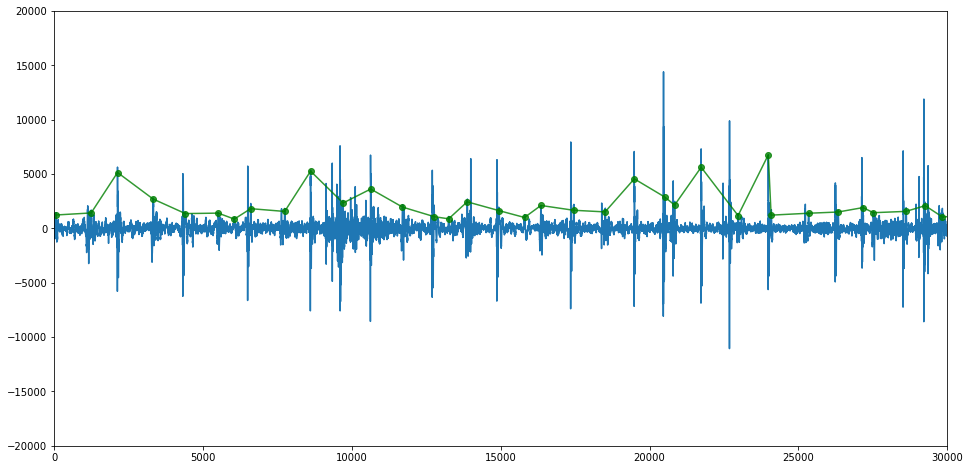

PV 2530_PV.wav
[   88   665  1348  2348  3639  4630  5817  6795  7747  8925 10082 11100
 12283 13300 14550 15559 16740 17218 17726 18061 18489 19744 20793 21848
 22180 22804 23797 24839 25827 26955 27933 30022 31211 32043 33068 35196
 36204 37900 38924 39530 40519 41536 42976 43982 44057 45345 46358 46688
 47677 51060 51983]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


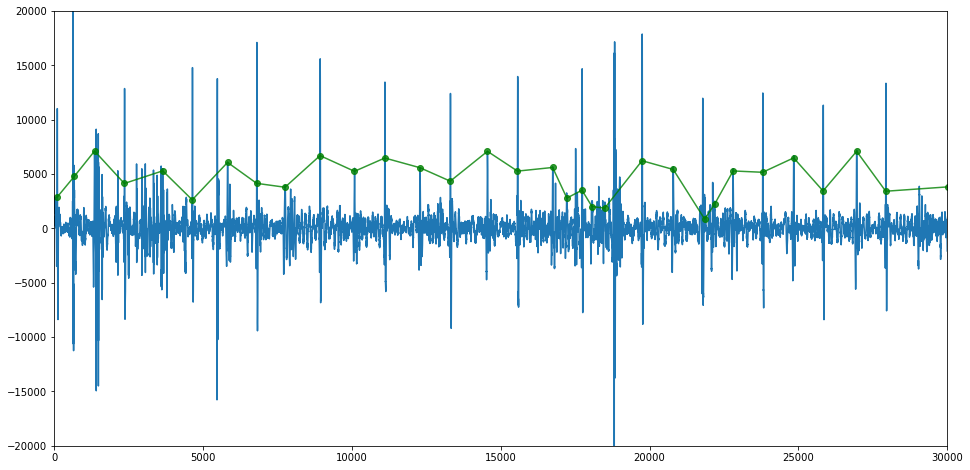

TV 2530_TV.wav
[   14  1019  2191  3054  4229  5189  6159  7166  8380  8876  9241 10388
 11362 11926 13437 14608 15434 16602 17451 18648 19522 20601 21598 22781
 23779 25131 25989 27229 27560 28079 28718 29285 30152 31330 32341 32654
 33686 34566 35074 35946 37088 38156 39016 40247 41115 42401 43294 44469
 44860 45485 46702 47706 49005 49866 51069 51929 52120 53105 54118 55482]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


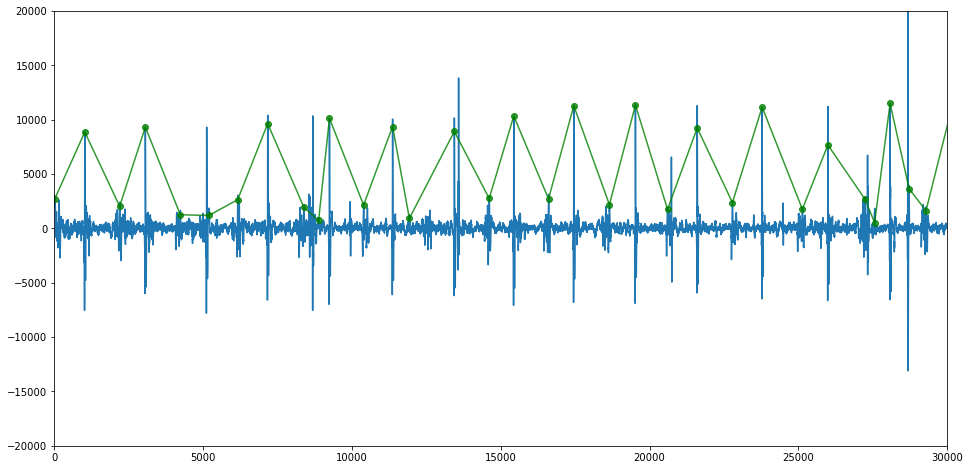

MV 2530_MV.wav
[   262   1008   1360   1719   2481   3061   3493   4071   4408   4738
   5216   6239   6875   7979   8014   9132   9676   9977  10782  11113
  12400  13447  14102  14463  14818  15166  16263  17596  18624  19011
  19775  20014  20367  20802  21388  21896  22518  22989  23580  23903
  24015  25096  26177  27243  28263  29246  29861  30245  31222  32306
  32860  33207  33803  34242  35310  35849  36368  37083  37447  38151
  38664  38993  39399  39738  40521  40961  41960  42730  43051  44041
  44622  45109  46126  47299  48386  49674  50305  50706  52125  53203
  54356  55350  56440  57431  58489  59560  60096  60585  61272  61664
  62198  62720  63479  63804  64323  64917  65931  66598  67073  68067
  69126  70106  71161  72221  72763  73241  74162  74680  75339  76394
  77530  78523  79628  80607  81648  82633  83703  84769  87627  88243
  89259  90520  91517  92784  93778  94985  97308  98021  98388  99830
 100074 100851 101479 102294 103279]
[1915 4032 1817  655  949

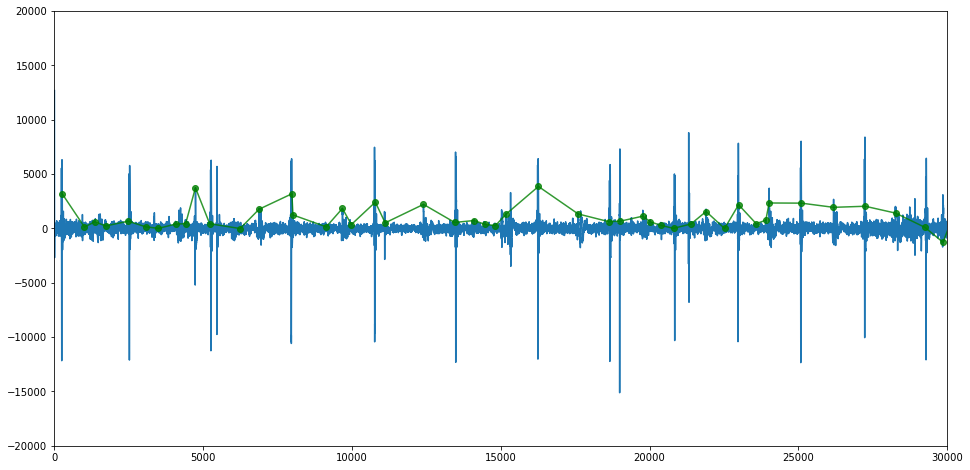

In [211]:
check_ith(0)

9979 4 4000
AV 9979_AV.hea 9979_AV.wav 9979_AV.tsv
PV 9979_PV.hea 9979_PV.wav 9979_PV.tsv
TV 9979_TV.hea 9979_TV.wav 9979_TV.tsv
MV 9979_MV.hea 9979_MV.wav 9979_MV.tsv
#Age: Child
#Sex: Female
#Height: 103.0
#Weight: 13.1
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Diamond
#Systolic murmur grading: III/VI
#Systolic murmur pitch: High
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 9979_AV.wav
[ 1463  2406  2712  4434  5039  5490  7235  7759  8010  8615  9987 10382
 11051 11694 12757 13370 14038 15539 15966 16603 17347 18283 18842 19265
 19646 20378 21043 21436 21773 22104 23735 24148 24773 25088 25845 26428
 26808 27312 27803 29065 29643 30101 30415 31701 32097 32744 33275 34344

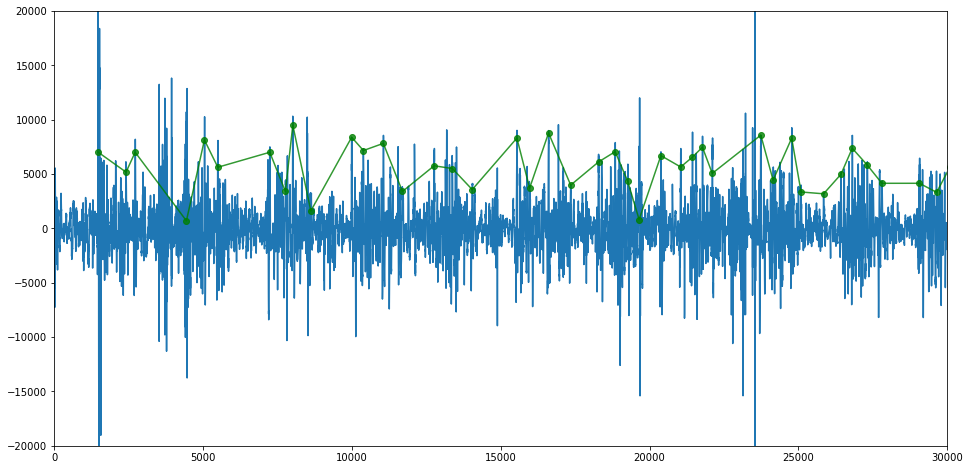

PV 9979_PV.wav
[    7  1062  3661  6336  8320  8918 11503 13348 14069 16108 16582 19156
 21619 23979 24184 26641 29154 31565 33038 33381 33697 34140 35305 35642
 35949 36593 39104 41019 41712 42947 44142 46592 47930 48085 48559 49046
 51516 53047 54034 56488 59069 60267 60817 61200 61633 63065 63436 63809
 64185 66680 69302 70674 71178 71794 73383 73879 74416 75930 76974 78743
 79477]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


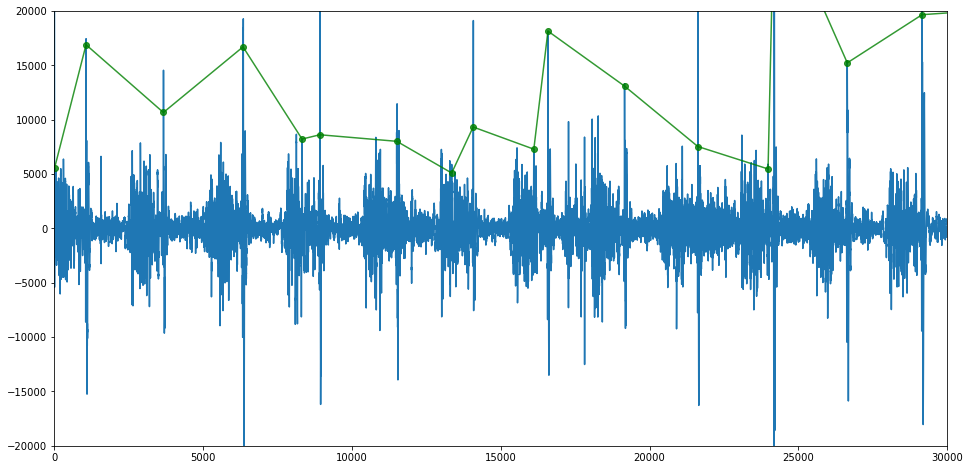

TV 9979_TV.wav
[   45   506  2535  5047  7511 10001 10856 12456 12922 13365 14913 15811
 16114 17387 18312 18704 19815 20443 22258 24678 27106 27859 29527 29984
 31930 34367 34811 35510 36777 37900 39143 39635 41525 42135 43926 44225
 44600 46318 47021 47424 48766 51263 53751 54671 56361 57531 58841 61379
 63920 66424 69077 70645 71576 74092 76622 77173 79133 81618 82600 84139
 86592]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


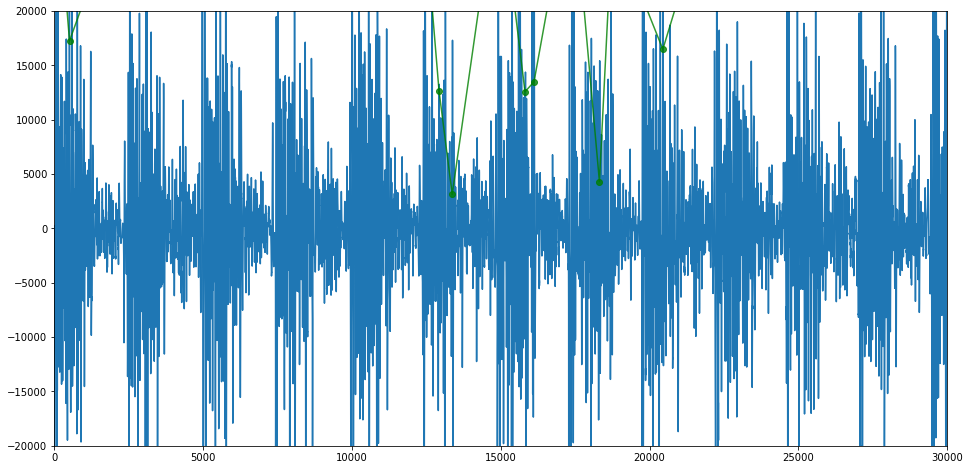

MV 9979_MV.wav
[    4   415  1526  3066  4222  5592  6704  8330  8831  9495 10937 11915
 12061 13626 14091 14772 16208 16593 16906 17347 18806 19306 19927 21482
 21992 22640 23881 24016 25141 26606 26959 27747 29137 30258 31683 32823
 34178 35284 36706 37843 39188 40289 41680 42303 42816 43969 44128 45232
 46445 47703 48879 49644 50142 51442 52550 53732 54996 56288 57397 58610
 59873 61168 62266 63634 64742 65942 67205 68512 69608 70983 71944 72108
 73388 74503 75830 76922 78284 78649 79411 80704 81806 82752 83144 83770]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


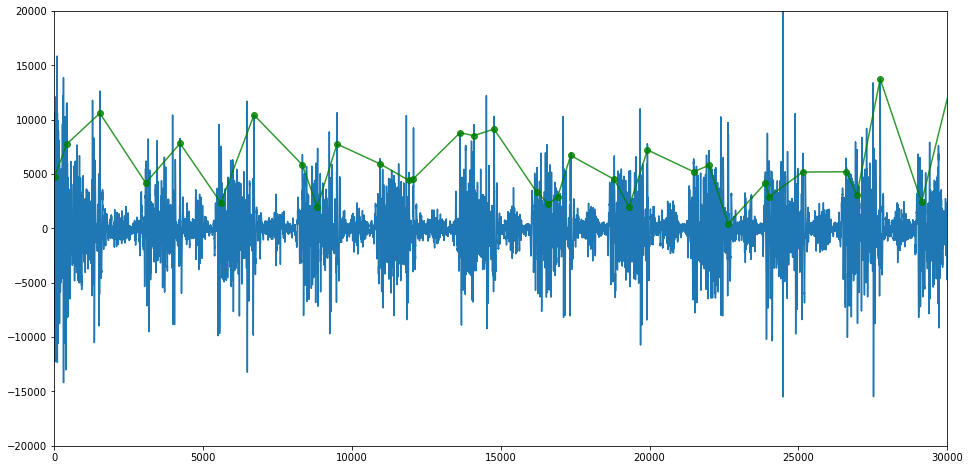

In [212]:
check_ith(1)

9983 4 4000
AV 9983_AV.hea 9983_AV.wav 9983_AV.tsv
PV 9983_PV.hea 9983_PV.wav 9983_PV.tsv
TV 9983_TV.hea 9983_TV.wav 9983_TV.tsv
MV 9983_MV.hea 9983_MV.wav 9983_MV.tsv
#Age: Child
#Sex: Male
#Height: 115.0
#Weight: 19.1
#Pregnancy status: False
#Murmur: Unknown
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 9983_AV.wav
[  662  1062  1497  2269  2729  3151  3486  4708  5477  6757  7434  8576
  9585 10891 11504 12029 12339 12968 13746 14436 15021 15451 15799 16007
 16560 16883 17194 17783 18400 19155 19508 19886 20044 20952 21454 21757
 22083 22718 23287 23667 23983 24479 25769 26632 27832 28685 29047 29939
 30830 31936 32148 32980 34

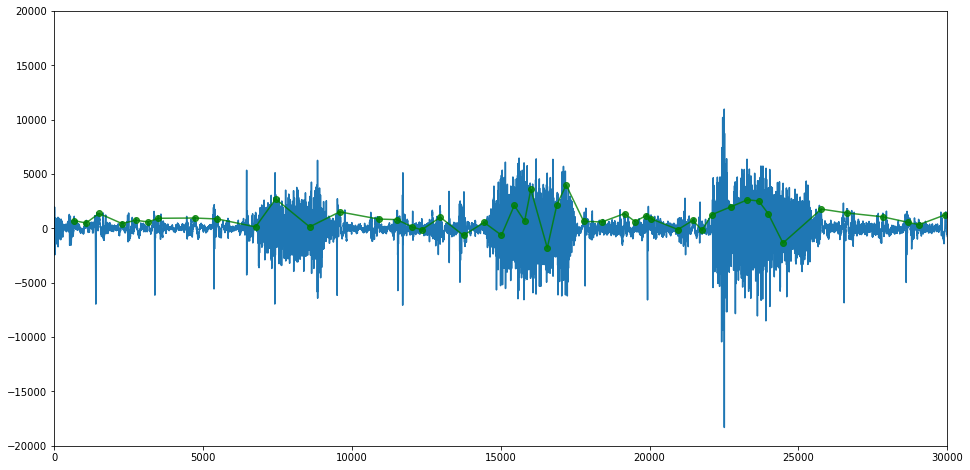

PV 9983_PV.wav
[   871   1811   3654   5464   6454   7270   7720   9087  10092  10919
  12762  14607  16447  18339  19585  20248  22168  24034  25915  27817
  28935  29734  30968  31369  32693  32994  33520  33859  34300  34637
  35360  37188  38260  39067  40318  40969  42845  44181  44689  46589
  48490  52253  54119  55185  55968  56010  57369  57876  59808  61747
  62388  62999  63675  64765  65075  65594  66639  67475  67796  69373
  71267  71588  72352  73168  75078  77768  78735  80055  80513  81004
  81326  81648  82168  83243  84087  84395  84947  85957  86892  87510
  87897  88696  89096  90035  92783  93816  94237  94538  94860  95354
  95774  96296  97797  98159  99190  99836 101501 103435 103821]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  4

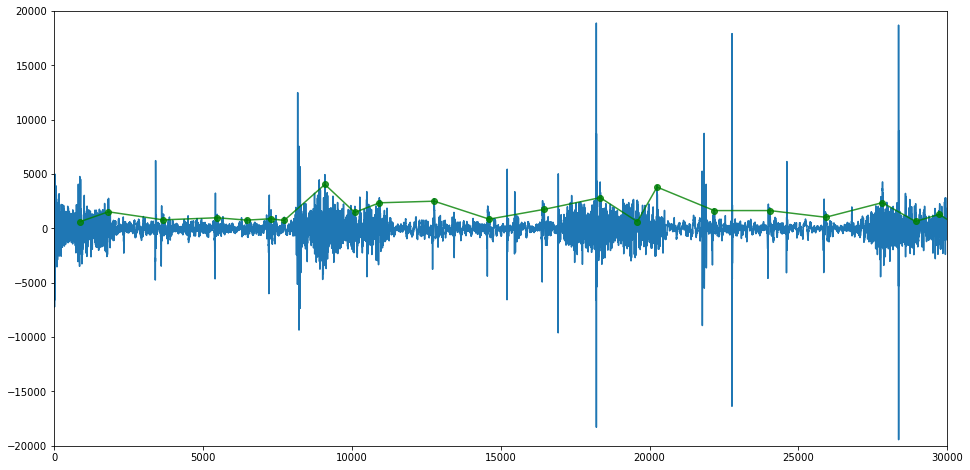

TV 9983_TV.wav
[   87   940  2025  2785  3884  4145  4641  5313  5652  6502  7497  7899
  8342  9323  9738 10388 11112 11956 12995 13746 14716 15559 16510 17351
 18280 19118 20147 21966 22721 23738 24163 24585 25653 25982 26483 27566
 28415 28904 29586 30435 30757 31621 32474 33691 34555 35672 36094 36528
 38460 39604 43371 44224 45251 46103 47209 47979 49049 49983 51039 51447
 51902 52123 53081 54170 55155 57276 58379 59496 61727 63884 64048 65008
 65944 66362 67061 67957 68123 68831 69984 70856 71898 72019 72386 72910
 73473 74026 74400]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


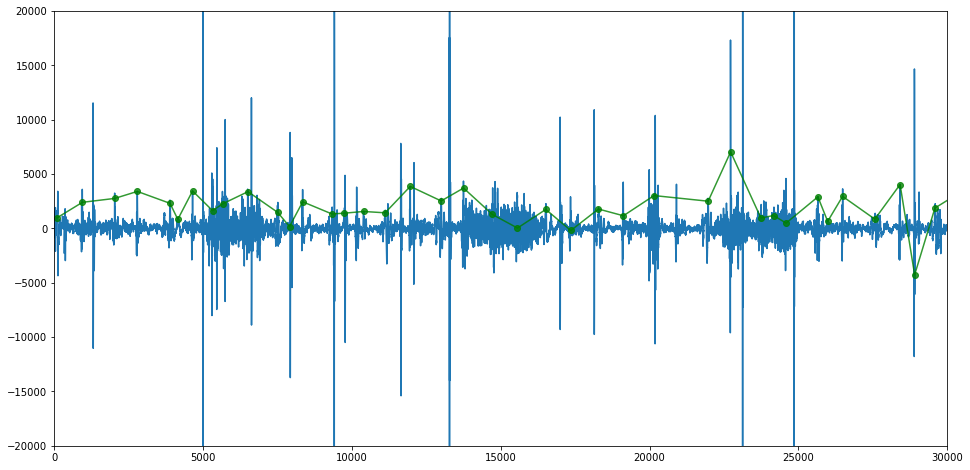

MV 9983_MV.wav
[   79   470  1087  1601  2129  2461  3248  3602  4358  4660  5249  8263
  8597  9136  9635 10368 10733 11322 11706 12553 13418 14126 15192 15569
 16194 16648 17032 17473 18122 18513 19081 19424 19744 20086 20629 20992
 21484 21831 22241 22549 23207 23933 24222 24594 25161 25522 26018 26673
 27111 27986 28178 28653 29084 29924 30579 31803 32643 35494 36577 36945
 37268 38340 39027 40750 42494 44251 44574 45174 45945 46851 47606 47909
 48844 49366 50565 51226 52961 54065 54660 55786 56354 56658 57558 57912
 58244 58620 59193 59694 60176 61741 62489 63492 64408 65246 65853 66288
 66987 68665 69392 70798 72357 72850 73482 74294 75210 75554 75856]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  42

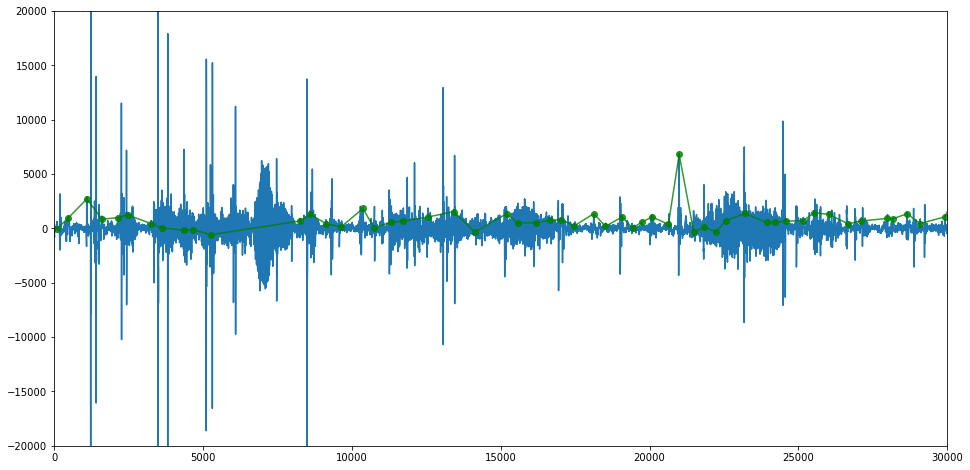

In [213]:
check_ith(2)

13918 4 4000
AV 13918_AV.hea 13918_AV.wav 13918_AV.tsv
PV 13918_PV.hea 13918_PV.wav 13918_PV.tsv
TV 13918_TV.hea 13918_TV.wav 13918_TV.tsv
MV 13918_MV.hea 13918_MV.wav 13918_MV.tsv
#Age: Child
#Sex: Male
#Height: 98.0
#Weight: 15.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 13918_AV.wav
[ 1259  2404  3555  5829  7297  8154  9601 10458 11601 12729 14078 15027
 16351 17345 19659 21934 24247 26564 28846 31117 31609 32148 33402 34730
 35710 37953]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 107

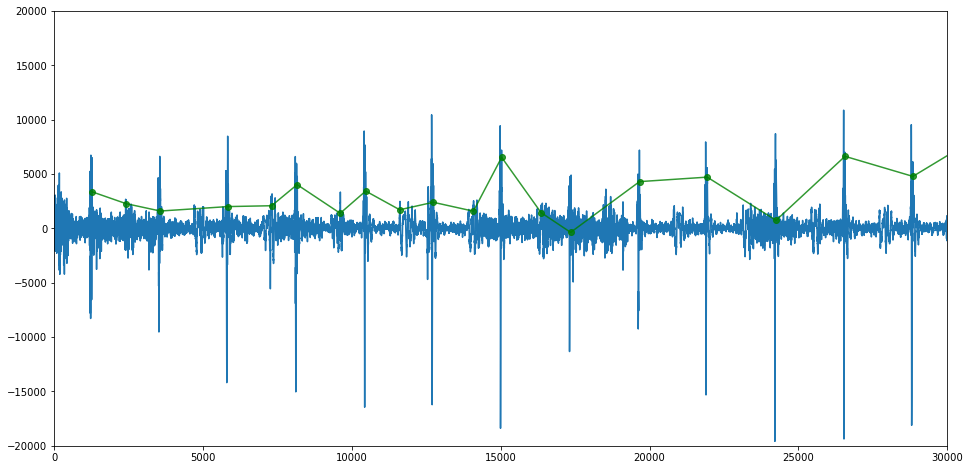

PV 13918_PV.wav
[ 1562  3828  6081  7496  8358 10643 12885 15152 16389 17428 18706 19665
 20974 21927 24203 26492 27793 28738 30068 31014 33304 35622]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


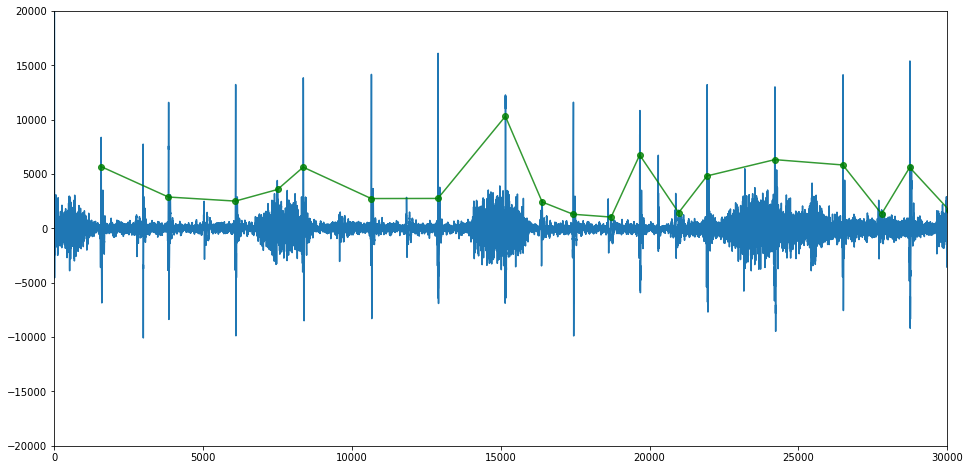

TV 13918_TV.wav
[  613  1660  2874  3905  6179  8432  9638 10669 11893 12928 15202 16401
 17449 18663 19695 20917 21961]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


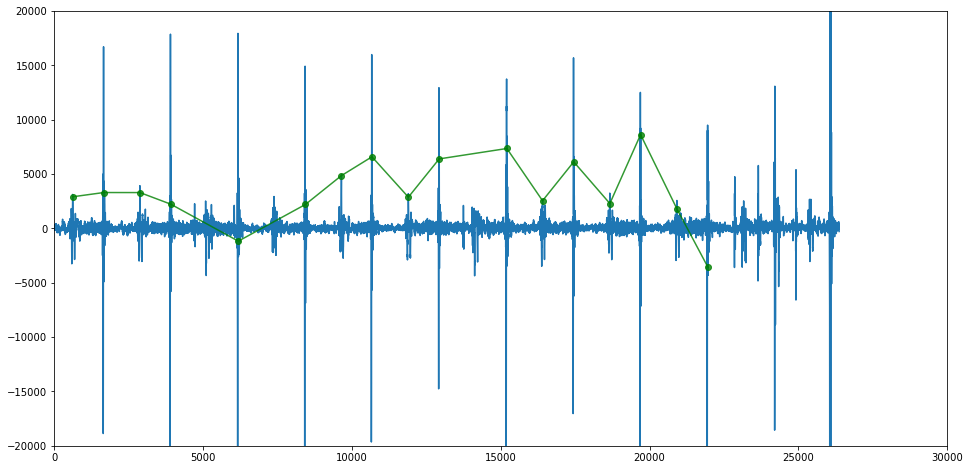

MV 13918_MV.wav
[   191   1458   2508   4821   5194   7106   9413  10666  11747  12968
  14028  15214  16754  20932  22278  22713  23240  24505  24827  25565
  26810  27878  29144  30182  32497  33758  34831  36054  37111  38390
  39444  40716  41786  42953  44082  45319  46020  46369  48679  50980
  52201  53255  55557  56720  57865  59078  60134  61380  62434  63683
  64750  67037  68268  69325  70516  71648  72876  73945  75183  76225
  77471  78516  79679  80826  81968  83089  84334  85371  86620  87666
  88831  89973  91206  92257  93433  94547  95806  96882  98110  99160
 100347 101465 102727 103794 106068 107323 108368 109620 110450 110891
 111396]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  

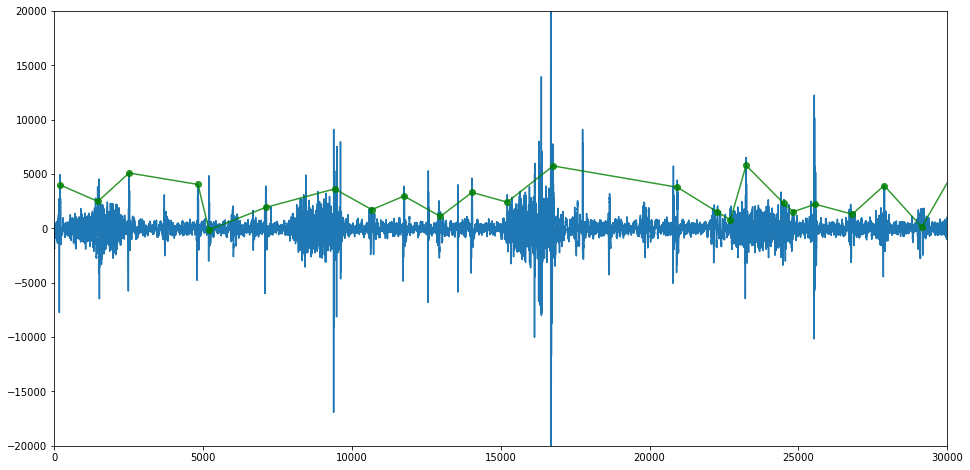

In [214]:
check_ith(3)

14241 4 4000
AV 14241_AV.hea 14241_AV.wav 14241_AV.tsv
PV 14241_PV.hea 14241_PV.wav 14241_PV.tsv
TV 14241_TV.hea 14241_TV.wav 14241_TV.tsv
MV 14241_MV.hea 14241_MV.wav 14241_MV.tsv
#Age: Child
#Sex: Male
#Height: 87.0
#Weight: 11.2
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: II/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 14241_AV.wav
[  446   932  1638  2504  6763  7309  8532  9067  9381 10238 10688 11646
 13078 14045 15539 16086 16459 17690 18336 18672 20008 20980 22360 23219
 24411 24862 25377 26528 27488 28553 29469 30478 31422 32509 33436 34516
 35359 36447 37311 38520 39471 40887 41854 43436 44307 45471 

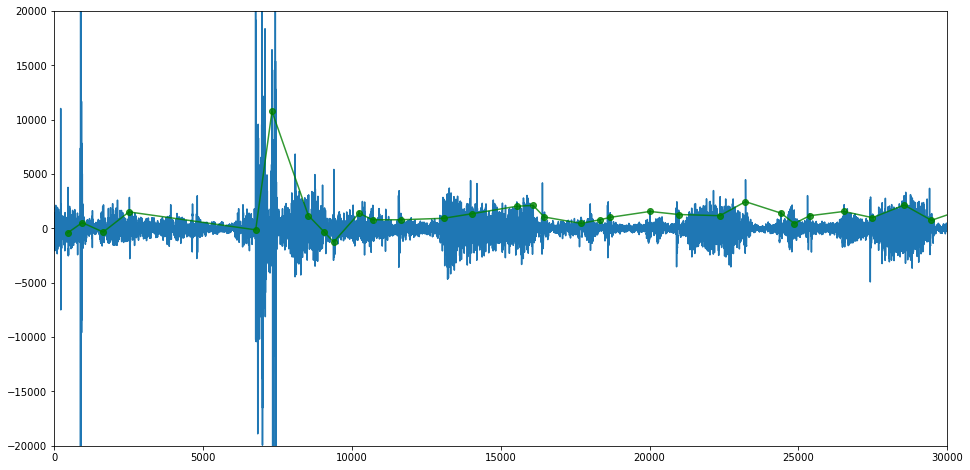

PV 14241_PV.wav
[  350  1758  2756  3966  4944  6201  6966  8060 10051 12038 13959 15827
 17683 19586 20533 21661 23497 25470 28498 30010 30874 32061 34371 36653
 37633 38945 39883 40090 40527 40869 41316 42400 43734 44731 46057 46942
 48277 50462 52936 55020 55960 56171 57174 58189 59468 60487 61826 62838
 64148 65030 66285 67304 68549 69561 71045 73158 75375 76466 77803 78825
 80244 82364 82904 83399 83971]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


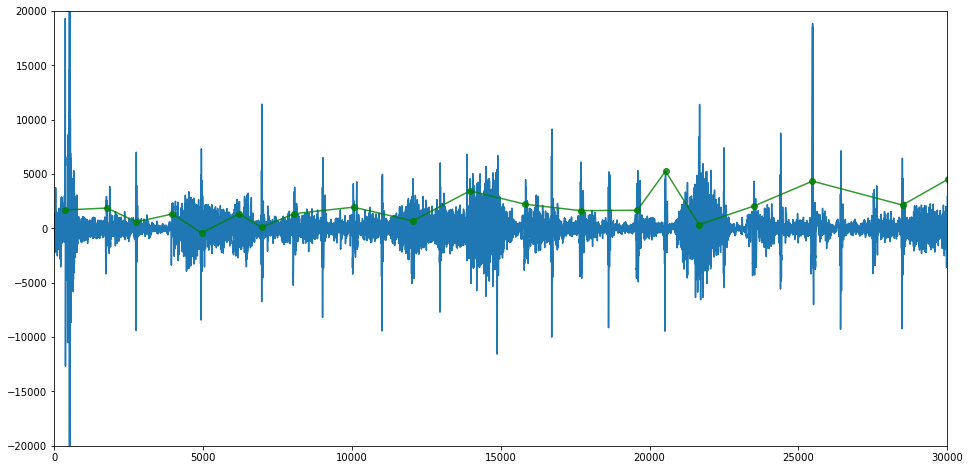

TV 14241_TV.wav
[   117   4300   5379   6580   7553   8804   9784  10933  11750  13075
  17436  18061  19569  20427  21769  22648  23894  24027  24454  24904
  25242  26362  27138  28612  29584  30296  30807  33231  34507  35744
  36164  36537  36924  37330  37941  38354  38829  39303  39958  40006
  40929  42279  43177  43592  44289  45274  46577  47466  48392  48738
  49622  50058  50781  51788  53157  53919  55011  55980  56096  57229
  58239  59653  61725  62621  63712  64800  65935  66936  68318  70753
  71152  71658  72802  73788  74304  75054  75361  75946  76801  77318
  78209  79520  80195  80498  81055  81698  82685  83896  84001  85019
  86292  87171  88376  89283  90548  92511  93363  94505  95332  95973
  96710  97444  98697  99451 100764 101647 103061 103956 105240 105989
 107105 108071 109521 110416 111483 111829 112608 114275 115050 116274
 116833 117192 118595 119502 120914 121803 122210 122965 123288 124056
 124680 125269 126223 127713]
[1915 4032 1817  655  949 1135 

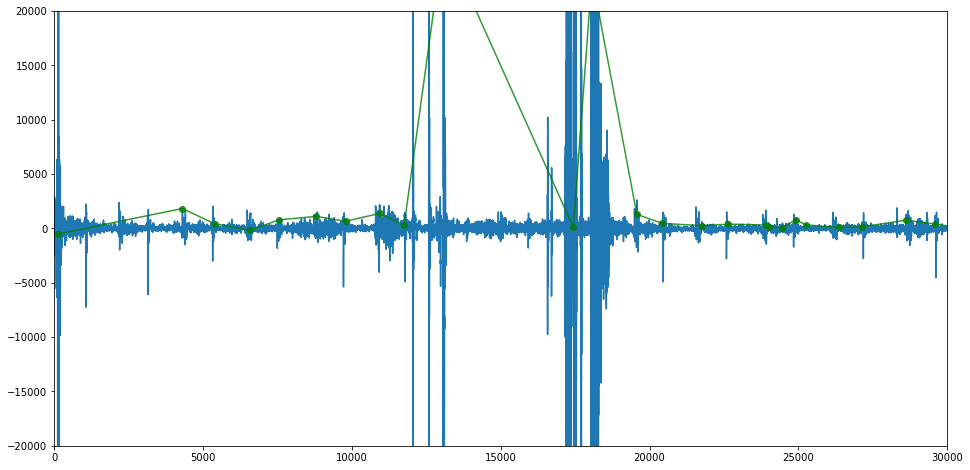

MV 14241_MV.wav
[    5  1920  5952  7769  8424  9373 10508 14215 16857 17864 18471 18988
 19713 21186 23217 25515 27437 28513 29752 30156 30732 31827 32276 32811
 33991 36175 37249 38530 39410 40489 41077 41538 42013 42357 42780 43272
 43604 45037 46282 49001 49543 49959 50470 51105 52102 53223 54298 55413
 56475 57459 58424 59513 63424 66357 67417 67800 68207 68570 68889 69280
 69658 69980 70552 70999 71600 72287 72709 73625 74828 75593 75987 77992
 79925]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


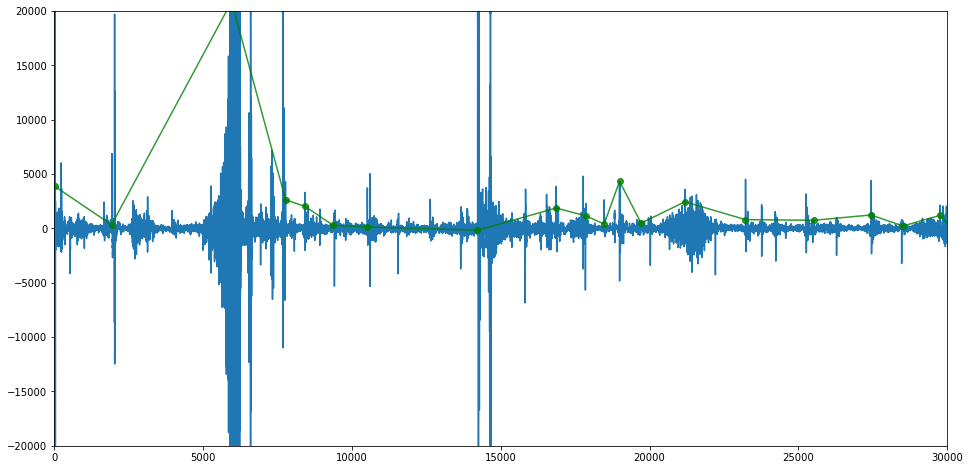

In [215]:
check_ith(4)

14998 4 4000
AV 14998_AV.hea 14998_AV.wav 14998_AV.tsv
PV 14998_PV.hea 14998_PV.wav 14998_PV.tsv
TV 14998_TV.hea 14998_TV.wav 14998_TV.tsv
MV 14998_MV.hea 14998_MV.wav 14998_MV.tsv
#Age: Child
#Sex: Male
#Height: nan
#Weight: nan
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 14998_AV.wav
[  196  4377  5230  5841  6450  8380 10646 11535 12673 13575 14709 15686
 16940 17870 19014 19934 21193 22024 23234 24159 25365 26255 27577 28131
 28525 28981 29327 29727 30245 30660 30964 31297 31930 32020 33006 34211
 35163 36401 37308 38606 39593 40757 41713 43091 44071 45394 46505 47663
 48513 49010 4977

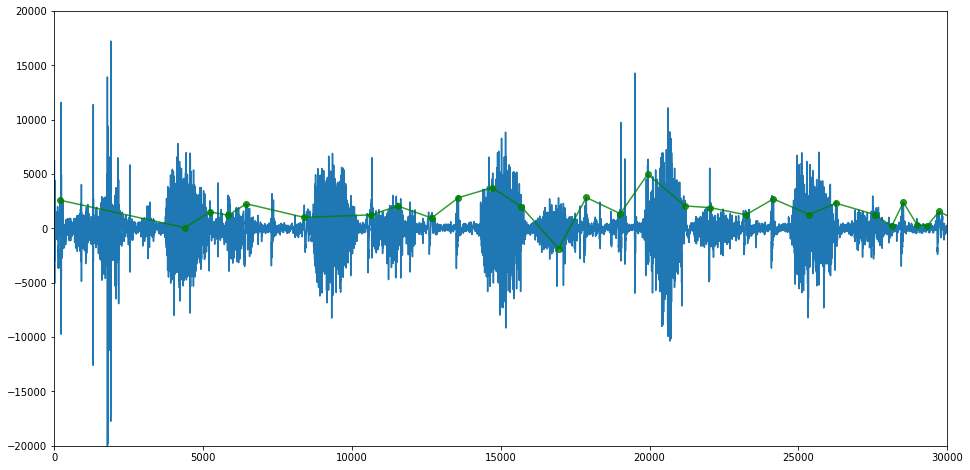

PV 14998_PV.wav
[  163  2331  3291  4509  5488  6703  7593  8933  9907 11115 12079 13327
 15521 16490 17730 18681 19984 20071 20958 22146 23113 24416 26581 27559
 28707 29653 30771 32790 34854 36848 38870 39805 40869 42841 43794 44862
 45803 46991 49035 49989 51099 53124 55158 56087 57189 58153 59200 61241
 63223 64158 65283 67278 69320 70245 71346 73364 74300 75472 76417 77469
 79542]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


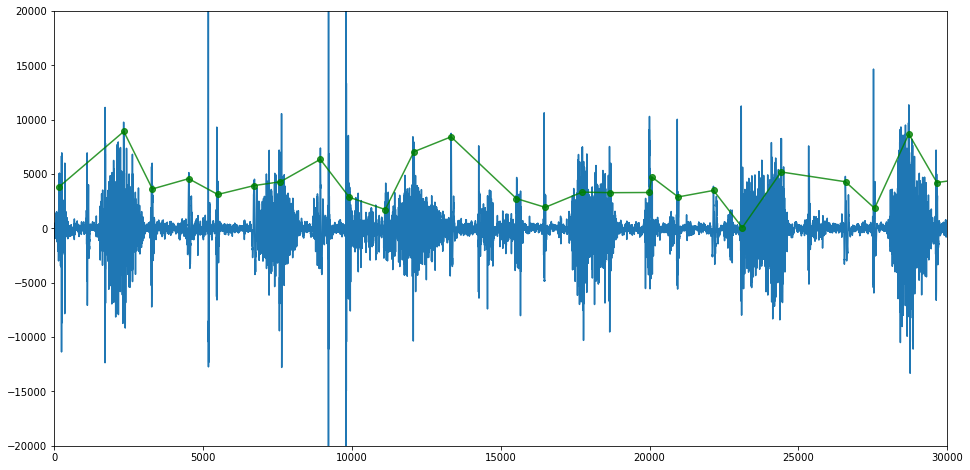

TV 14998_TV.wav
[  1245   3300   5333   7477   9588  11646  13710  15775  16698  17968
  18914  20028  22146  23079  24346  25297  26454  28619  29565  30875
  31835  33018  35211  36144  37358  39469  41584  43654  45726  47777
  49822  51853  53861  55894  56799  57927  59968  62163  64262  66353
  68525  70701  72820  74995  75936  77197  83691  84631  85825  90354
  92605  94849  97057  99255 101482 103636 105847]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


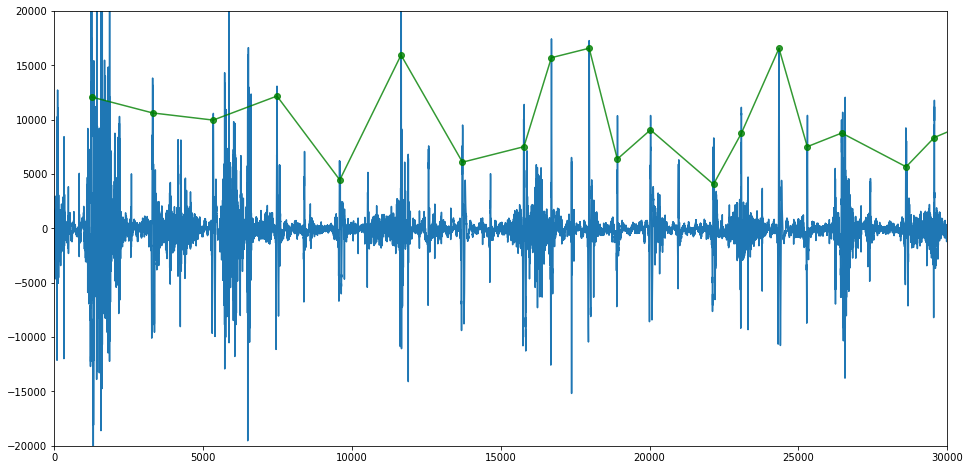

MV 14998_MV.wav
[  332   875  3013  5273  7533  9712 11843 13971 16043 18109 19110 20221
 22254 24320 26507 30775 32884 34975 37039 39038 41113 43289 44301 45425
 47610 48225 48614 49744 50762 51823 53949 54958 56023 57035 58082 59069
 60172 64348 68616 72950 77483 82066 84292 86548]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


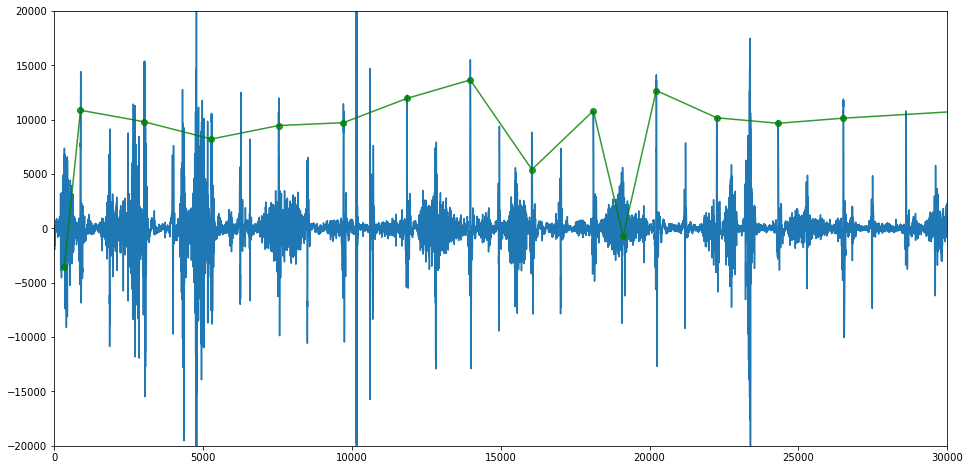

In [217]:
check_ith(5)

23625 4 4000
AV 23625_AV.hea 23625_AV.wav 23625_AV.tsv
PV 23625_PV.hea 23625_PV.wav 23625_PV.tsv
TV 23625_TV.hea 23625_TV.wav 23625_TV.tsv
MV 23625_MV.hea 23625_MV.wav 23625_MV.tsv
#Age: Child
#Sex: Female
#Height: 92.0
#Weight: 14.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 50379

AV 23625_AV.wav
[   57  1466  2189  4151  4745  5378  6153  6910  7348  8354  9547 10543
 11741 12732 13775 14768 15728 16730 17718 18717 19836 20089 20440 20748
 21541 22038 22601 23025 23674 24013 24978 26036 26862 27907 28750 29732
 30718 31910 32139 32890 34065 34910 35501 36123 36849 37862 38403 38846
 39939 4007

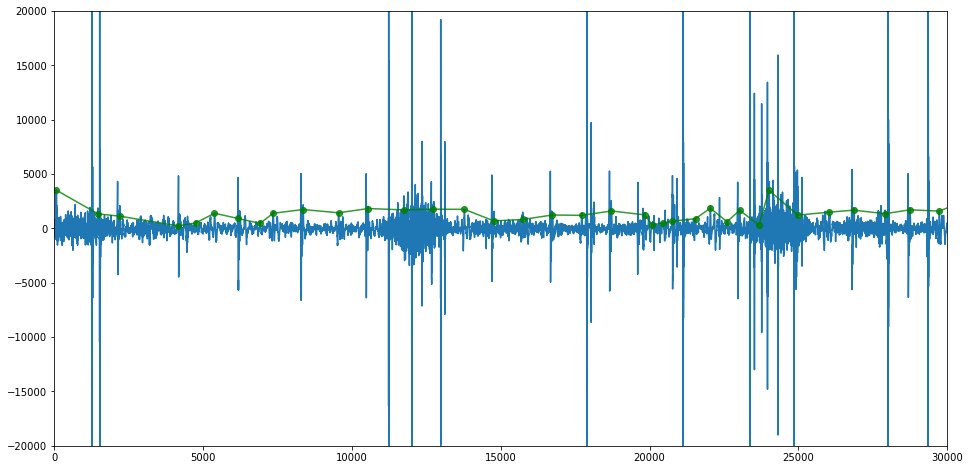

PV 23625_PV.wav
[   109    982   3089   4231   5087   6103   6486   7024   9014  10058
  11070  13041  14910  15959  16770  18630  20447  22253  23325  24122
  25990  27793  28088  29564  30574  31351  33143  34157  34938  35919
  39334  40150  41918  43678  44698  45497  46639  47447  48660  49471
  51544  53719  55879  58058  60214  61516  62353  63490  64475  66617
  68735  70837  72882  74841  76736  78656  80671  82711  84674  86529
  88390  90276  92177  94020  95850  97777  99763 101797 103819 104816
 105798 106574 107819 109926 112047 114096 115100 116080 118038]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


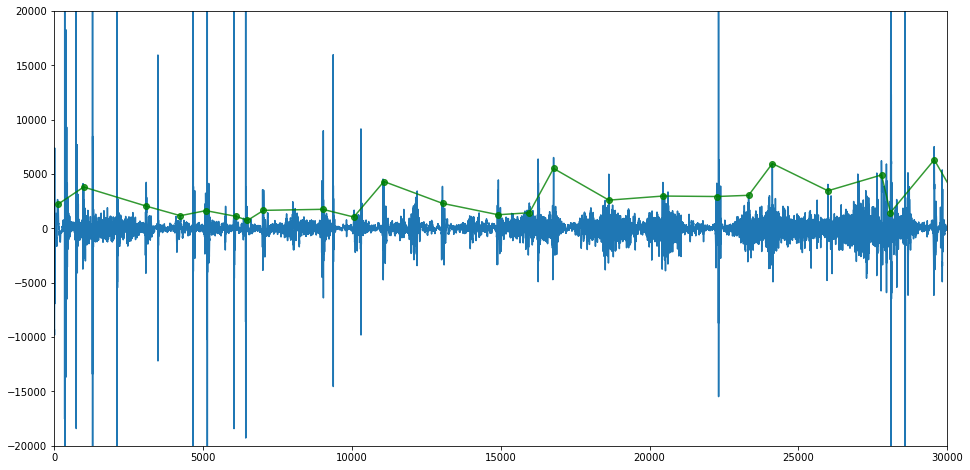

TV 23625_TV.wav
[  101   526   845  1187  1571  2069  2995  3650  3974  4207  5122  6337
  7197  8423  9226  9844 10414 11192 13256 14355 15269 16720 17266 18442
 19212 21250 22389 23292 24402 25322 26341 27256 28284 28604 29195 30326
 31244 31661 32397 33313 34482 35341 36357 37281 37651 37966 38273 39189
 39666 40284 40778 41195 42338 43250 45259 46247 47161 48234 48815 49151
 50356 51275 52477 53393 55451 56475 57393 58457 59372 60478 61389 62580
 63437 64609 65384 66385 67291 68320 69217 70272 71105 72073 72968 73912
 74803 75261 75818 76719 77828 78740 79678]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


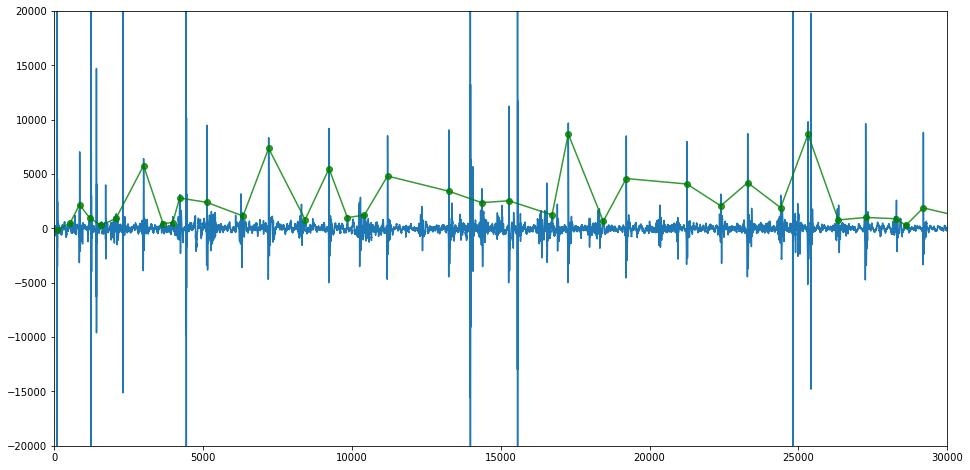

MV 23625_MV.wav
[ 2837  4123  4663  6080  8210  8534  9032 10125 10589 11021 11568 11920
 12206 12947 13327 13727 14040 14926 15521 15932 16090 16985 17748 18057
 19013 19319 19702 20086 21050 22056 23023 24116 25084 25452 26198 26663
 27161 27904 28299 29262 30363 31333 31797 32354 33318 34284 34587 35023
 35385 36221 36534 37026 37422 38125 38529 39427 40436 42400 43359 44581
 45401 45709 46511 47402 48491 49383 50390 51341 52272 54179 55079 55914
 56066 56951 58027 58934 60054 60947 62036 62937 63969 64372 64925 65510
 66001 66468 66903 67225 67660 68070 68952 70148 72131 73096 74160 75122
 75527 76236 77184 77697 78374 79262 80385 81285 81873 82312 83266]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  4

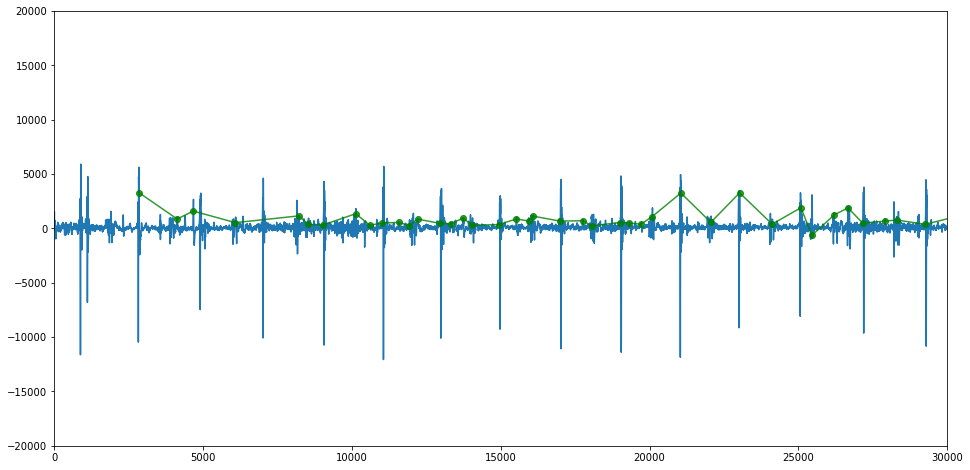

In [218]:
check_ith(6)

24160 4 4000
AV 24160_AV.hea 24160_AV.wav 24160_AV.tsv
PV 24160_PV.hea 24160_PV.wav 24160_PV.tsv
TV 24160_TV.hea 24160_TV.wav 24160_TV.tsv
MV 24160_MV.hea 24160_MV.wav 24160_MV.tsv
#Age: Child
#Sex: Female
#Height: 98.0
#Weight: 17.66
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 24160_AV.wav
[  645  2424  2953  3730  4406  4768  5229  5874  6444  7374  7816  8344
  9199 10324 11276 11928 12429 12741 13364 13708 14459 15507 15890 16505
 17556 18596 19571 20764 21171 21716 22898 23855 24866 25837 26757 27730
 28932 29879 30936 31903 32879 33847 34311 34983 35432 35934 36072 36990
 37889 38460

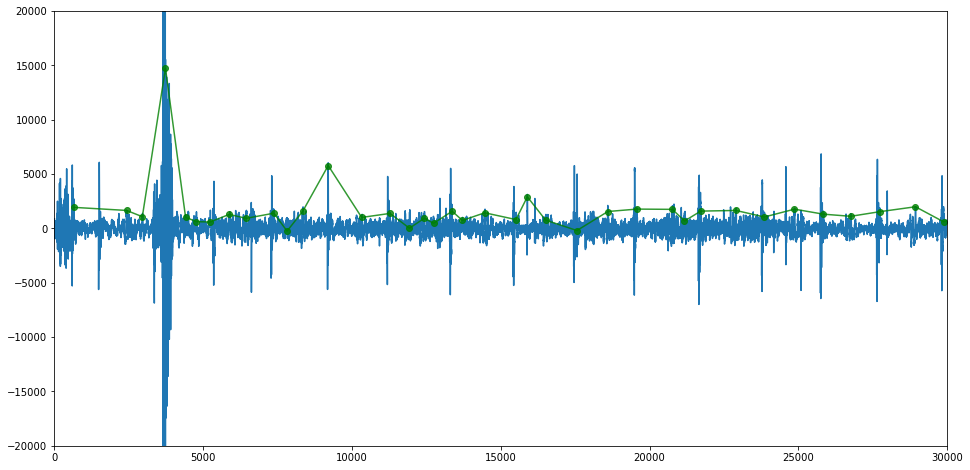

PV 24160_PV.wav
[  919  2920  4894  6140  6511  6915  7850  8815  9722 10700 11672 12660
 13577 14535 15414 16368 17249 18198 19055 20010 20343 20941 21880 22426
 22977 23621 23928 24016 25127 26094 27776 28192 29333 30300 32300 33322
 34315 34657 35347 36306 37275 38231 40177 41285 42255]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


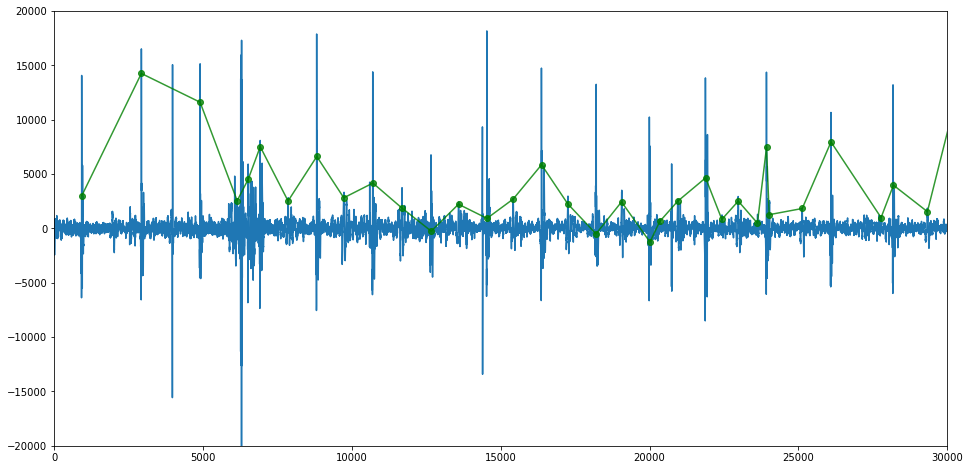

TV 24160_TV.wav
[   22  3290  4263  4871  5195  6162  7081  8055  9151 10120 11070 12032
 12955 13920 14877 17075 18057 19191 20175 21142 22126 23101 24123 25171
 26144 27144 28120 29081 30055 30831 31133 32107 33144 34196 35067 36035
 37047 38022 39094 40072 42107 43102 44075 44990 45956 46892 47870 48881
 49899 50837 51809 52704 53656 54573 55523]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


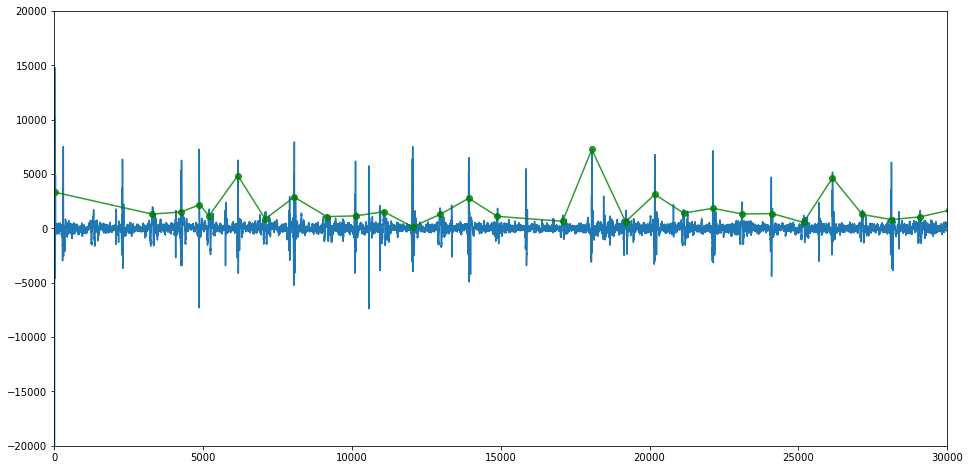

MV 24160_MV.wav
[  408  1815  4390  4804  5783  6275  6883  7691  8686  9548 10647 11551
 12550 13457 13831 14542 15014 15336 16320 17207 18253 19196 19699 20255
 21085 21399 22283 23107 23433 23762 24100 24932 25261 26032 27035 27638
 28141 29004 30006 30873 31914 32743 34685 36629 37609 38617 39002 39600
 40495 40896 41483 42322 44332 45329 46237 46619 47328 47983 48097 49184
 49836 50960 51955 52956 53803 54784 55614 56591 57449 58488 59441 60437
 61295 62379 63176 64158 65024 66111 66998 68055 69122 70131 71121 72233
 72624 73056 73438 74052 74492 74955 75318 75954 76004 76865 77216 77963
 78948 79958 80891 81890 82792 83886 84707 85803 86789 87797]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  91

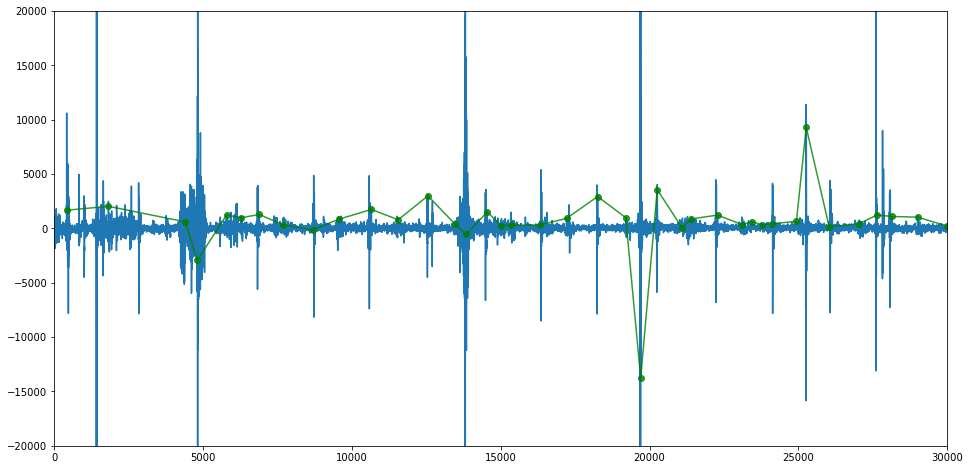

In [219]:
check_ith(7)

29045 4 4000
AV 29045_AV.hea 29045_AV.wav 29045_AV.tsv
PV 29045_PV.hea 29045_PV.wav 29045_PV.tsv
TV 29045_TV.hea 29045_TV.wav 29045_TV.tsv
MV 29045_MV.hea 29045_MV.wav 29045_MV.tsv
#Age: Child
#Sex: Female
#Height: 88.0
#Weight: 12.5
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: II/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 29045_AV.wav
[  674   981  1916  2987  3883  4355  4946  7684  8695  9981 10568 11507
 12513 14467 16404 17289 18304 18825 20263 21216 22274 23485 24255 25136
 25790 26170 27166 27952 28146 28545 29001 29972 31907 32013 33796 34689
 35459 36571 37507 38968 39411 41381 43320 44218 45213 4612

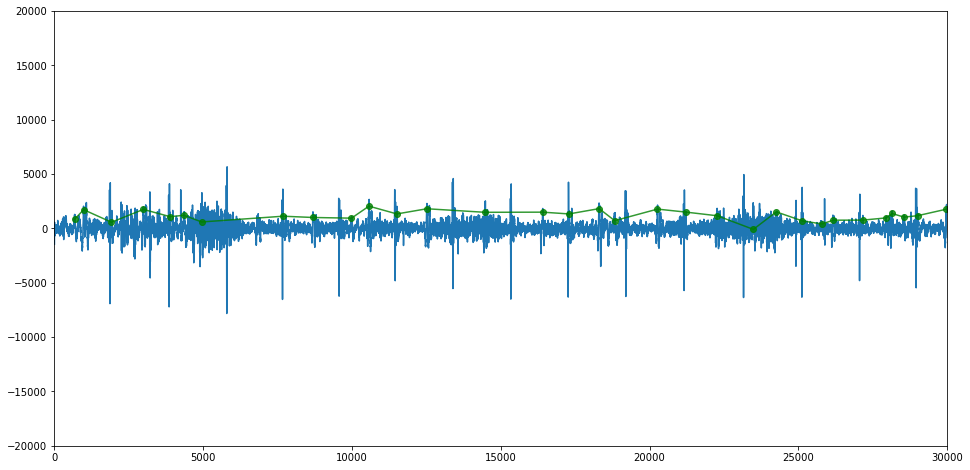

PV 29045_PV.wav
[  651  1640  2572  3679  4516  5671  6490  7519  8411  9425 10339 11332
 12266 13375 14208 15361 16188 17218 18121 19109 20029 20978 21915 22872
 23814 24853 26855 27797 28939 29778 30804 31729 32746 33690 34736 35683
 36767 37697 38836 39664 40760 41603 42590 43529 44511 45459 46474 47408
 48541 49390 50405 51341 52346 53297 55278 56407 57242 58272 59193 60212
 61151 62219 63147 64291 65218 66389 67228 68260 69184 70176 71115 72108
 73055 74170 75008 76086 76923 77969 78818 79764 80703 81653 82602 83585]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


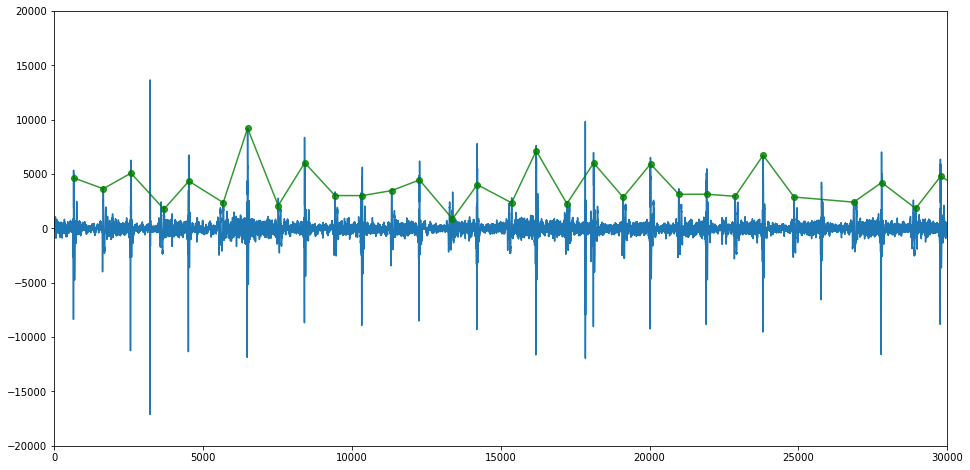

TV 29045_TV.wav
[  735  1823  2341  2658  4608  6548  8459  9517 10354 12247 13321 14149
 15222 16028 17875 18896 19725 20726 21555 22551 23370 24360 25167 26252
 27061 29030 30979 32889 34777 36687 37826 38653 39719 40611 42538 44493
 45639 46460 47666 48489 49663 50498 51510 52397 53459 54302 55349 56202
 57264 58115 59199 60050 61198 62046 63229 64068 66018 67916 69801 70862
 71731 72902 73746 74984 75828 77813 79743 80823 81682 82845 83712 84871
 85735 86913 87768]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


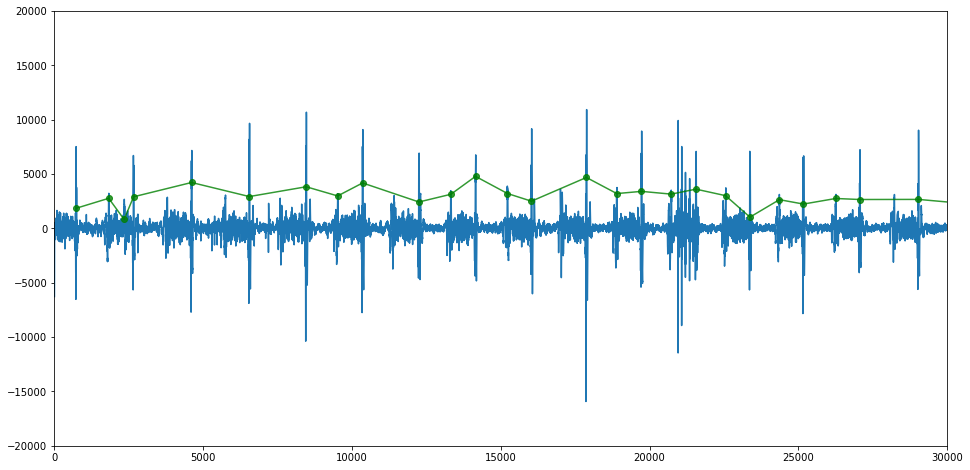

MV 29045_MV.wav
[  341  1114  1553  2056  4216  4567  5227  7225  8165  9072  9447 10065
 11057 11924 12076 12929 13776 14804 15266 15674 16706 19492 20420 21328
 22350 23173 24200 24635 25063 26100 26527 26992 27486 27879 28024 28926
 29925 30817 31830 32684 33707 34563 36501 37530 38448 38995 39456 40341
 41351 42212 44145 44684 45177 45602 46311 46661 47163 47762 48106 49027
 50000 51013 52925 53800 54467 54902 55644 56022 56645 57661 58581 59564
 59872 60577 61516 61937 62538 63497 64739 65115 65510 66542 67491 67918
 68413 69409 70337 71292 72306 73188 74232 75138 76178 77242 78075 78993
 79917]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


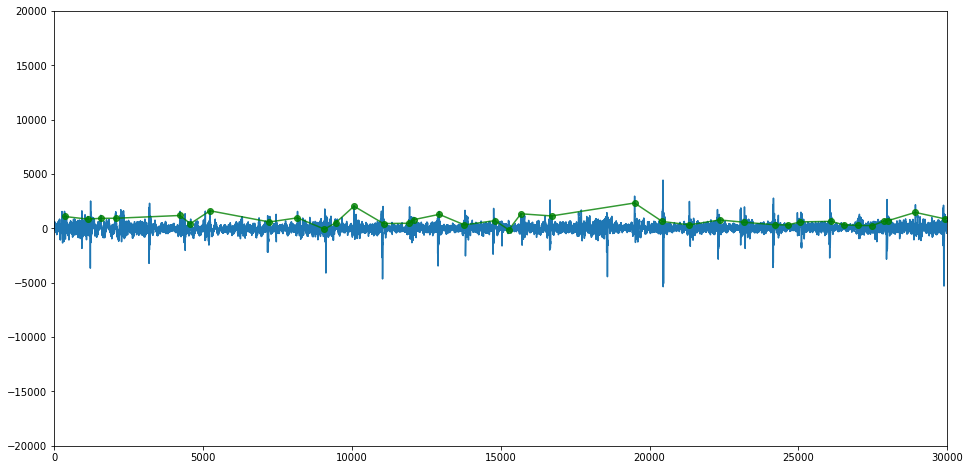

In [220]:
check_ith(8)

29378 2 4000
AV 29378_AV.hea 29378_AV.wav 29378_AV.tsv
MV 29378_MV.hea 29378_MV.wav 29378_MV.tsv
#Age: Child
#Sex: Female
#Height: 82.0
#Weight: 10.7
#Pregnancy status: False
#Murmur: Unknown
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 29378_AV.wav
[   40  1514  2099  3939  4756  5178  6695  8170  9656 11165 12670 14193
 15677 17184 18695 20230 21741 23275 24812 26379 27944 29495 31051 32603
 34158 35703 37260 38819 40377 41946 43527]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719 

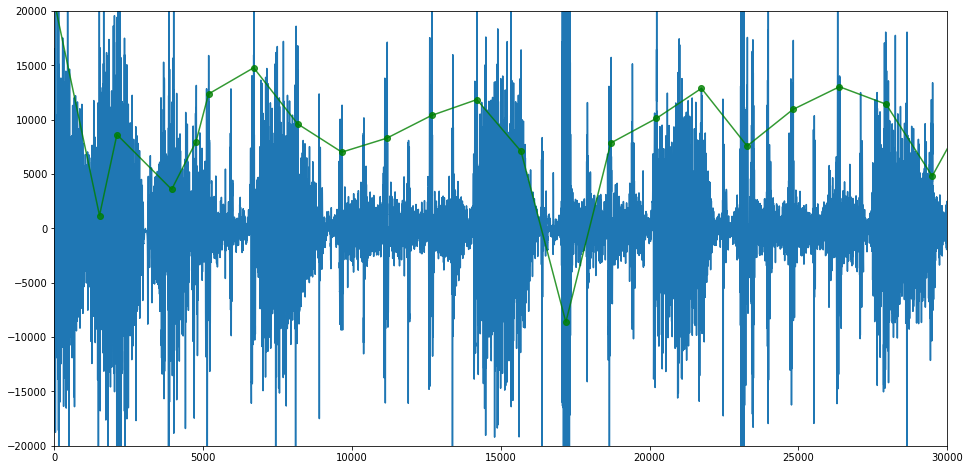

MV 29378_MV.wav
[  496  1285  2221  2859  3442  3849  4127  4483  5287  6080  6962  7660
  8481  9444 10196 11002 11737 13325 14139 14894 15685 16442 17221 17968
 18766 19503 20310 21035 21814 22526 23354 24207 26355 26753 27082 27866
 28655 29406 30121 30900 32470 33072 34526 35985 37468 38276 38966 39744
 40461 41203 41947 43412 44155 44923 46414 47128 48052 48735 49587 49954
 50312 51673 53267 53642 55613 56686 57154 57956 58778 59573 60295 61095
 61837 62600 63342 64089 64832 65568 66308 66997 67772]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


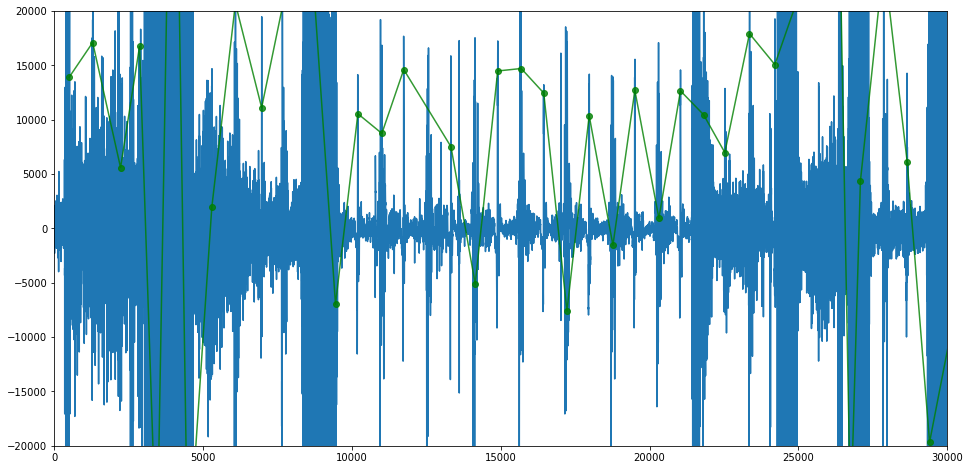

In [221]:
check_ith(9)

31737 4 4000
AV 31737_AV.hea 31737_AV.wav 31737_AV.tsv
PV 31737_PV.hea 31737_PV.wav 31737_PV.tsv
TV 31737_TV.hea 31737_TV.wav 31737_TV.tsv
MV 31737_MV.hea 31737_MV.wav 31737_MV.tsv
#Age: Child
#Sex: Female
#Height: 90.0
#Weight: 14.4
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 31737_AV.wav
[   72   609  1262  2162  3341  4223  5455  6347  7591  8466  9124 10619
 11831 12712 13937 14812 15940 16904 18097 18946 19968 20910 22029 22867
 23842 24866 26809 28821 29246 30823 31757]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  53

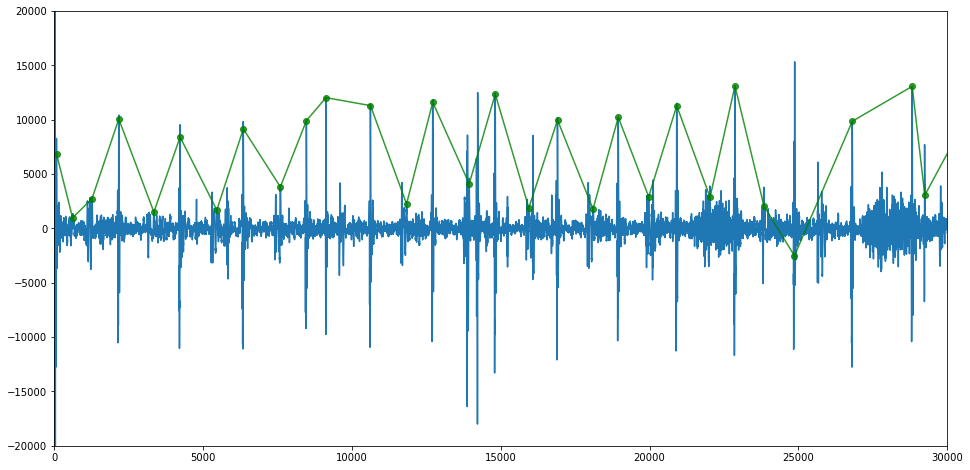

PV 31737_PV.wav
[   83  1071  2070  3302  4144  5251  6241  7241  8353 10446 11511 12638
 14562 16613 17778 18850 20761 22829 25099 27093 29305 31419 33435 35663
 37615 39817 41905 43797 44748 45837 46902 47900 48021 49892 51894 52921
 54044 55867]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


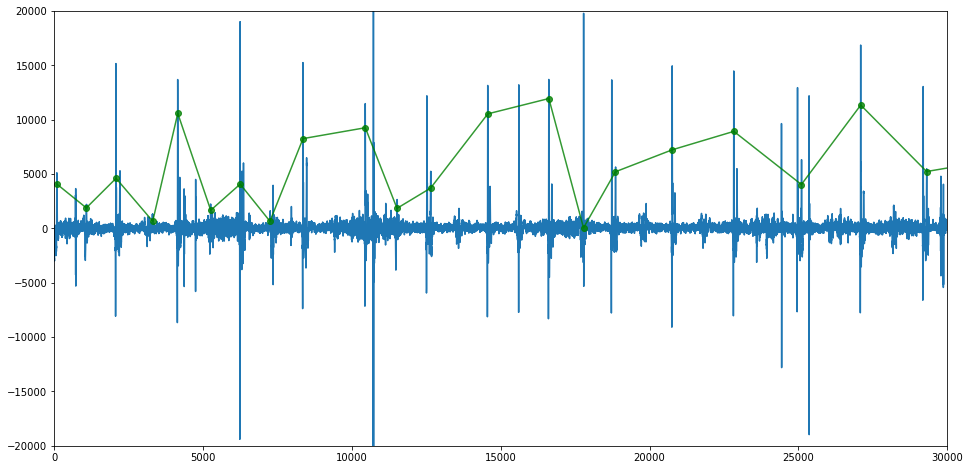

TV 31737_TV.wav
[  213  1300  2312  4403  4989  5507  6526  7417  7757  8578  9607 10583
 11566 12567 13506 14493 15417 16403 18381 20338 21257 22256 23224 24217
 26194 28182 30228 32252 33221 33537 34262 35146 36288 36596 37232 38250
 39216 39524 40223 41239 42246 43188 44171 45144 46077 47031 49941 50969
 51969]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


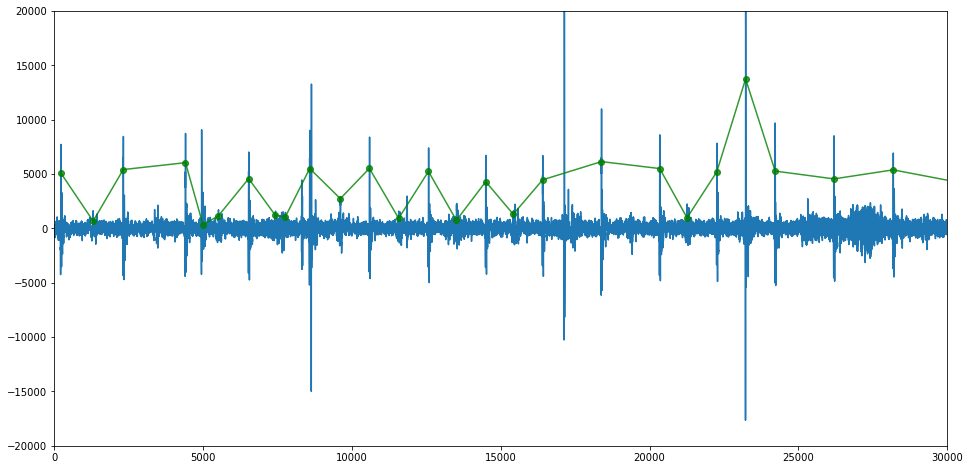

MV 31737_MV.wav
[   32  1146  2251  2607  3218  4024  4412  5099  5513  5980  6324  6794
  7248  8351  8724  9351 10527 11349 11658 12458 13413 13718 14531 15767
 16692 17803 18752 19399 19903 20202 20566 21131 21476 21986 22313 22858
 23189 23555 23966 24080 24737 25273 26074 27305 27954 28061 28363 29233
 30085 31271 35551 36094 36877 37473 38033 39922 40078 41079 41851 42170
 43025 43477 43799 44109 44996 45369 45822 46752 47583 48662 49563 49864
 50741 51535 52728 53327 53727 54520 55358 55660]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


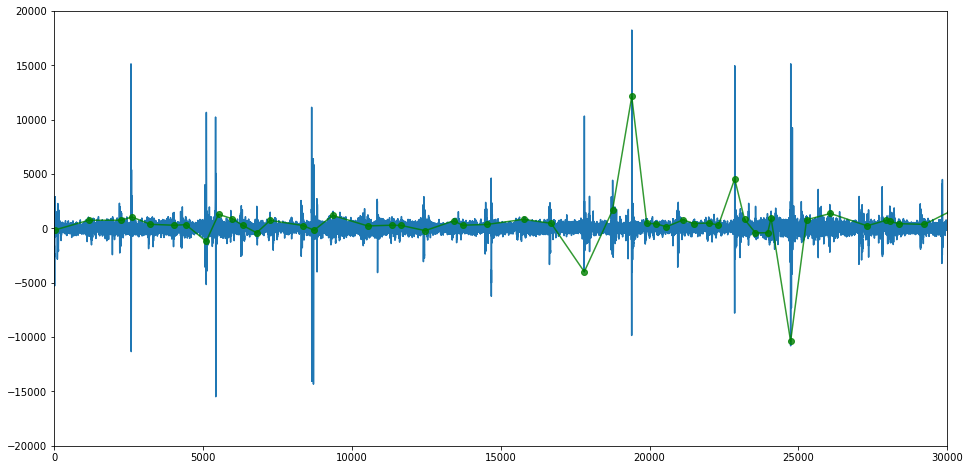

In [222]:
check_ith(10)

33151 4 4000
AV 33151_AV.hea 33151_AV.wav 33151_AV.tsv
PV 33151_PV.hea 33151_PV.wav 33151_PV.tsv
TV 33151_TV.hea 33151_TV.wav 33151_TV.tsv
MV 33151_MV.hea 33151_MV.wav 33151_MV.tsv
#Age: Child
#Sex: Female
#Height: 141.0
#Weight: 30.9
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 33151_AV.wav
[  716  2599  3822  5730  6327  6873  7250  7622  8075  8780  9912 11766
 12383 12993 14891 15981 16123 17907 19028 20755 21904 23879 24853 27512
 27982 29860 30891 32565 33704 35531 36592 38410 39187 39558 40106 41500
 42405 42714 43163 43520]
[1915 4032 1817  655  949 1135 3707 2642 

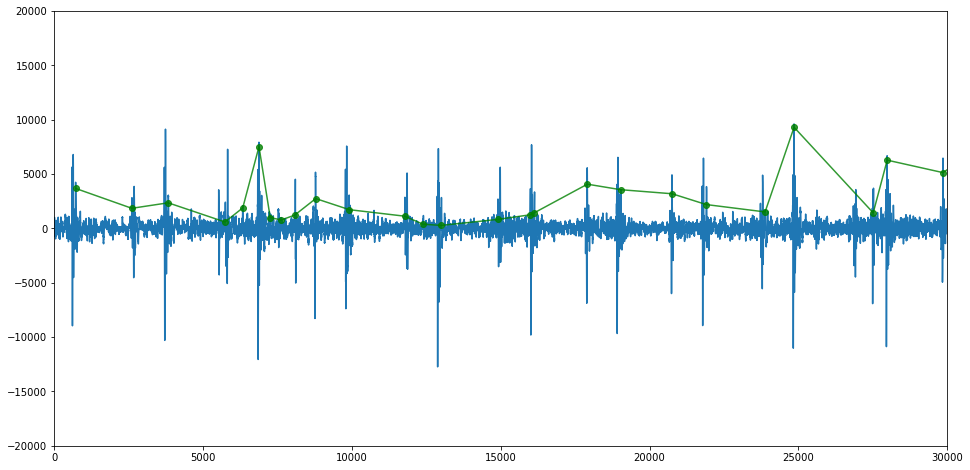

PV 33151_PV.wav
[ 2808  5843  8675 11774 14884 17723 19424 20481 23411 26415 29309 31319
 32388 35551 37487 38522 40212 41263 42972 44041 45885 46955 49944 52660
 54322 55386 57221 58298 61142 63622 65040 66086 67667 68713 71457 74024
 75608]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


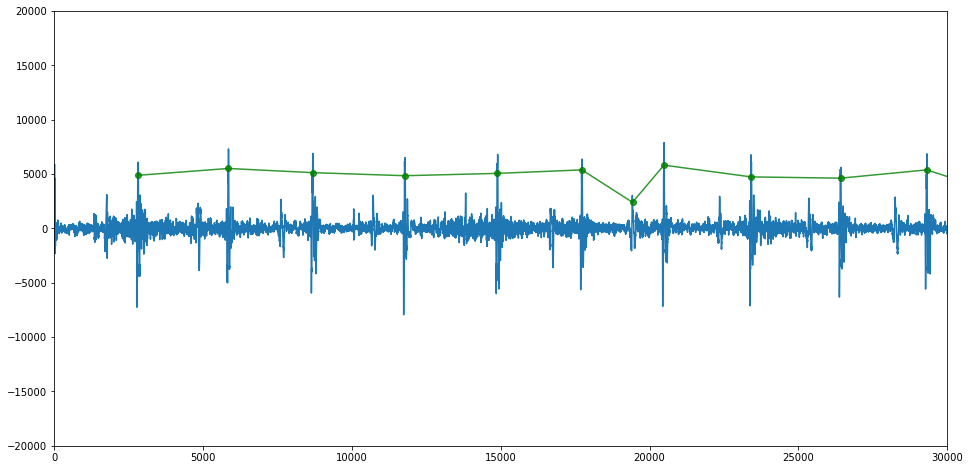

TV 33151_TV.wav
[ 2802  5660  8522 11439 14165 17008 19977 23076 26015 28984 32045 34960
 37831 38949 40796 43550 46315 49296 52459 53581 55586 58396 61159 63908
 66580 67584 69100 71784]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


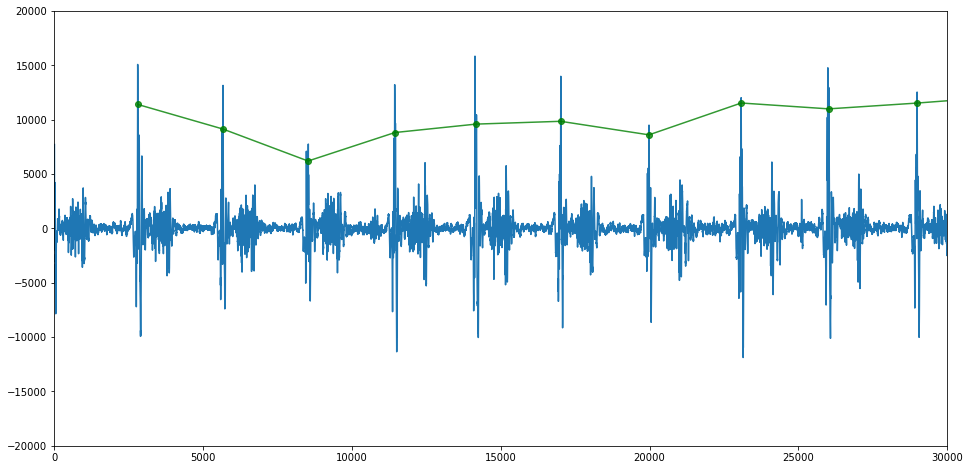

MV 33151_MV.wav
[ 1655  4645  7702 10766 13677 14780 16555 19456 22292 24941 27526 30247
 31392 33077 35732 38461 41370 42506 44368 47103 49789 52535 55354 57883
 58728]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


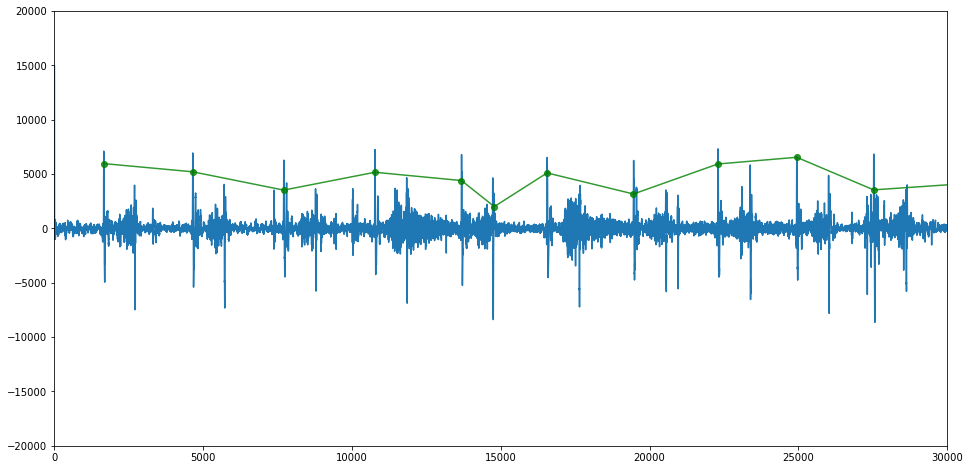

In [223]:
check_ith(11)

36327 4 4000
AV 36327_AV.hea 36327_AV.wav 36327_AV.tsv
PV 36327_PV.hea 36327_PV.wav 36327_PV.tsv
TV 36327_TV.hea 36327_TV.wav 36327_TV.tsv
MV 36327_MV.hea 36327_MV.wav 36327_MV.tsv
#Age: Adolescent
#Sex: Male
#Height: 174.0
#Weight: 108.6
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49630

AV 36327_AV.wav
[   82   523  2230  3370  5215  5762  6347  8469  9605  9981 10303 11391
 11893 12264 12897 14714 15842 17683 18795 20656 21782 23665 24788 26739
 27862 28663 29700 30826 31560 32817 33815 35850 36980 39219 40238 42391
 43526 44361 45541 46654 47134 48478 49609 50141 50484 5

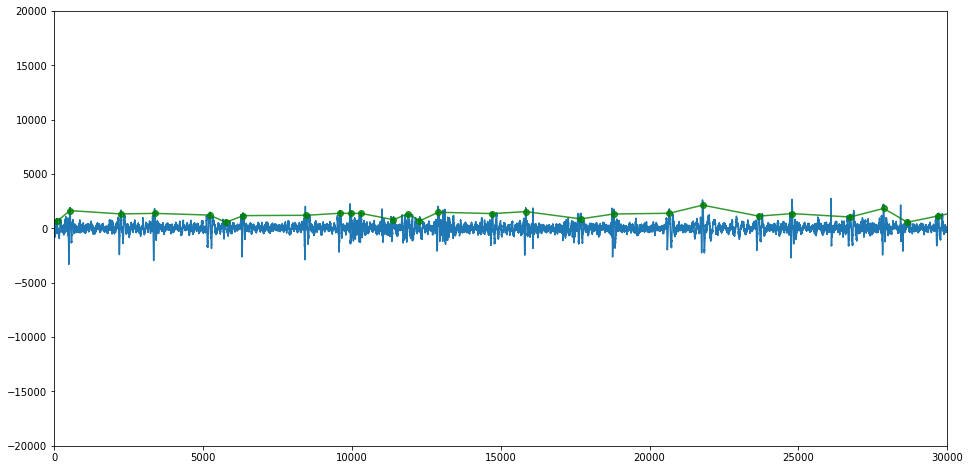

PV 36327_PV.wav
[   21   393  2215  3142  4847  5769  7732  8665 10872 11802 14116 15055
 17100 18025 19957 20067 21006 22748 23222 24167 26504 27455 28791 29568
 30508 32489 33429 35549 36509 38598 39564 41715 42682 44631 45585 47534
 48501 50685 51653 53873 54845 56986 57946 58319 59794 60882 62789 63754
 65853 66814 69242 70201 72427 73379 75372 76317 78370 78746 79328]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


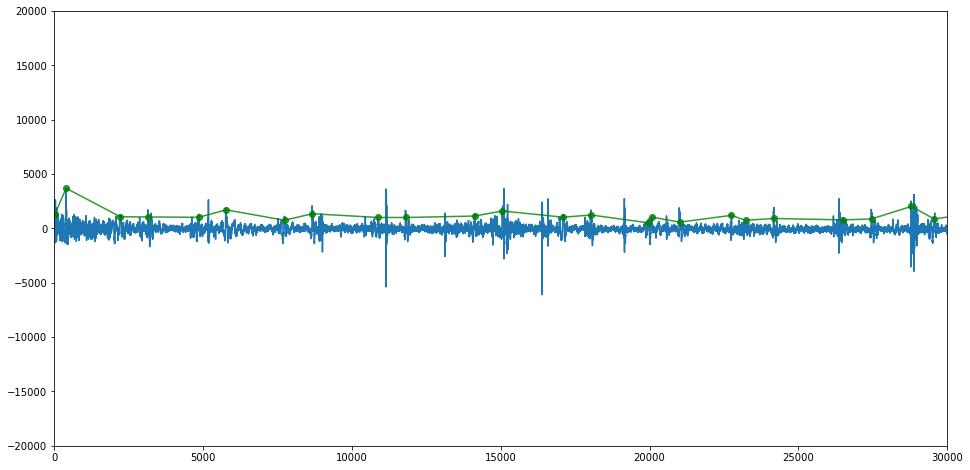

TV 36327_TV.wav
[  164  3174  4380  6151  7242  9094 10308 12067 15223 18537 21585 22674
 24127 24692 25793 26604 27902 28012 29006 31180 32153 34056 37148 40275
 41364 43387 44471 46251 47328 49164 52332 55459 56545 58430 59511 61341
 64506 67653 68738 70551 73514]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


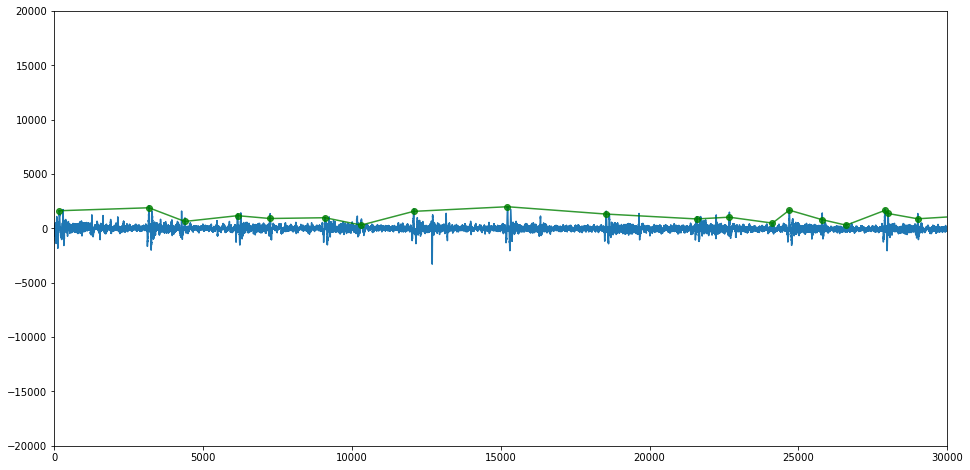

MV 36327_MV.wav
[   76   393  1044  1559  2246  3364  4371  6266  8184  9283 10378 10933
 12195 12565 13364 15093 17998 18896 21159 24479 27830 28937 30853 31936
 32122 33873 35034 37113 40333 43184 44325 46113 48979 50143 51879 54604
 57309 59921 62465 64943 67686 70425 72635 73403 76404 79342]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


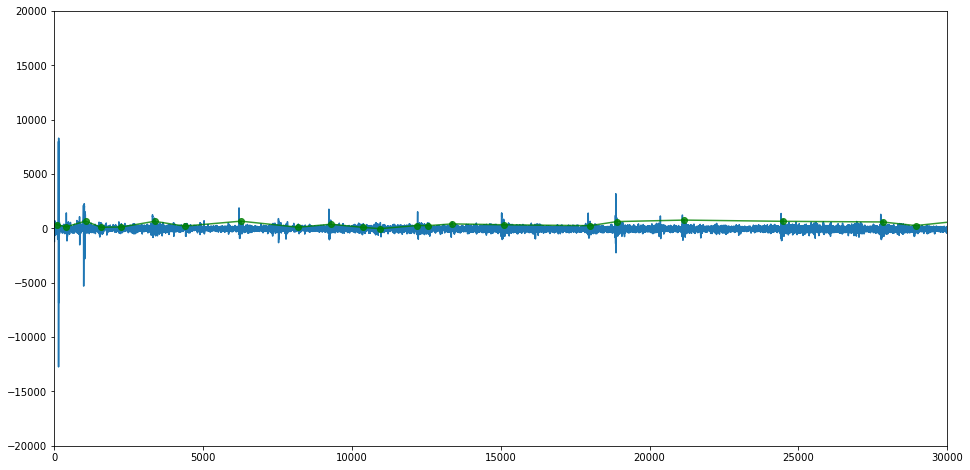

In [224]:
check_ith(12)

38337 2 4000
AV 38337_AV.hea 38337_AV.wav 38337_AV.tsv
MV 38337_MV.hea 38337_MV.wav 38337_MV.tsv
#Age: Child
#Sex: Female
#Height: 76.0
#Weight: 10.5
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49622

AV 38337_AV.wav
[  364   706  1310  1618  2393  2704  3124  3883  4014  4412  4720  5573
  6489  7047  7568  7916  8768 10340 11069 11963 12705 13797 14566 15545
 17212 17972 19016 19801 20858 21626 22645 24518 25299 26304 27084 27888
 29249 31182 32597 33057 33860 34934 35722 36625 37550 38483 40474 41488
 42272 43176 44003 45340 46221 47400 49455 50273 51415 54108]
[1915 4032 1817  655  949 1135 37

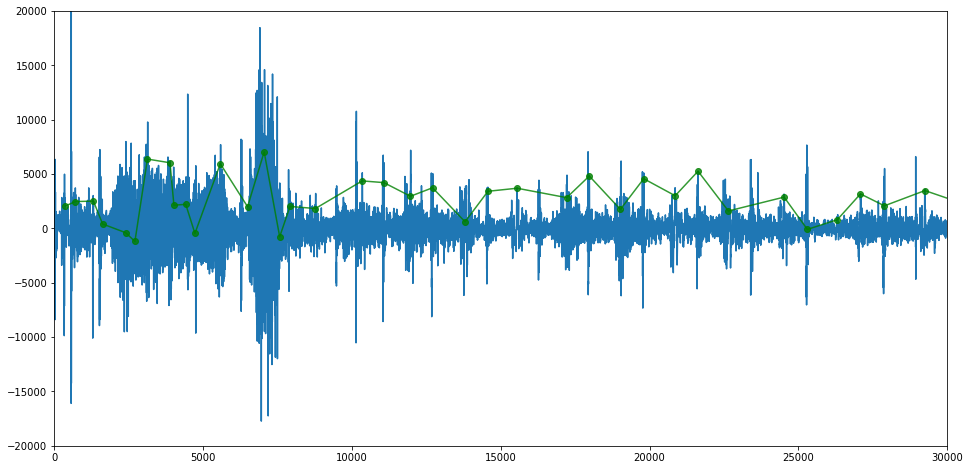

MV 38337_MV.wav
[  317   639  1044  1634  2416  3406  4292  5304  6173  7202  7944  8155
  8945  9743 10735 11590 12609 13391 14414 15139 16129 16997 18003 18849
 19885 20614 21611 22332 23318 24053 25052 25851 26843 27969 28153 28569
 29010 30064 31123 31943 32140 32987 33788 34814 35720 36744 37917 38778
 39563 40611 41305 42308 43067 44068 45046 45994 46733 47762 48465 49461
 50210 51206 51969 52998 53668 54667 55355 56327 56852 57264 58058 58734
 59717 60606 61383 62052 63057 63698 64665 65420 65792 66400 66928 67282
 68316 69016 70166 70704 71937]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


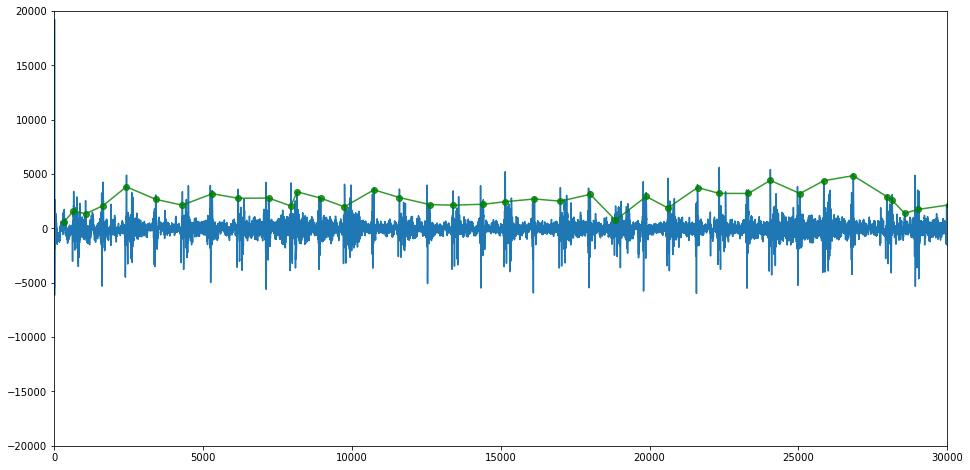

In [225]:
check_ith(13)

39043 4 4000
AV 39043_AV.hea 39043_AV.wav 39043_AV.tsv
PV 39043_PV.hea 39043_PV.wav 39043_PV.tsv
TV 39043_TV.hea 39043_TV.wav 39043_TV.tsv
MV 39043_MV.hea 39043_MV.wav 39043_MV.tsv
#Age: Child
#Sex: Female
#Height: 108.0
#Weight: 17.2
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 39043_AV.wav
[ 1174  1782  2353  4225  5491  5994  6953  8056  9461 10850 14040 16202
 17335 17698 18972 19587 20097 21894 23123 24392 24716 25649 26770 27200
 28465 30094 31340 32683 33995 35491 36333 36768 37656 38018 38525 38965
 39607 42174 47774]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473

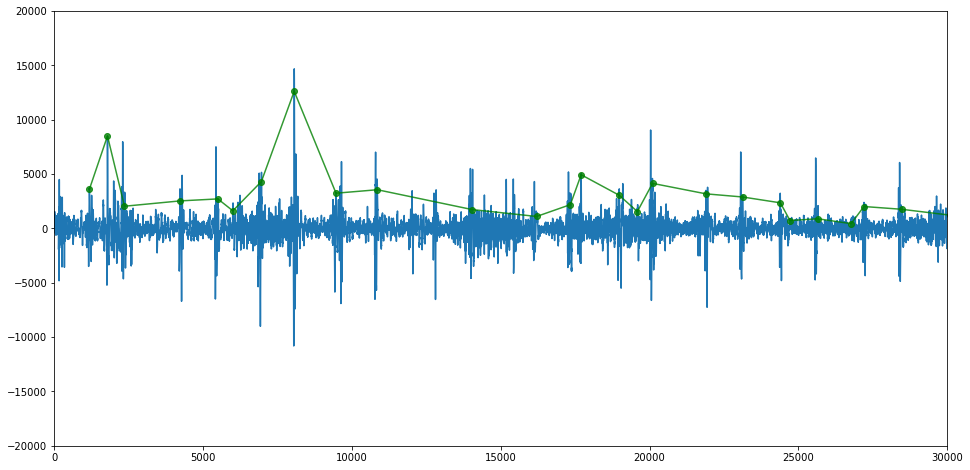

PV 39043_PV.wav
[ 1531  1847  2706  4069  5268  6623  7835  9780 11000 12977 14194 16025
 17220 18703 19898 21475 22658 24678 25880 27736 30337 31497 32902 34105
 35679 36887 38593 39904 41295 42471 43947 44034 45155 46904]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


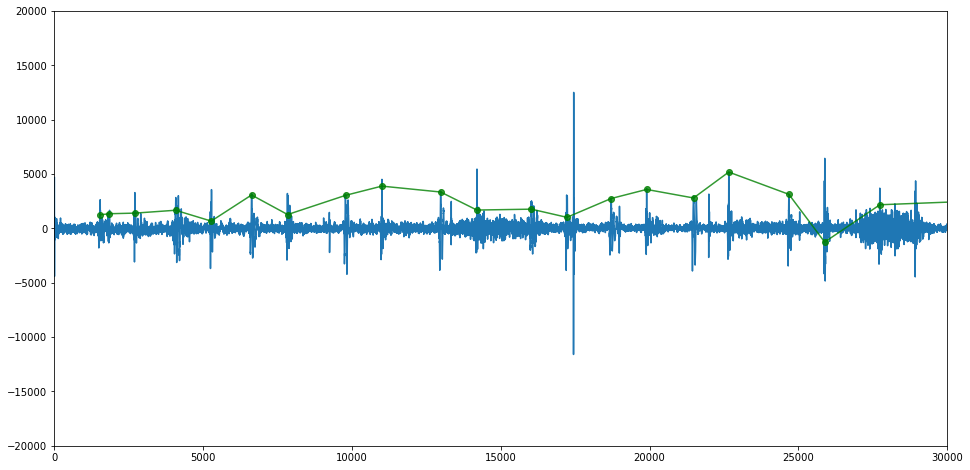

TV 39043_TV.wav
[  754  2020  4780  7170  8383  9508 10696 12115 13450 14479 15809 18152
 20798 23671 25046 26387 27017 27372 28698 29699 30912 32396 35628 37909
 38528 39669 41274 43972]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


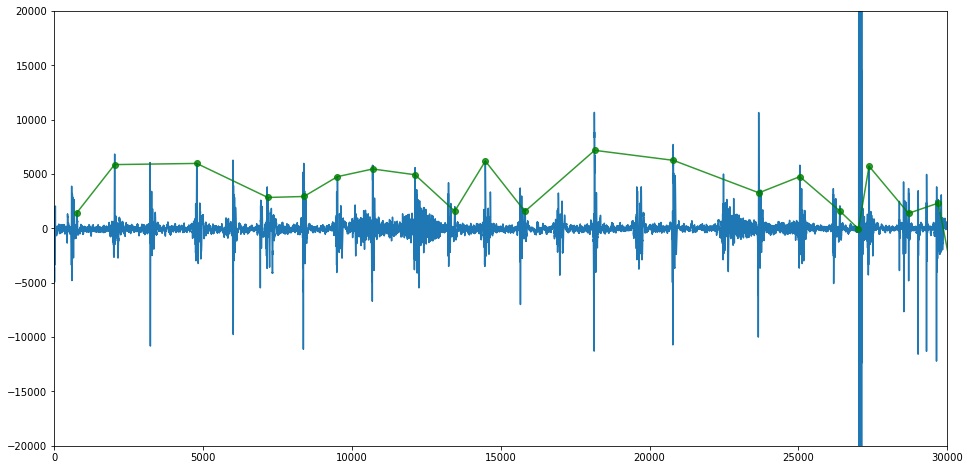

MV 39043_MV.wav
[  423  1038  3831  4678  5287  6016  6457  7488  7842  9032  9347 11361
 12814 14085 15851 16073 17112 17710 18560 19727 21069 22338 23841 25117
 26809 27978 28040 29378 29983 30556 31892 33180 34634 35885 37702 38866
 40294 41496 42973 44266 46004 47293 49831 50280 52824 54003 55285 56446
 57719 59489 60075 60395 61588 62058 62436 63095 63455 64348 65538 66754
 67974 68025 69423 70631 71437 71950 73155 74321 75577 76352 76982 78248
 79778 80926 81769 82085 83333 84329 85557 85906 86703 87859 88092 89105
 90230 91442]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


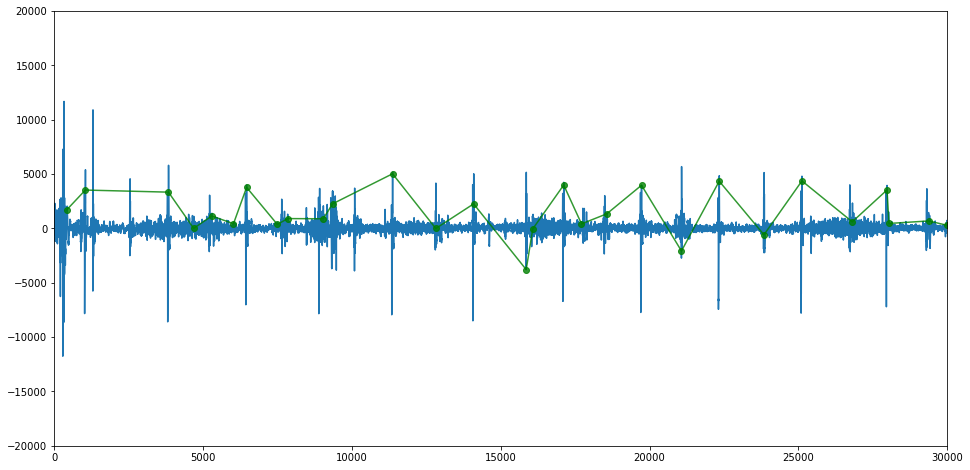

In [226]:
check_ith(14)

39403 4 4000
AV 39403_AV.hea 39403_AV.wav 39403_AV.tsv
PV 39403_PV.hea 39403_PV.wav 39403_PV.tsv
TV 39403_TV.hea 39403_TV.wav 39403_TV.tsv
MV 39403_MV.hea 39403_MV.wav 39403_MV.tsv
#Age: Child
#Sex: Female
#Height: 76.0
#Weight: 9.05
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 39403_AV.wav
[  169   634  1031  1761  2101  2849  3598  4200  4658  4989  5444  5776
  6097  6617  7115  7440  7902  8082 10884 12090 12514 12975 13397 14044
 14707 15301 15922 16061 16438 16965 17476 17946 18564 18896 19488 19944
 20041 20416 21113 21853 22393 22991 23660 24926 25844 26148 26717 28439
 29627 31578 

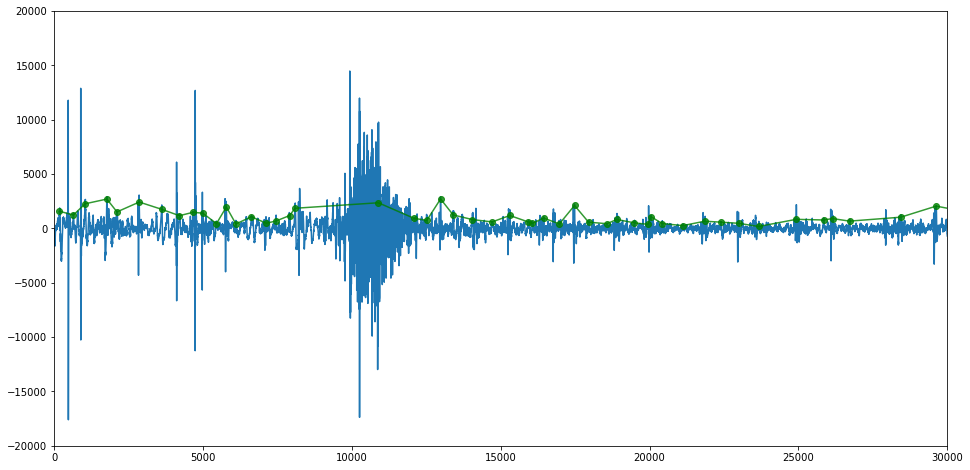

PV 39403_PV.wav
[  340   655   956  1296  1704  2306  2795  3144  3862  4029  5274  5668
  7043  8863  9502 10741 11770 13119 13743 14417 14992 15526 16471 16914
 17217 17686 18609 19125 19436 19843 20149 20651 20967 21812 22310 22787
 23143 23496 24158 24601 25445 26060 26410 26777 27094 27427 27809 28217
 28703 29149 29514 29860 30614 30978 31297 31675 35092 37826 40130 40536
 41652 42818 45607 46668 47376 48529 49384 49772 51166 51481 52601 54565
 55719 57819 58311 58974 60958 62085 63166 63886 64007 64530 66427 66987
 67352 68011 68335 68693 69154 69626 70003 70350 70864 71468 71946]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


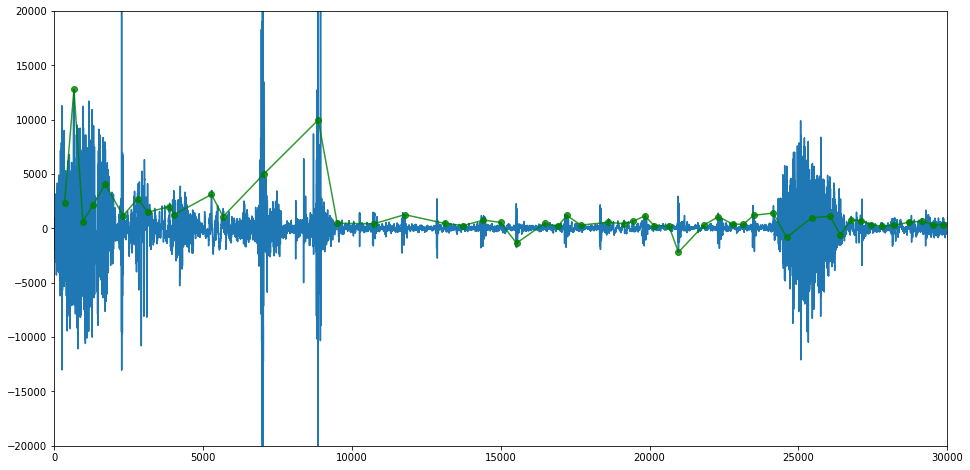

TV 39403_TV.wav
[  127   615  1174  4290  4613  5421  6745  7329  8560 10308 11542 13351
 15555 16694 17008 17391 17861 18987 20169 22353 24993 27616 30159 33411
 34950 35973 37274 38260 38872 39363]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


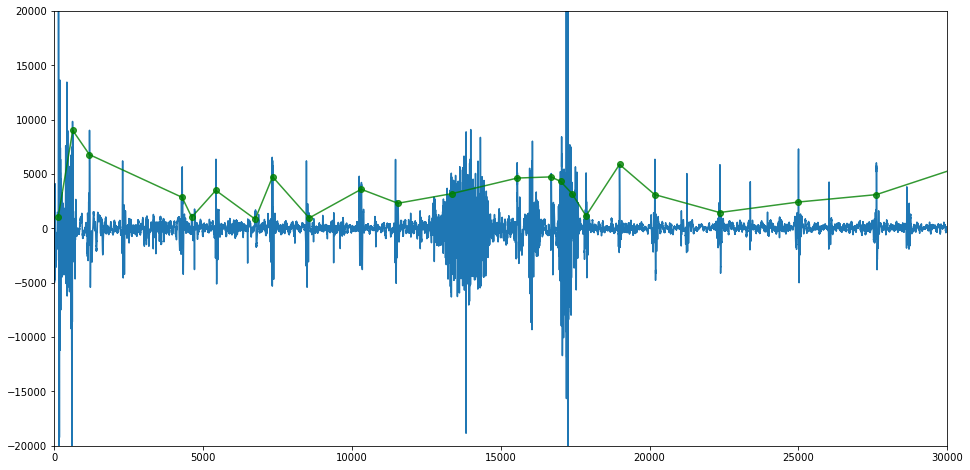

MV 39403_MV.wav
[  531  1623  2032  2354  2712  3206  3717  5090  6277  7488  9541 10078
 12257 12869 13459 14494 14945 15296 15842 16034 16898 18740 21060 23351
 24479 25711 28122 29336 29642 30562 31966 35598 36868 37543 40032 40920
 42088 43093 44219 46287 47369 47924 48533 49649 50761 51781 52324 52936
 56685 57223 58403 58860 59771 61330 62098 63215 64670 65779 66243 67107
 68217 68679 69552 71090 71813 72921 74240 75290 75646]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


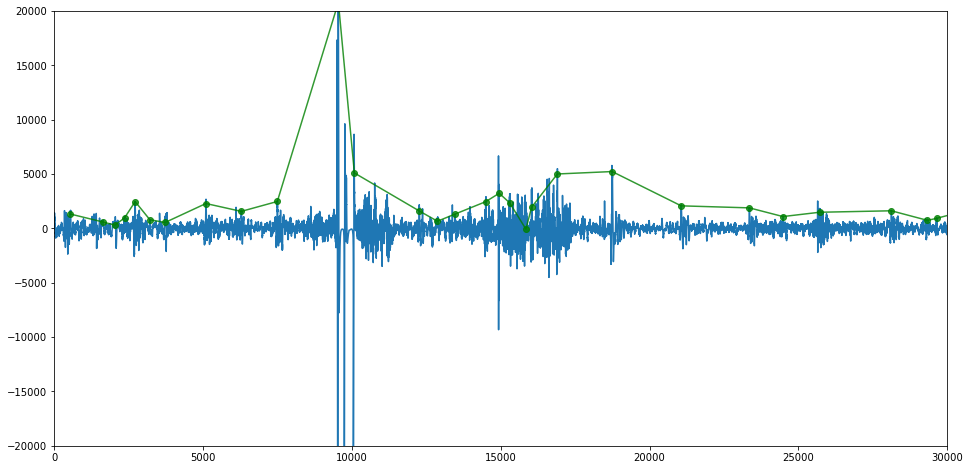

In [227]:
check_ith(15)

39456 3 4000
PV 39456_PV.hea 39456_PV.wav 39456_PV.tsv
TV 39456_TV.hea 39456_TV.wav 39456_TV.tsv
MV 39456_MV.hea 39456_MV.wav 39456_MV.tsv
#Age: Child
#Sex: Female
#Height: 88.0
#Weight: 12.1
#Pregnancy status: False
#Murmur: Unknown
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

PV 39456_PV.wav
[  125   611  1455  1789  3065  3610  4010  5098  6148  7219  8312  9375
 10505 11559 12844 13895 15353 16418 17900 18983 20496 21576 23184 24275
 26038 27159 30071 30924 31583 32718 35334 36714 37246 37846 39069 40335
 42773 44114 45216 46593 47687 49046 50135 51528 52618 54009 55086 56465
 57554 58948 60036 61348 62432 63824 66998 68731 69485

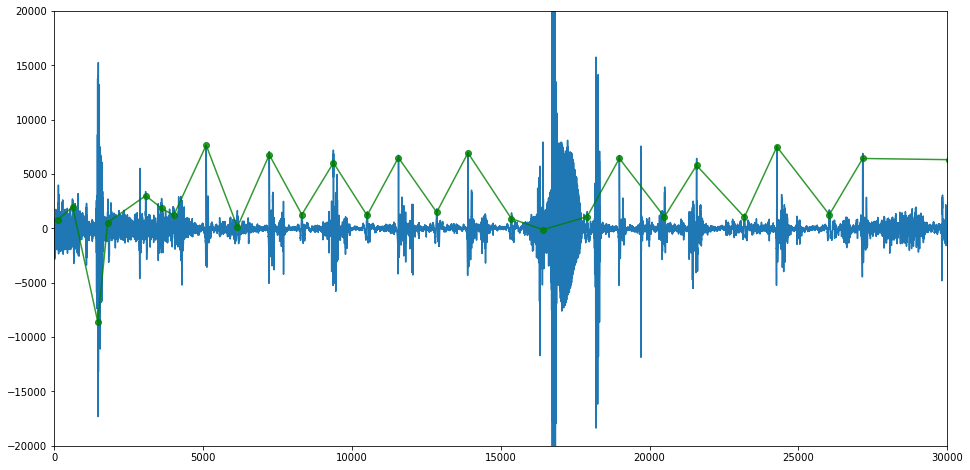

TV 39456_TV.wav
[  2491   5337   7687  10047  12372  14706  17014  19450  21790  23073
  24147  24606  24988  28791  30990  33193  35426  37675  39965  42285
  43475  44612  46932  48340  49250  52737  53477  55579  57835  60268
  62990  64193  65648  66704  68516  69120  69568  71381  73826  74234
  76706  79091  81473  82672  84021  85915  86844  87797  88094  88600
  89471  92117  93186  94740  97284  98161  99756 102198 104595 106934
 109261 111641 114089 114657]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


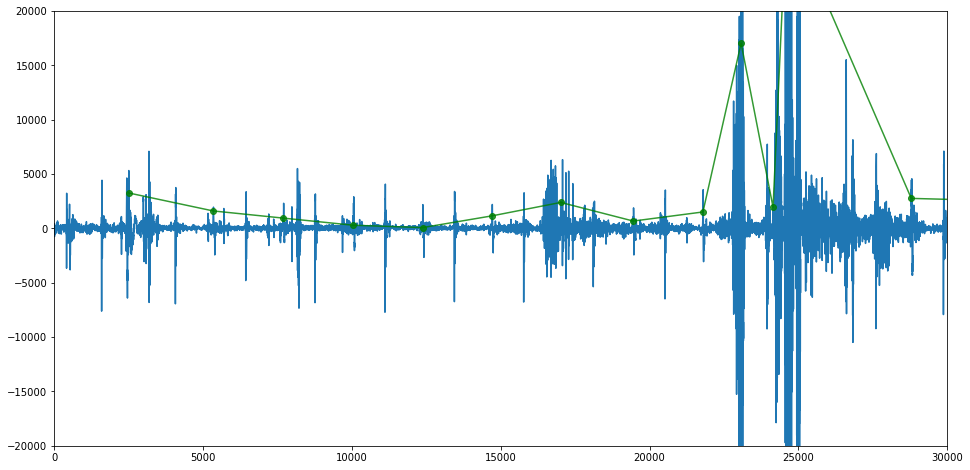

MV 39456_MV.wav
[  183  1075  4021  4363  4849  5388  5981  6344  6976  7583 11542 12682
 13286 13737 14767 15810 16034 16913 17471 17932 18959 19475 19980 21049
 22706 23205 24278 25310 26375 26763 27618 28181 28482 28848 29854 30450
 31136 31756 32145 33328 34464 35726 36730 37290 38035 38352 39172 39808
 40559 40942 41666 42553 42964 44058 45444 46625 47239 47705 50777 52375
 53464 54112 54583 56289 57625 58162 58653 59442 59921 60045 60628 61749
 62340 62653 63153 63780 64994 65325 68050 68450 69469 69828 70433 71483
 71840 72950]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


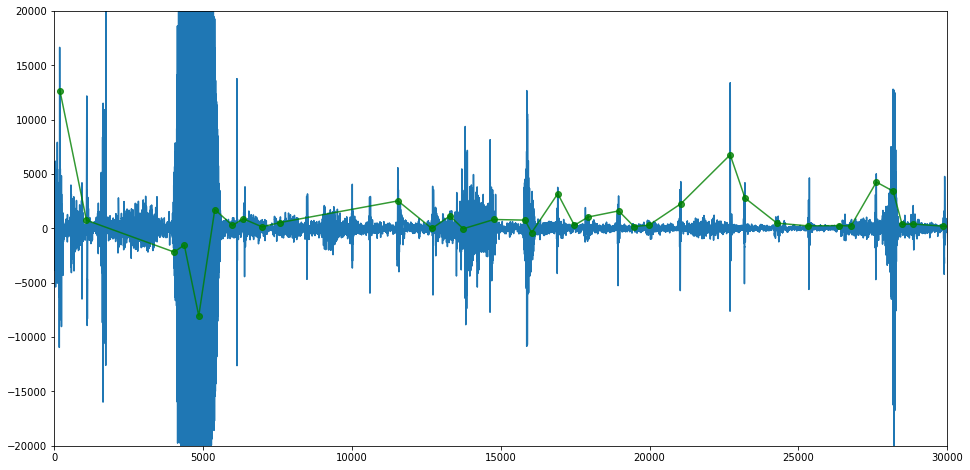

In [228]:
check_ith(16)

40058 4 4000
AV 40058_AV.hea 40058_AV.wav 40058_AV.tsv
PV 40058_PV.hea 40058_PV.wav 40058_PV.tsv
TV 40058_TV.hea 40058_TV.wav 40058_TV.tsv
MV 40058_MV.hea 40058_MV.wav 40058_MV.tsv
#Age: Child
#Sex: Female
#Height: 125.0
#Weight: 23.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 40058_AV.wav
[ 2079  2858  3404  4611  5572  6884  9339 10287 11055 11684 12878 14682
 17279 22207 23783 24867 25935 27380 28236 32791 34627 35333 37243 39836
 42447 43425]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1

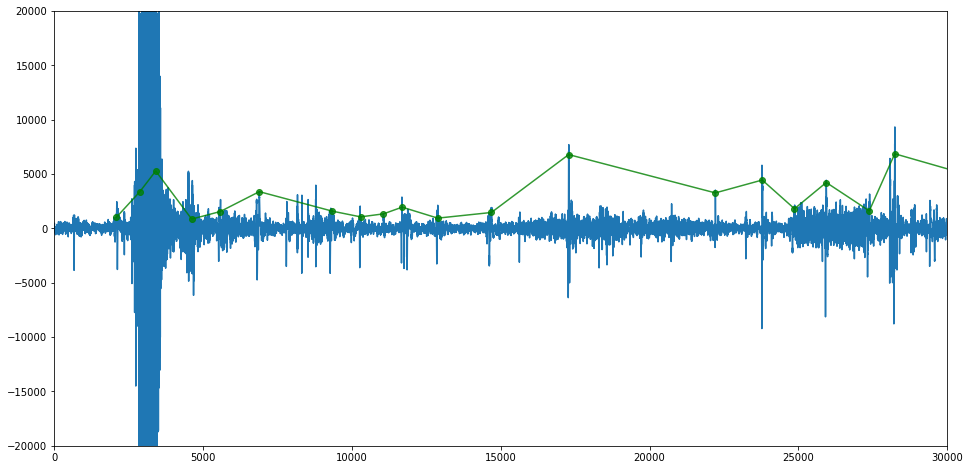

PV 40058_PV.wav
[  417  1526  2427  3146  4140  5581  6570  8232  9240 10212 10999 12012
 13831 14850 16634 17502 19151 20282 21925 23043 24625 25735 27113 28203
 30666 32309 32814 33306 33645 34174 34644 35004 35483 35784 36048 39028
 40781 41921 43475 44499 45958 46962 48141 49224 50440 51399]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


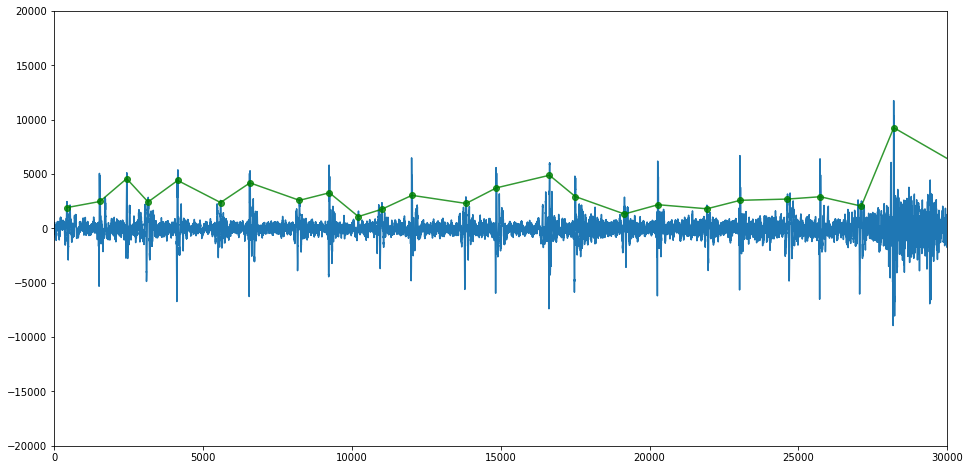

TV 40058_TV.wav
[ 1466  2546  3937  5018  6502  7583  9063 10128 11493 12543 13813 14878
 16273 17276 18725 19717 21017 22065 23457 24468 25871 26945 28434 29426
 31789 33257 34277 35833 36833 38257 39326 40848 41876 43402 44413 45841
 46908 48293 49385 50963 51985 53501 54503 55848 56936 58351 59443 60859
 61946 63435 64435 65664 66740 68091 69177 70611 71625 72948 74011 75157]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


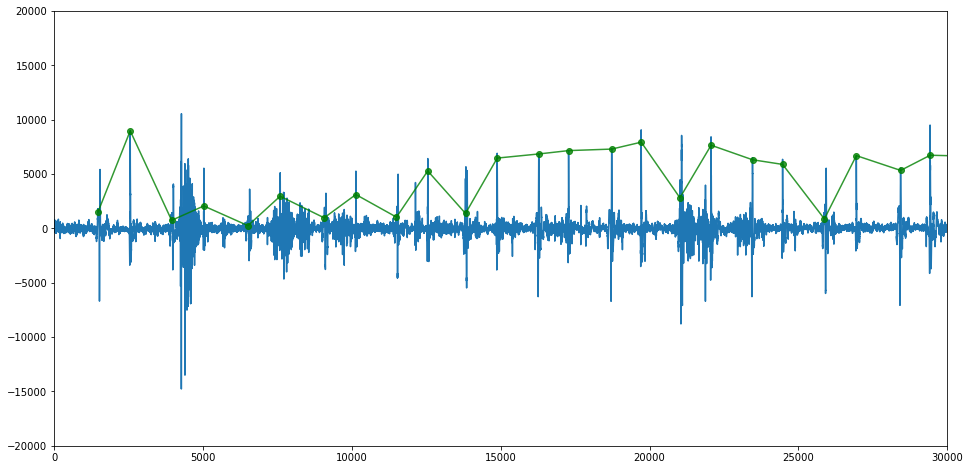

MV 40058_MV.wav
[  1003   1853   3485   5802   8022   8346   9666   9988  10419  12870
  13830  15169  16171  17655  18670  20200  22497  23480  24044  24899
  25932  27455  30036  32511  33490  34738  35747  37142  39506  41857
  42823  43127  43436  43804  44068  45042  46267  47418  47729  48436
  49421  50996  52033  54152  55258  56942  58063  59600  60618  63035
  64063  65550  66130  66560  66863  67207  67561  68330  69384  70871
  71243  72257  72573  72924  73444  74086  75098  75785  76825  77866
  79448  80483  81144  82001  83032  84382  85384  86580  87568  88857
  89847  91341  92338  93911  94915  96523  97622  99102 100104 101655
 102654 102967 103291 103652 104230 105252 106060 106482 106844 107866
 109431 109771 110262 112996 114293 115319 115891 116732 118228 119205
 121576 122580 123826 124078 124837 125397 125784 126147 127916]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  

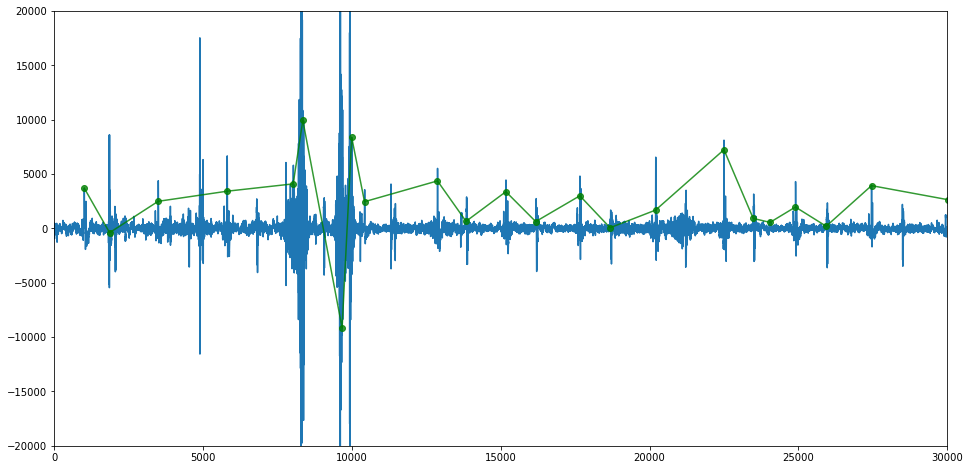

In [229]:
check_ith(17)

40798 4 4000
AV 40798_AV.hea 40798_AV.wav 40798_AV.tsv
PV 40798_PV.hea 40798_PV.wav 40798_PV.tsv
TV 40798_TV.hea 40798_TV.wav 40798_TV.tsv
MV 40798_MV.hea 40798_MV.wav 40798_MV.tsv
#Age: Child
#Sex: Male
#Height: 116.0
#Weight: 22.5
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 40798_AV.wav
[  124   576  1958  2479  2810  4041  5097  5786  6463  7430  8392  8790
  9269  9572 10100 10602 11160 11746 12637 13130 14038 15092 15415 15838
 16298 17222 18620 19503 22408 23403 24512 25520 28239 29285 30779 31643
 33102 33963 35679 36547 38377 39251 40723 41572 43003 44132 44803 45366
 45751 46287 4

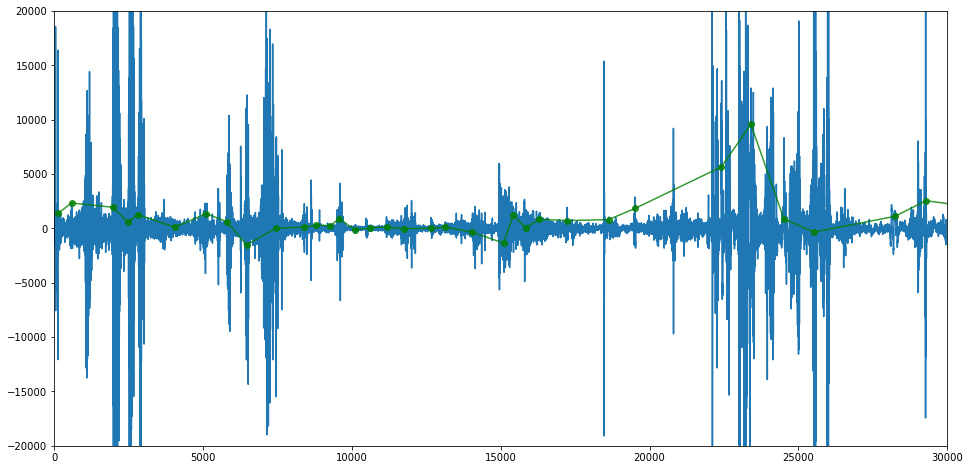

PV 40798_PV.wav
[  413  1277  2222  2549  2869  3411  4576  5548  6720  7687  9054  9902
 11034 11963 13158 14116 15388 16356 17689 18518 19668 20613 21887 22847
 24213 25188 27408 28760 29611 31068 32047 33488 34468 35740 36685 37945
 38916 40377 41356 42867 43854 46066 47374 48358 49753 50737 52187 53169
 55361 56758 57748 59177 60165 61463 62429 63634 64604 65989 66973 68489
 69481 70738 71141 71694 72910 73254 73889 75188 76170 77542 78522 80657
 81849 82821 83938]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


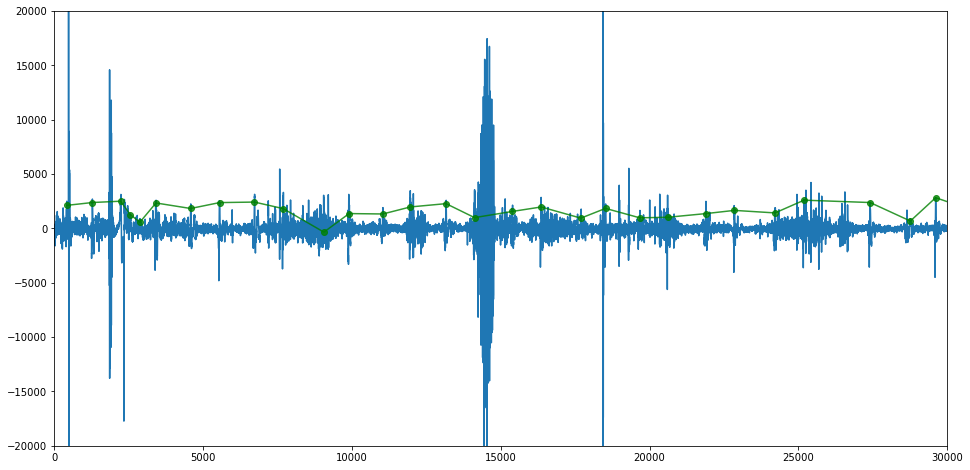

TV 40798_TV.wav
[   376    915   1547   1928   2840   3718   5075   7349   8238   9805
  10702  12190  13057  14489  16812  17712  18153  18556  19098  20099
  21175  21582  21902  22454  23871  26313  28627  30764  31714  33154
  34133  35654  36538  37797  40094  42512  43394  44706  45574  46823
  47790  49200  50165  51746  52631  53894  54321  54966  55959  56155
  57135  58489  59475  60914  61879  63154  65430  66412  67936  68128
  68927  70350  70968  71376  72627  73756  75047  75713  76018  77577
  78459  79980  80080  82342  83218  84836  85714  86994  89454  90224
  91871  92778  94262  95159  96560  98689  99653 101234 103495 104474
 106023 106915 108178 110728 111632 113311 114226 114545 115812]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  

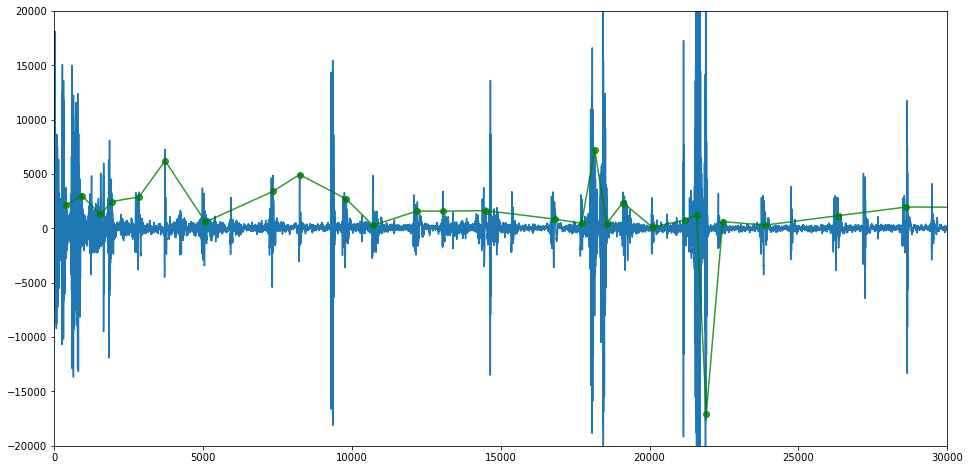

MV 40798_MV.wav
[  357   757  1600  1997  2578  3911  4912  6368  7285  8592  9765 11163
 11641 11980 13121 16271 20887 21819 23343 23841 24113 25432 26367 26808
 27222 27640 28631 29021 29905 30818 31965 32881 34005 35020 36517 37486
 39206 40167 41421 42300 43665 44006 44313 44695 45479 46057 47164 48187
 48547 49546 50687 51615 53002 54032 55577 56622 57976 58377 58981 59976
 60210 61171 62836 63762 65903 66956 69068 73633 74579 76110 76948 78244
 78661 79039 79458]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


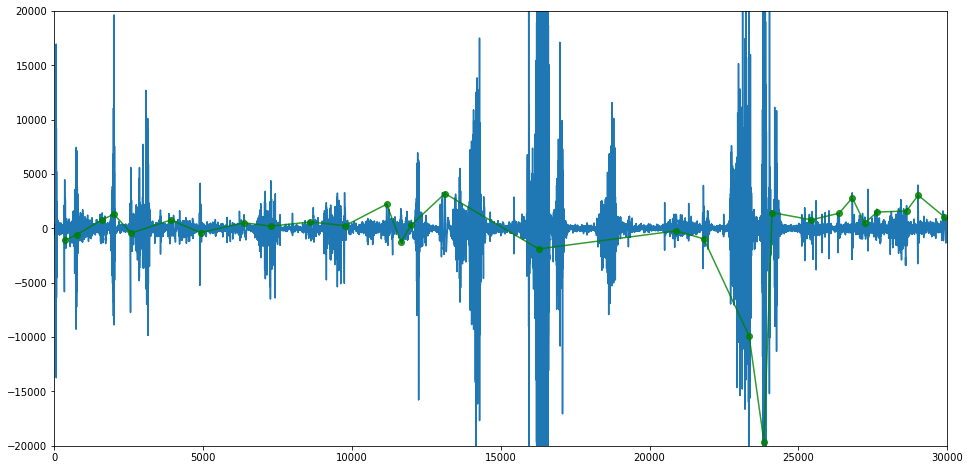

In [230]:
check_ith(18)

40840 4 4000
AV 40840_AV.hea 40840_AV.wav 40840_AV.tsv
PV 40840_PV.hea 40840_PV.wav 40840_PV.tsv
TV 40840_TV.hea 40840_TV.wav 40840_TV.tsv
MV 40840_MV.hea 40840_MV.wav 40840_MV.tsv
#Age: Adolescent
#Sex: Female
#Height: 147.0
#Weight: 36.1
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Mid-systolic
#Systolic murmur shape: Diamond
#Systolic murmur grading: III/VI
#Systolic murmur pitch: High
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 40840_AV.wav
[  183  2040  2646  3132  3503  3931  4328  4807  5415  5962  6411  7259
  7678  8026  8451  8856 10642 11768 13573 14698 15083 16673 17204 17711
 19536 20179 20664 21081 22385 23498 25292 26428 26833 28321 29461 29845
 31455 32589 34590 35721 37575 38695 39141 40591 4172

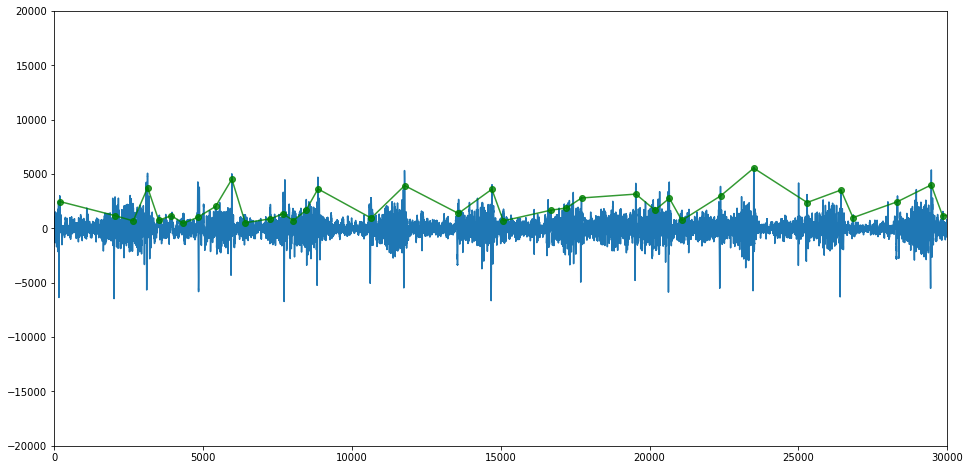

PV 40840_PV.wav
[  403   708  1178  1993  2620  3773  4033  4397  5937  6584  6986  8940
 10083 11867 12144 12613 13019 14957 16118 18139 19314 21358 22509 24354
 25495 27304 28462 30323 31483 33430 34595 36519 37671 39358 40512 42154
 43291 45075 46109 47916 49061 50881 52027 53751 54899 56721 57886 59848
 60133 60450 61025 62164 63103 63869 64264 66406 67566 69557 70708 72584
 73745 75703 76866 78843 79851 81978 83130]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


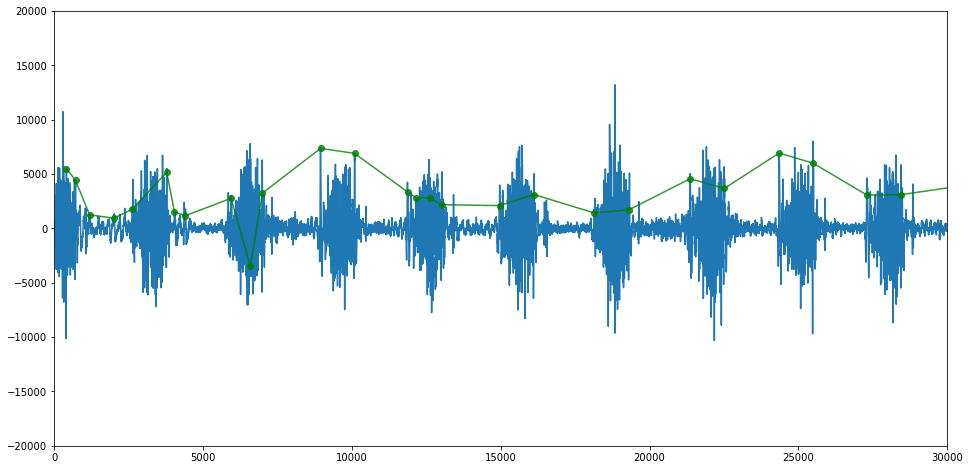

TV 40840_TV.wav
[   24  1135  3058  4177  6202  7328  9347 10469 12488 13603 15526 16637
 18594 19720 21700 22833 24833 25969 27922 29048 30858 31978 32097 33839
 34987 36884 38041 40081 41236 43292 44444 46386 47507 49440 50595 52611
 53779 55849 57011 59063 60211 62119 63261 65214 68344 69500 71550 72704
 74641 75776 77644 78733]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


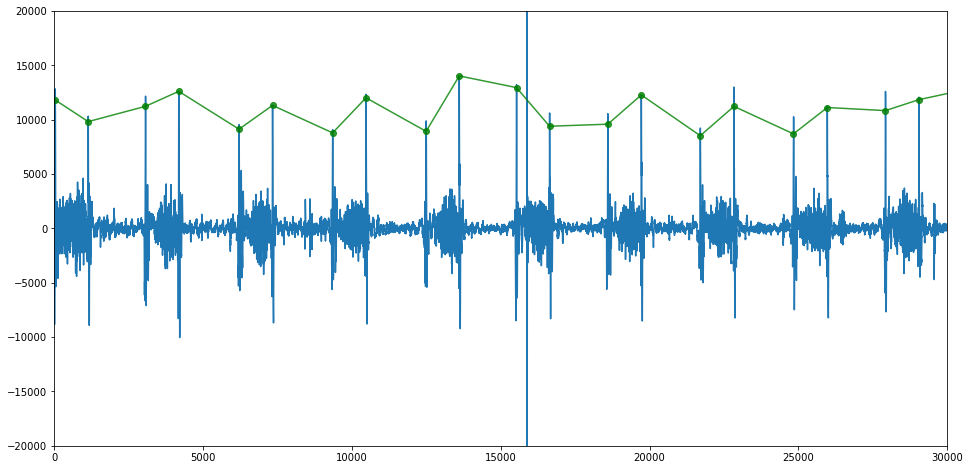

MV 40840_MV.wav
[ 1954  3395  4980  8105 11051 13995 16960 19948 20058 22836 25739 28667
 31811 34601 37476 40434 43494 46442 49338 52314 55343 58313 61159 63983
 64106 65118 66876 69777 72646 75471 78350]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


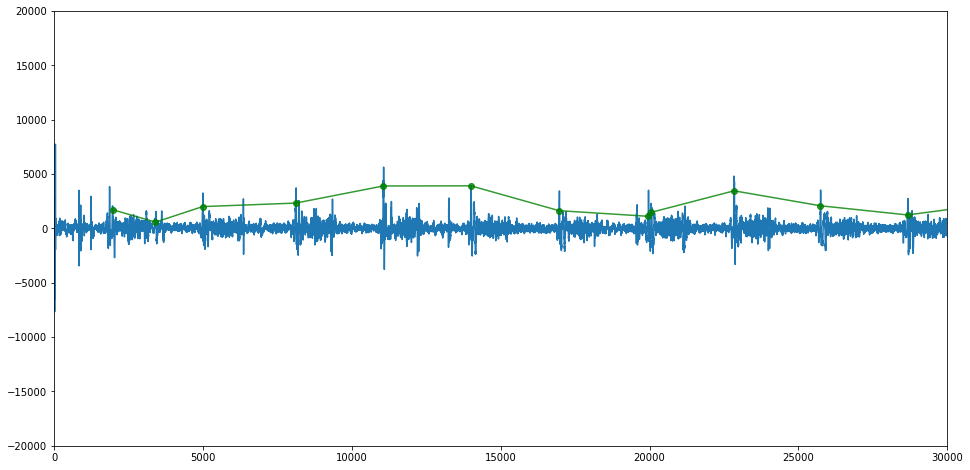

In [231]:
check_ith(19)

43852 4 4000
AV 43852_AV.hea 43852_AV.wav 43852_AV.tsv
PV 43852_PV.hea 43852_PV.wav 43852_PV.tsv
TV 43852_TV.hea 43852_TV.wav 43852_TV.tsv
MV 43852_MV.hea 43852_MV.wav 43852_MV.tsv
#Age: Child
#Sex: Female
#Height: 69.0
#Weight: 9.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

AV 43852_AV.wav
[    4   513   916  2493  2806  3243  3545  3984  4071  4589  5237  6461
  7051  7762  8409  9144  9821 11357 12771 14372 15788 16319 17108 18716
 20303 21402 21713 23225 24758 26401 27173 27901 29404 31044 31910 32641
 34233 35847 39081 40703 41660 42233 43358 43829 45497 46283 47204 47952
 48284 48758 502

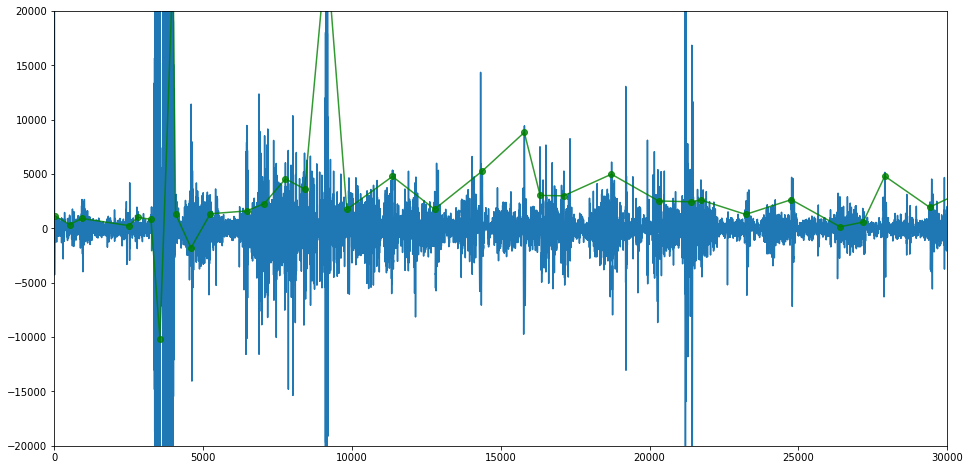

PV 43852_PV.wav
[   47   703  1558  4589  6845  7681  9277 10848 11538 12376 13091 13972
 14640 15496 16210 17088 17785 18659 19379 20278 21841 23482 24309 25094
 25943 26727 28373 29101 29964 30693 31540 32287 33153 33884 34750 35489
 36336 37068 37944 38673 39526 40292 41166 41923 42772 44397 45154 46003
 47633 48340 49187 49926 50821 51514 52367 53103 53998 54710 55574 56290
 57198 57892 58779 59509 60409 61131 61999 63644 64382 65260 66000 66870
 67616 67937 68502 69220 70261 71708]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


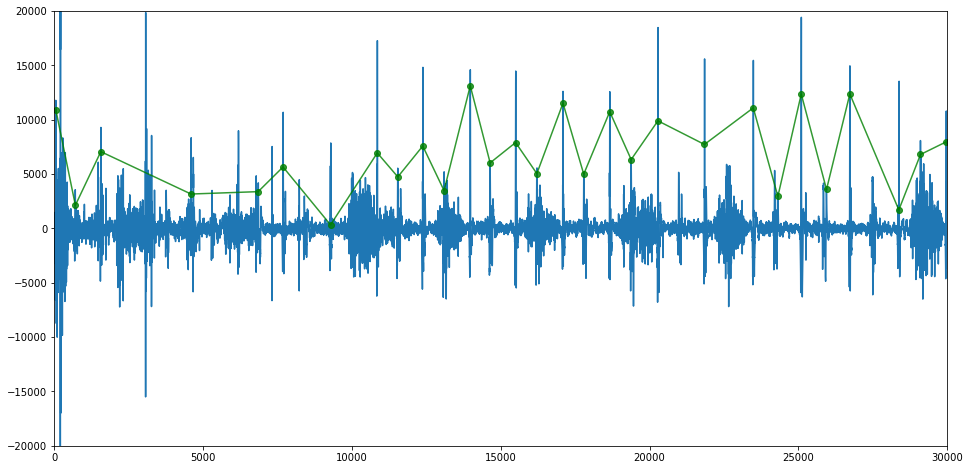

TV 43852_TV.wav
[  552  2146  3716  5294  6884  8472 10080 11688 13308 14926 16521 18123
 19690 21273 22825 24393 25981 27592 29195 30806 32427 34037 35668 37284
 38893 40501 42121 43728 45354 46972 48623 50269 51944 53595 55258 56905
 58535 60147 61771 63424 65780 68367 70038 71702 73367 75011 76674 78344
 81670 83311]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


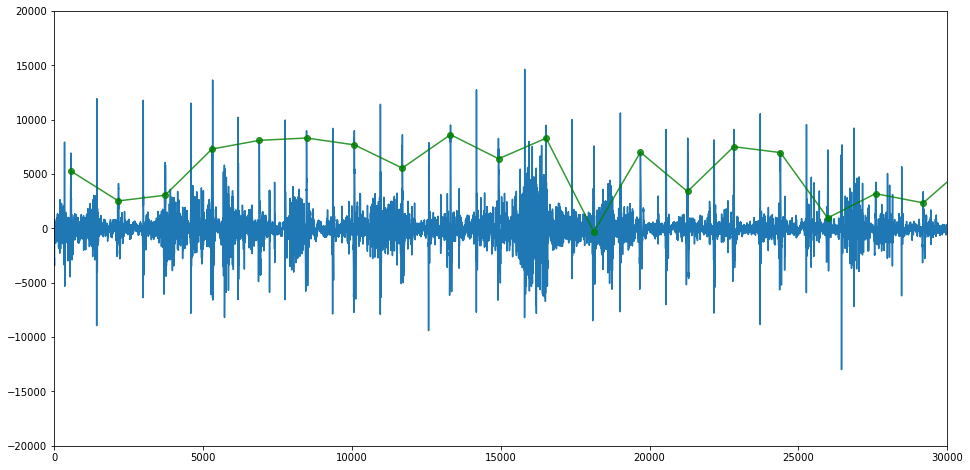

MV 43852_MV.wav
[ 2403  7737  8415  8909  9611 10425 10834 11407 12106 12483 12906 14301
 15654 16007 16545 16881 17366 17677 18025 18494 18938 19470 20251 21120
 21791 22580 23195 24106 24701 25007 25528 26144 27016 27831 28496 30782
 31977 32040 32935 36798 37589 37903 38329 39217 39927 40039 40725 41067
 41441 42217 42541 42981 43818 44543 45389 46085 46941 47632 48421 49215
 50065 50785 51644 52392 53252 54005 54861 55660 56523 57272 58140 58940
 59806 60532 61443 62266 63137 63872 64782 65622 66509 67336 68217 69077
 69948 70753 71685 72533 73409 73990 75059 75988 76864 77663 78490 79385]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


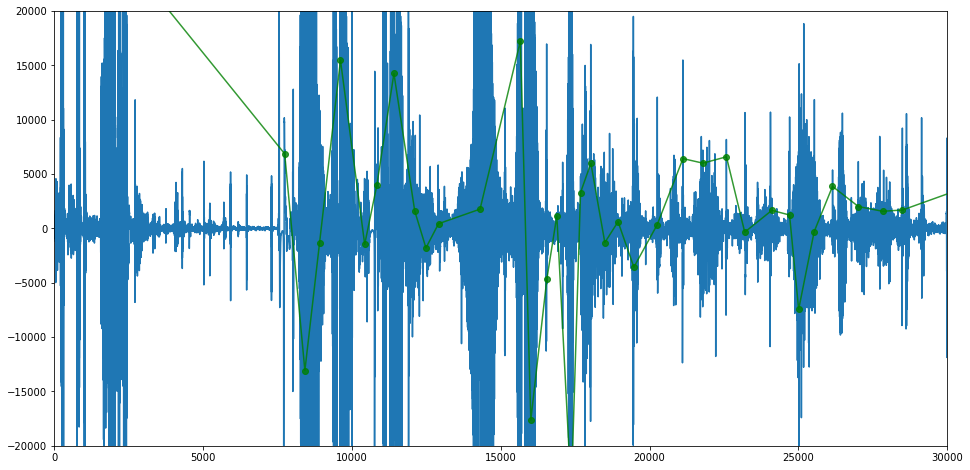

In [232]:
check_ith(20)

44514 4 4000
AV 44514_AV.hea 44514_AV.wav 44514_AV.tsv
PV 44514_PV.hea 44514_PV.wav 44514_PV.tsv
TV 44514_TV.hea 44514_TV.wav 44514_TV.tsv
MV 44514_MV.hea 44514_MV.wav 44514_MV.tsv
#Age: Adolescent
#Sex: Male
#Height: 152.0
#Weight: 39.5
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: PV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: III/VI
#Systolic murmur pitch: High
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 44514_AV.wav
[  964  1962  3799  4697  6481  7469  8776 12932 14632 15627 17373 18352
 20106 21102 22715 23760 25273 26267 28146 28806 30401 31387 32907 33921
 35410 36386 37962 38939 40449 41457 42935 43910 45477 46447 47958 48960
 50408 51385 52880 53838 55296 56308 57723 58691 60203 

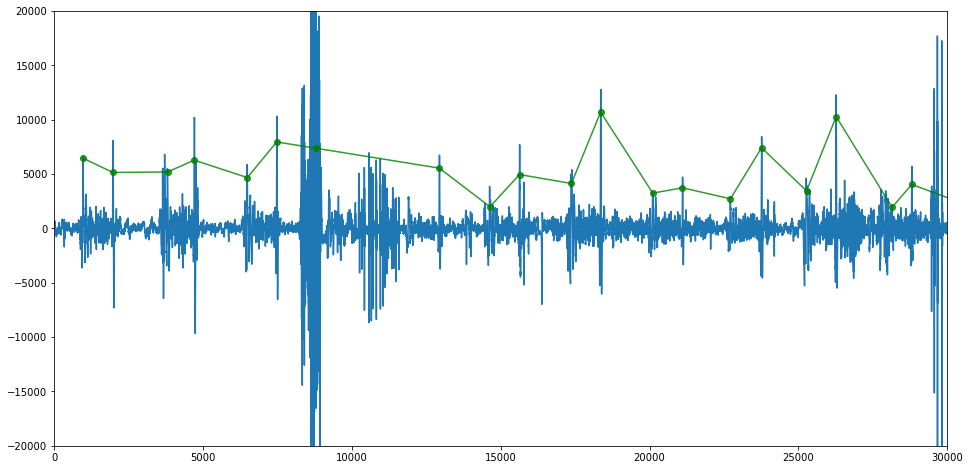

PV 44514_PV.wav
[  276  1759  2674  4171  5161  6782  7765  9395 10390 11882 12891 14449
 15428 17018 17994 20599 20973 21577 22207 22977 25697 26215 27368 28261
 30914 32573 33489 35142 36149 37779 38776 40374 41413 42949 43950 45581
 46573 48204 49215 50752 51784 53292 54285 55888 56877 58497 59496 61034
 62068 63555 64545 66151 67126 68708 69710 71190 72206 73734 74715 76272
 77238 78781 79803]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


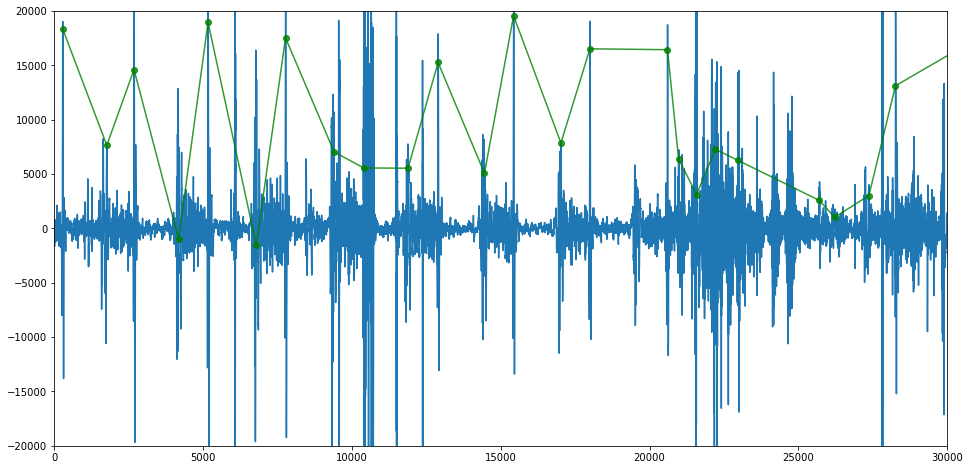

TV 44514_TV.wav
[ 1010  3456  4966  5917  7403  8746 12349 13296 14723 15756 17253 18236
 19673 20627 22121 23318 24566 25553 26957 28188 29392 30355 31747 32780
 34210 35240 36744 37711 39159 40145 41637 42600 44038 47839 49102 50180
 51570 52630 54078 55135 56629 57697 59231 60994 61873 62894 65386 67832
 70377 71004 72977 75535 78108 79673 80624 82177 83023 83521]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


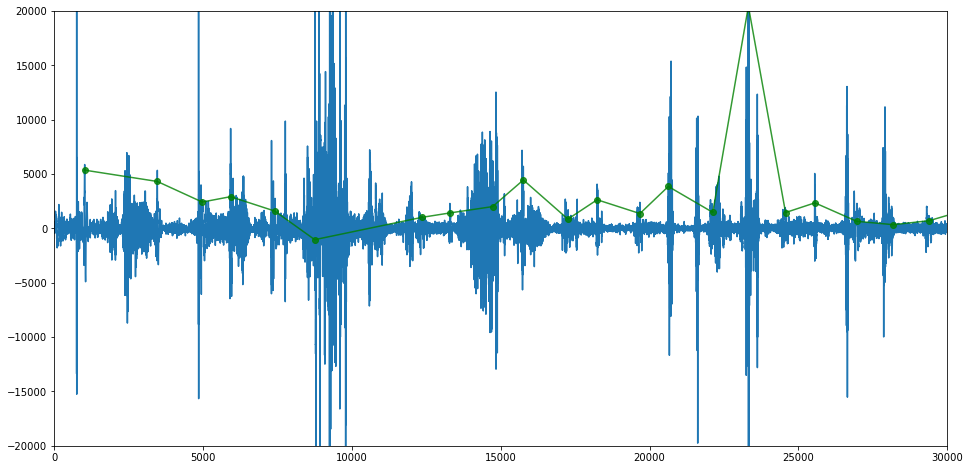

MV 44514_MV.wav
[  141  1237  2648  3755  5092  5751  6215  7527  8634 10007 11134 12461
 13594 14909 16034 17458 18576 20117 21256 22900 24048 25628 26789 28258
 28816 29435 30846 31976 33497 34625 35931 36068 38615 41154 43722 46241
 48705 51177 53634 56101 58550 60983 63431 65915 68346 70777 73235 75717
 78180 80612 83111]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


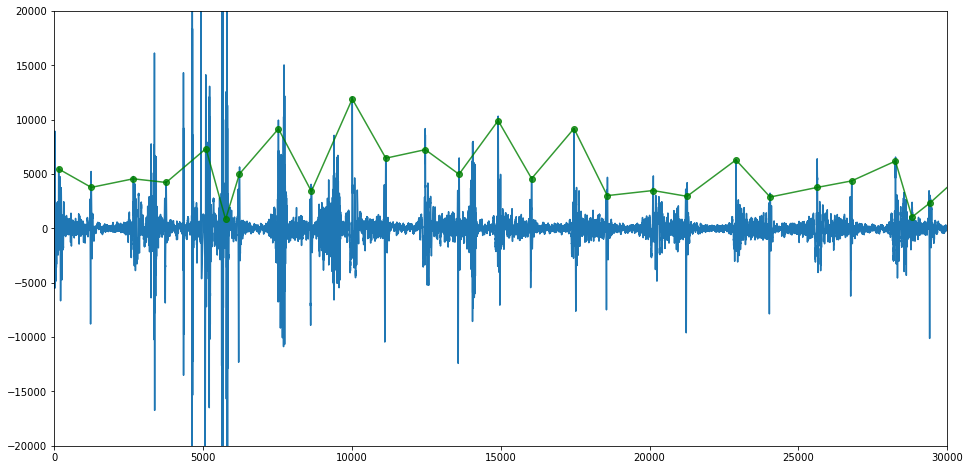

In [233]:
check_ith(21)

45843 4 4000
AV 45843_AV.hea 45843_AV.wav 45843_AV.tsv
PV 45843_PV.hea 45843_PV.wav 45843_PV.tsv
TV 45843_TV.hea 45843_TV.wav 45843_TV.tsv
MV 45843_MV.hea 45843_MV.wav 45843_MV.tsv
#Age: Adolescent
#Sex: Female
#Height: 141.0
#Weight: 34.4
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+TV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Decrescendo
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49821

AV 45843_AV.wav
[ 1667  3713  4108  4476  5747  6552  7944  8106  8715 10121 10991 12309
 13053 14437 16435 18433 19196 20478 21248 22575 23333 24678 26636 28277
 28621 29375 30591 31368 32778 33557 33965 35072 35437 35843 37077 37869
 39047 41042 43131 43920 45329 46096 47460 49432 51

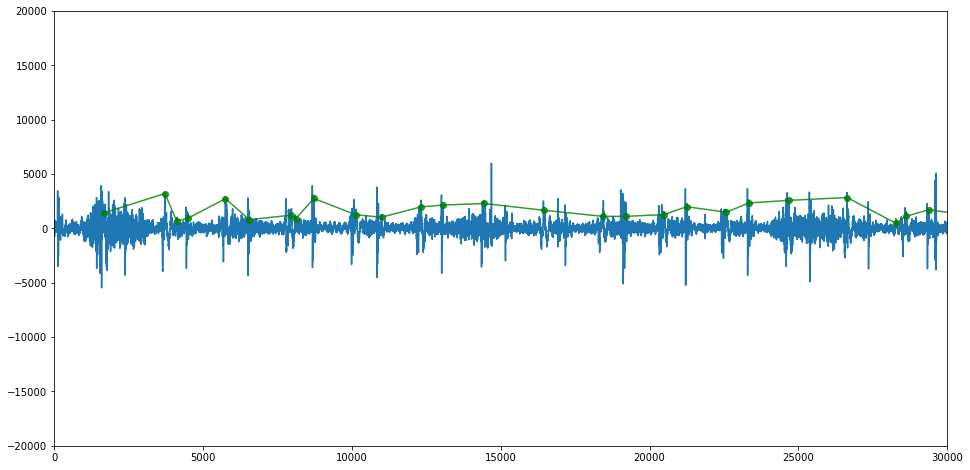

PV 45843_PV.wav
[  126   631  1698  2802  3600  4826  6724  8595  9462 10531 11439 12552
 14585 16496 18379 20301 21200 22286 23213 24308 26279 28199 30091 32036
 32885 33964 34889 35962 37905 39793 40740 41664 42581 43592 44494 45567
 46493 47568 49494 51402 52360 53337 54248 55311 56223 57378 58317 59393
 61317 63212 64145 65110 66002 67039 67958 68999 70915 72784 76597 77485
 78545 79449]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


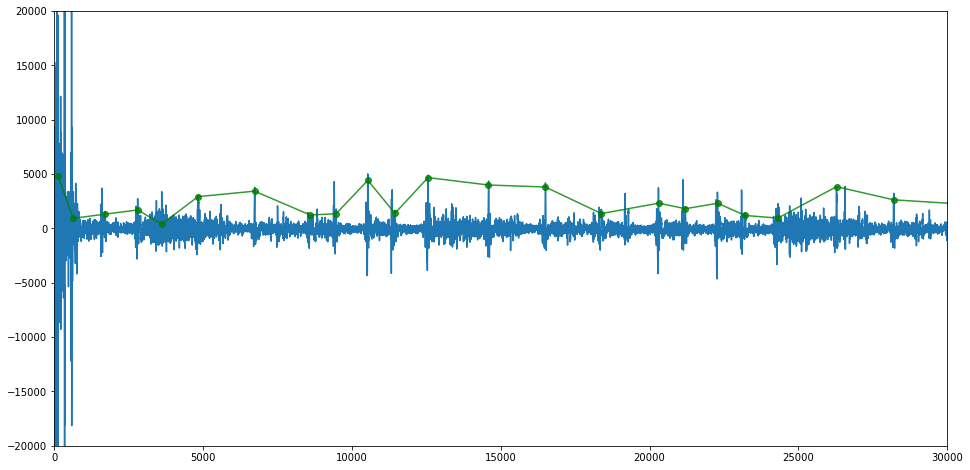

TV 45843_TV.wav
[ 1644  3915  5872  7862  9958 11985 12069 14164 16094 17902 19806 20677
 21923 22661 23956 24036 24748 26029 26825 27980 28091 28401 28797 29370
 29940 30310 30797 31176 31484 31940 32021 32746 34061 34765 35921 36035
 36720 37844 39903 41863 43719 44530 45617 46412 47484 49363 51433 53289
 54097 55166 57061 57859 58969 60991 61699 62807 63608 64702 66667 67494
 68653 69463 70696 71521 72730 74754 76798 77631 78977 79709]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


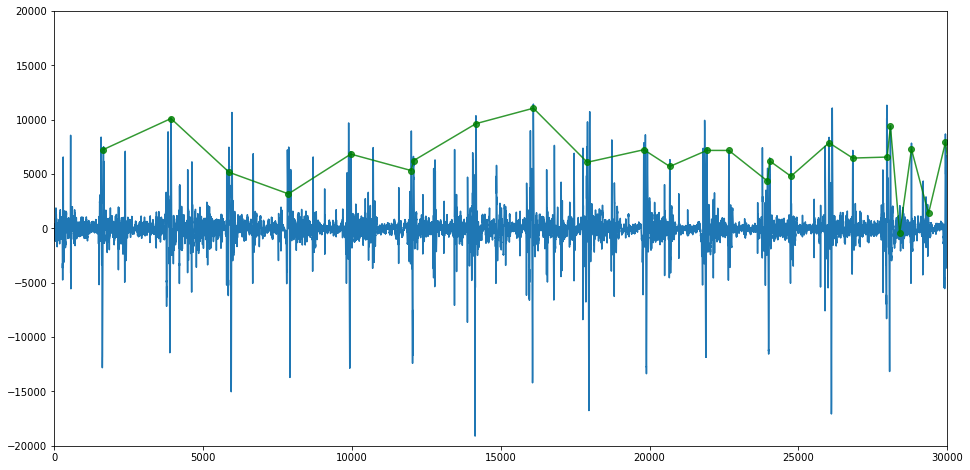

MV 45843_MV.wav
[ 1564  3494  5427  7431  9423 11314 12208 13303 14165 15328 17367 19255
 20164 21308 23323 25282 27262 28097 29164 30102 31157 33164 35142 37023
 38931 40889 42858 44749 46538 47446 48463 50407 52324 54253 56107 57949
 59854 60021 61845 63883 65997 67903 69772 71665 73583 75538 77358 79258]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


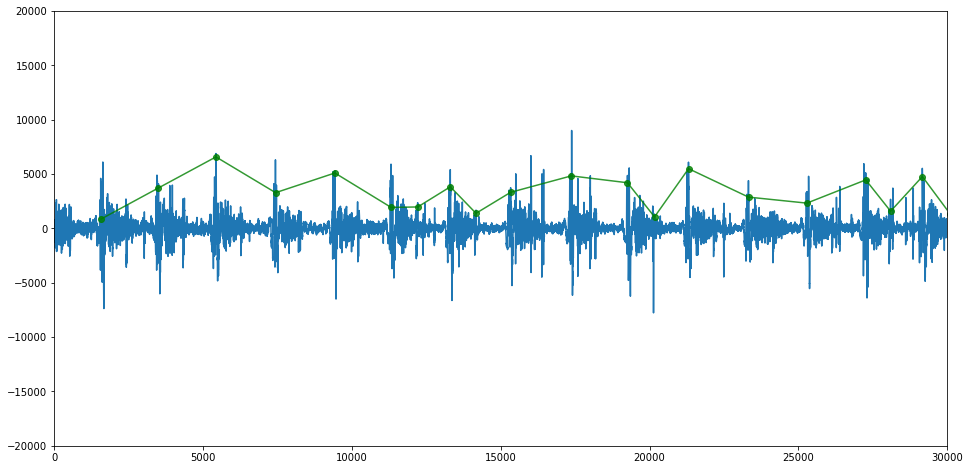

In [234]:
check_ith(22)

46065 4 4000
AV 46065_AV.hea 46065_AV.wav 46065_AV.tsv
PV 46065_PV.hea 46065_PV.wav 46065_PV.tsv
TV 46065_TV.hea 46065_TV.wav 46065_TV.tsv
MV 46065_MV.hea 46065_MV.wav 46065_MV.tsv
#Age: Child
#Sex: Male
#Height: 111.0
#Weight: 18.3
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Mid-systolic
#Systolic murmur shape: Diamond
#Systolic murmur grading: III/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 46065_AV.wav
[ 1057  2366  3456  4849  7341  8395  9696 10773 12147 13153 14629 17074
 18100 18544 19380 20469 21757 22226 22845 24229 26602 27675 28988 29355
 30076 31553 32637 33542 33993 35037 36157 37320 38413 38886 39587 40090
 40777 41522 41942 42629 43229 44373 45598 46556 47825 488

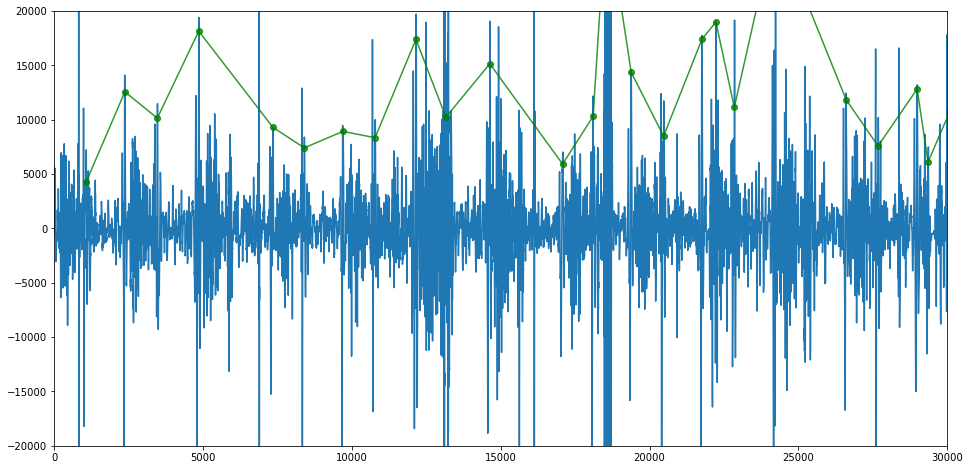

PV 46065_PV.wav
[  978  1883  2940  4019  5169  6247  7521  8573  9749 10811 11928 12077
 13009 14320 15398 16915 17982 19245 20297 21549 22470 23542 24677 26008
 27083 28493 29558 30705 31772 32876 33962 35369 36450 37892 38956 40088
 41163 42258 43345 44722 45814 47297 48374 50665 51779 52857 54000 55067]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


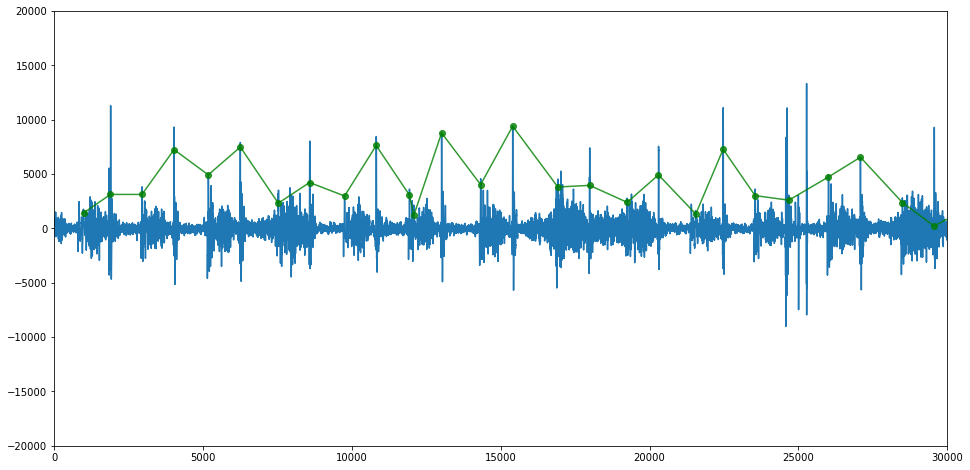

TV 46065_TV.wav
[  270  1826  4213  6382  8657  9623 10860 13371 14331 15696 16765 17831
 18893 20020 22288 24713 25776 26855 27924 29256 30230 31670 32753 34081
 34868 35231 36211 37281 38314 40739 41814 43165 45371 46437 47556]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


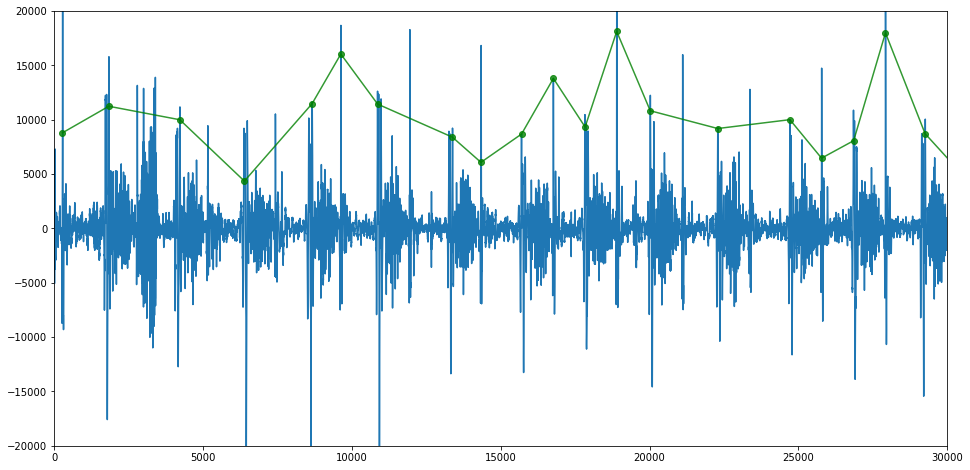

MV 46065_MV.wav
[   24   794  1961  3227  4400  6272  7440  8737  9915 11056 12216 13287
 14460 15605 16782 18139 19312 20507 21663 22718 23881 24897 26066 27251
 28413 29647 30800 31861 33006 33986 35147 36152 37314 38512 39671 40758
 41902 42870 44024 45013 46170 47387 48560 49862 51005 52047 53192 54209
 55369 56592 57752 58991 60143 61264 62399 64559 65618 66017 66767 69125
 70191 71317 73096]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


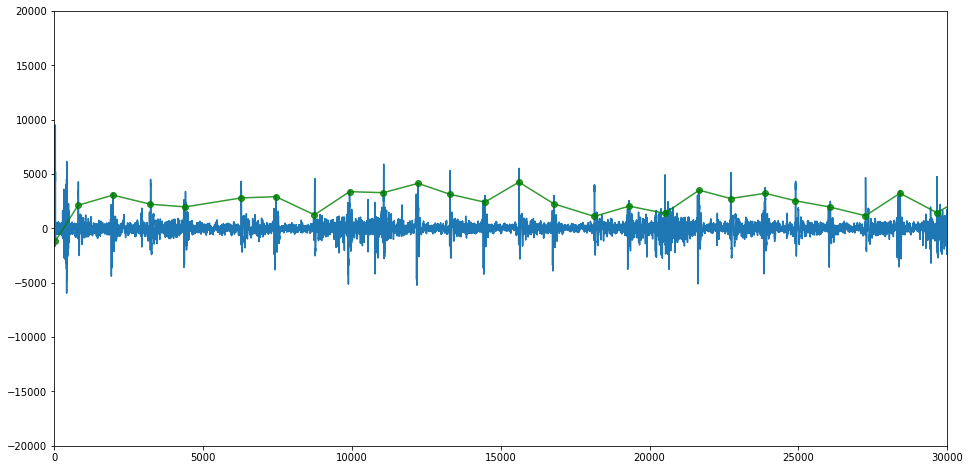

In [235]:
check_ith(23)

46532 1 4000
AV 46532_AV.hea 46532_AV.wav 46532_AV.tsv
#Age: Child
#Sex: Female
#Height: 70.0
#Weight: 9.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan

AV 46532_AV.wav
[ 1616  2709  3935  7222  7634  8632 11053 12295 12968 13691 14611 15890
 16201 17025 18598 19293 20767 25445 27544 29786 31888 33905 37399 38531
 38862 39684 40200 40678 41055 41501 42349 43534 44233 44544 45521 46247
 47468 47960 49580 50597 51573 53548 55462 58772 61842 64504 67147 69779
 71948 72358 72761 73153 74930 75350 75984 76183 76711 77921 78278 78982
 79614 79919]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517

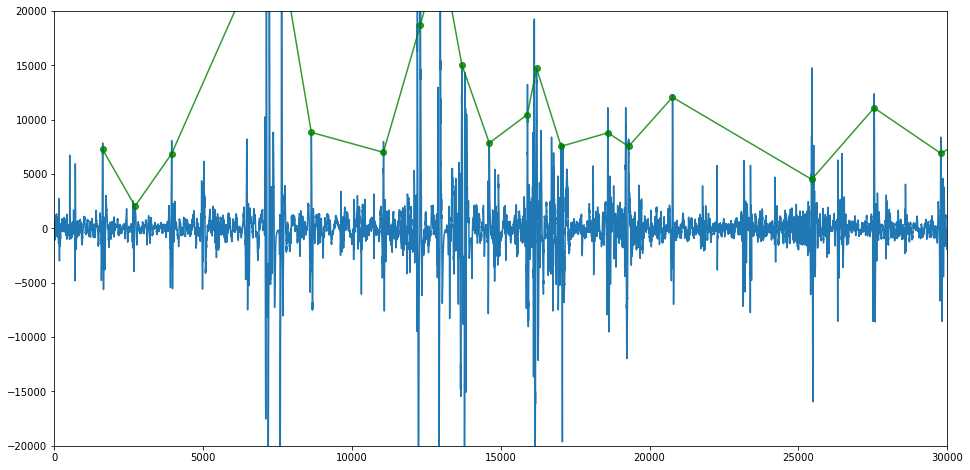

In [236]:
check_ith(24)

46579 4 4000
AV 46579_AV.hea 46579_AV.wav 46579_AV.tsv
PV 46579_PV.hea 46579_PV.wav 46579_PV.tsv
TV 46579_TV.hea 46579_TV.wav 46579_TV.tsv
MV 46579_MV.hea 46579_MV.wav 46579_MV.tsv
#Age: Child
#Sex: Male
#Height: 79.0
#Weight: 9.79
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49761

AV 46579_AV.wav
[   31   653  2180  3722  5265  6811  8353  9886 11434 12967 14500 16055
 17600 19142 20692 22239 23800 25379 26951 28549 30142 31743 33374 34995
 36610 37210 37751 38398 38862 39244 39847 40545 40957 41311 42921 44524
 46122 46470 46854 48240 48774 49225 50321 50768 51373 51830 5229

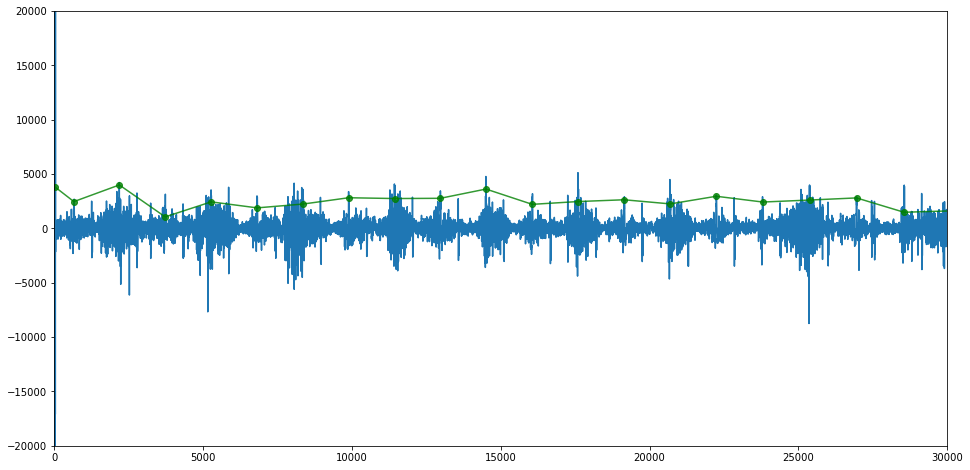

PV 46579_PV.wav
[ 1063  2496  3206  3941  4675  5387  6857  8316  9807 11327 12067 12815
 14328 15829 17357 18115 18872 19596 20400 21155 21945 22676 23464 23858
 24987 25736 26534 28093 28832 29675 30417 31257 32843 34439 36050 36805
 37664 39289 40902 42534 44140 45735 46483 47363 48122 48967 50532 52120
 52884 53681 54423 55249 56824 57564 58438 60047 61657 63248 64859 65646
 66443 67100 68020 69599 70345 71193 72798 74365 75126 75918 77509 79088
 80662 81434 82223 82962 83837]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


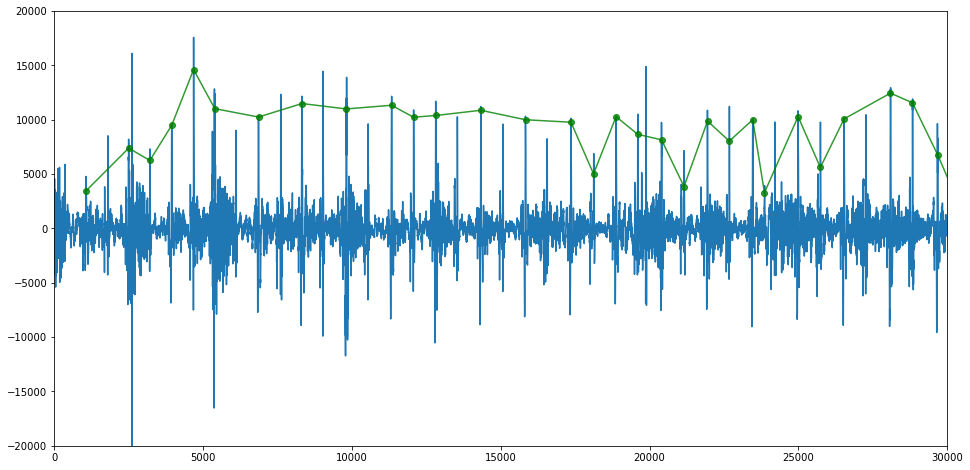

TV 46579_TV.wav
[  153  1038  1836  2612  3368  4960  5845  6613  8194  9000  9776 10539
 11249 11981 12128 12886 13661 14338 15055 15862 16014 16602 17403 18254
 19032 19832 20565 22103 22906 23565 24435 25130 25459 26000 26692 27065
 27579 28235 29120 29899 30680 31415 32303 33093 33868 34578 36228 39398
 40160 40965 41732 42456 43334 44084 44748 45661 46308 47219 47947 48886
 49670 50479 51264 51970 52052 52839 53641 54416 55273 55926 56067 56918
 57709 58568]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


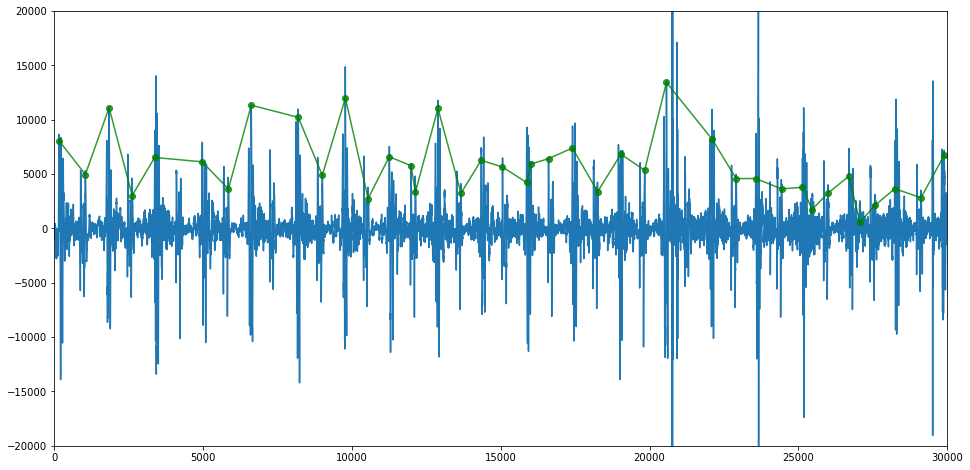

MV 46579_MV.wav
[  472  2190  3110  3710  5389  6154  6894  7684  8590  9344 10091 11749
 13318 14870 16431 17889 19517 21041 22526 23622 24161 24563 25708 27265
 28791 29490 30413 31112 31945 32577 34569 36434 37929 38799 39129 39510
 40270 40915 42489 43875 45429 46329 46756 47325 48279 49735 51197 52602
 54160 55612 57164 58655 60160 61691 63247 64816 66405 67391 69555 72733
 73427 74319 75037 75909 76613 77496 78357 79100 79810 80686 82292 83006
 83974]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


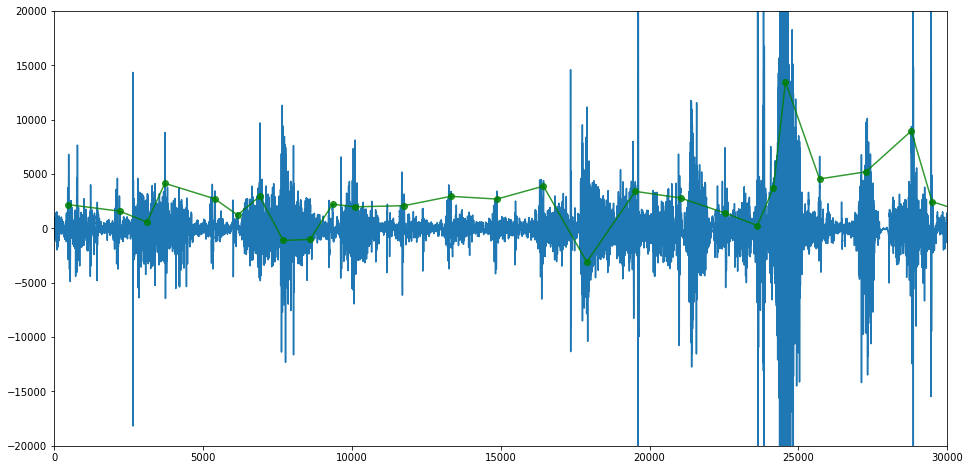

In [237]:
check_ith(25)

46778 1 4000
MV 46778_MV.hea 46778_MV.wav 46778_MV.tsv
#Age: Adolescent
#Sex: Female
#Height: 150.0
#Weight: 54.7
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: Early-diastolic
#Diastolic murmur shape: Decrescendo
#Diastolic murmur grading: I/IV
#Diastolic murmur pitch: Low
#Diastolic murmur quality: Blowing
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49754

MV 46778_MV.wav
[   69   522   887  1188  1952  2430  2749  3068  3881  4070  5462  6793
  8202  9525 10925 12250 12575 13547 13968 14365 14854 15894 16117 17437
 18732 20027 21286 22560 23807 24011 26420 27704 29209 30310 30826 31550
 32056 32834 33686 34093 34543 34950 35520 35975]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  5

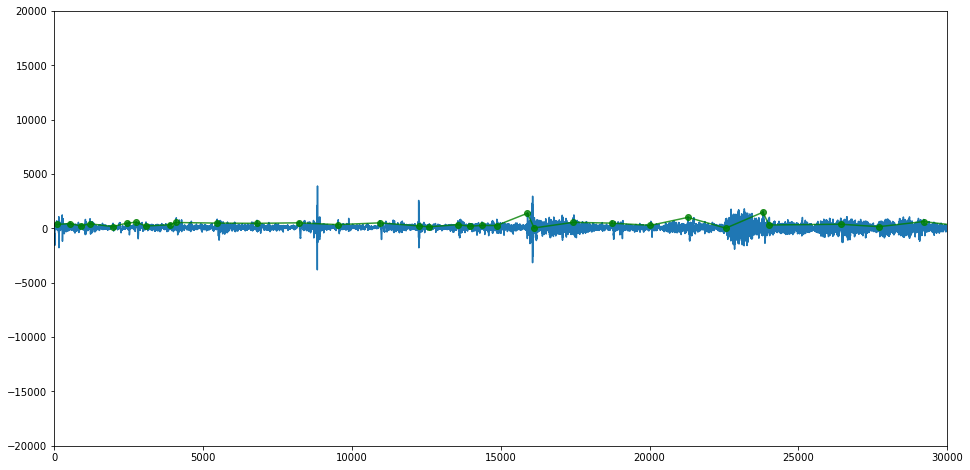

In [238]:
check_ith(26)

47002 2 4000
AV 47002_AV.hea 47002_AV.wav 47002_AV.tsv
MV 47002_MV.hea 47002_MV.wav 47002_MV.tsv
#Age: Child
#Sex: Female
#Height: 74.0
#Weight: 8.5
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: nan

AV 47002_AV.wav
[  270   598  1136  2023  2746  3124  3904  4600  5142  5555  6098  6883
  7578  7935  8144  8511  9015  9514  9868 10482 10844 11262 11664 12241
 12573 12878 13468 14128 14451 15413 16314 17280 18289 19155 20069 20564
 21063 21508 22073 22935 23927 24017 24985 25900 26952 27856 28674 29764
 30752 31672 32627 33524 34492 35384 36355 37216 38128 39032 39921 40816
 41692 4

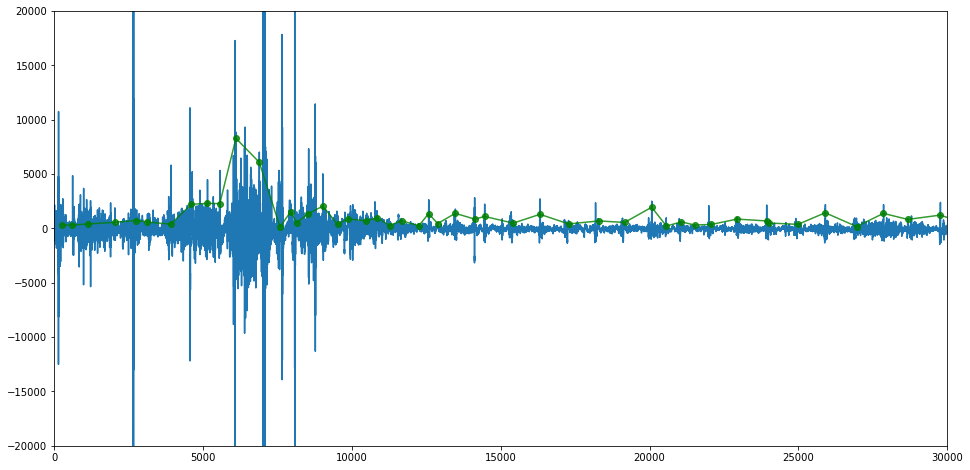

MV 47002_MV.wav
[   899   1844   2584   4332   5419   5962   6501   7769   9547  10596
  10985  11287  12266  13072  14986  16896  17851  18746  19155  19661
  20535  21453  22273  23199  24069  25009  25715  26662  27436  28380
  29157  30110  30856  31816  32559  33521  34342  35326  36156  37136
  37970  38931  39740  40717  41495  42474  43283  44270  45126  46120
  46934  47965  48769  49402  49819  50450  51906  52225  53298  54013
  54991  55832  56065  56782  57609  57968  58573  59056  59423  60393
  61087  62045  62801  63766  64571  65430  66183  67122  67872  68092
  68815  69626  70590  71426  72388  73196  74156  74955  75891  76672
  77618  78382  79344  79823  80122  81091  81892  82846  83648  84583
  85359  86319  87079  88046  88881  89869  90730  91712  92574  93533
  94380  95345  95838  96154  97137  97623  97957  98947  99791 100770
 101588 102539 103031 103346 104323 105093 106064 106941 108024 108645
 110073 110390 111359 111827 112127 113569 113921 114812 1156

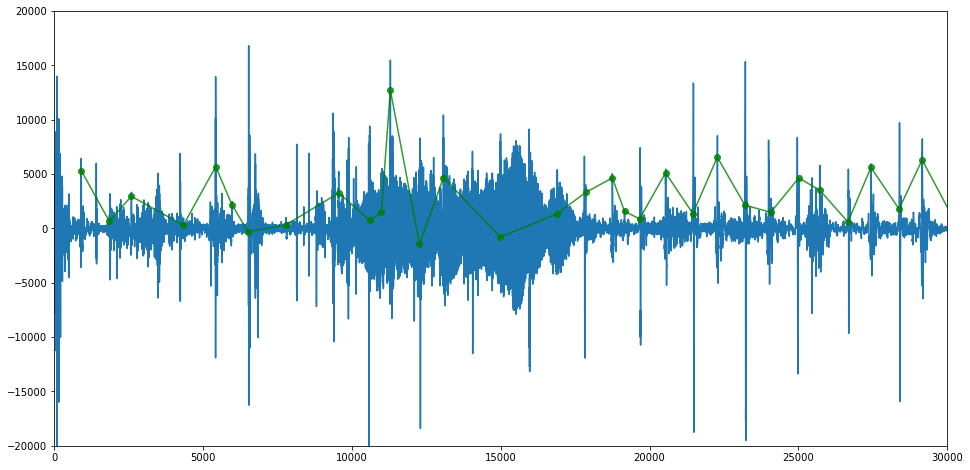

In [239]:
check_ith(27)

49558 2 4000
AV 49558_AV.hea 49558_AV.wav 49558_AV.tsv
MV 49558_MV.hea 49558_MV.wav 49558_MV.tsv
#Age: Child
#Sex: Male
#Height: 79.0
#Weight: 10.5
#Pregnancy status: False
#Murmur: Unknown
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: 69060

AV 49558_AV.wav
[  1943   2371   3371   4923   8126   9057   9531   9874  10831  11919
  12176  12509  13117  13808  14182  14554  15136  15678  16436  17620
  18380  19631  20380  21661  22485  22877  23283  23733  24396  25597
  26370  27607  28459  30395  31565  32357  33545  34335  36415  37149
  37586  37923  38351  38840  39499  39873  40166  40479  41474  42299
  43421  44213  45371  46176  511

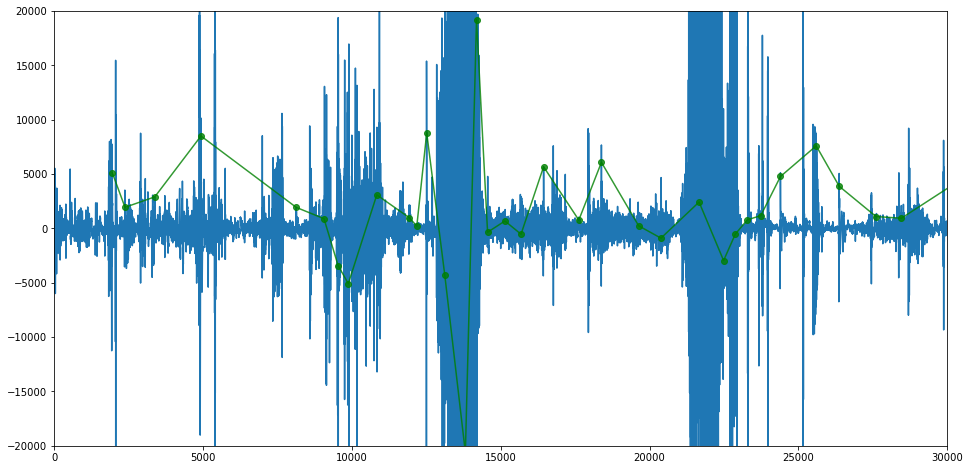

MV 49558_MV.wav
[   704   2662   3639   4724   5696   6823   7801   9020   9506  10205
  11174  12169  12737  13388  14481  15288  15749  16582  17198  17729
  18704  19063  19681  20960  22210  23212  23783  24618  25449  26644
  27821  28888  29723  30414  30926  31762  32345  33065  33970  35217
  35549  36055  36814  37291  38127  38731  39352  40344  41700  42315
  42688  43921  45098  46587  47457  48265  48595  49588  50843  51337
  51666  52464  53732  54892  55846  56061  57010  57972  58742  59184
  60247  60681  61059  63048  63974  64069  65188  67200  68095  68467
  68925  69291  69614  70073  70693  71126  71491  71914  73074  75012
  75883  76911  77240  77673  77995  78855  79742  80315  80650  81692
  82753  83629  84565  85129  85509  86656  87532  88021  88579  89344
  90053  90492  91341  91924  92282  93219  93809  94329  95211  95872
  96287  97070  98310  99172 100308 101088 101842 102307 102661 103085
 105403 106336 107273 109349 113397 115493 116146 116671 1174

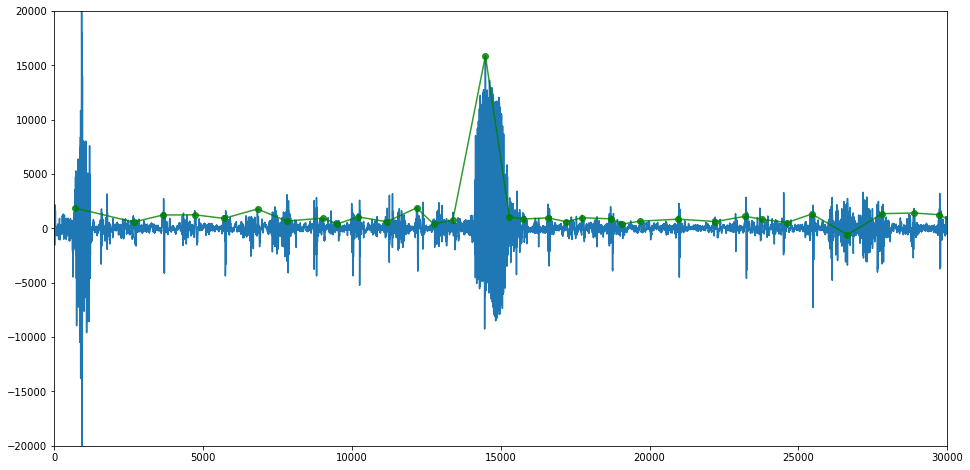

In [240]:
check_ith(28)

49561 4 4000
AV 49561_AV.hea 49561_AV.wav 49561_AV.tsv
PV 49561_PV.hea 49561_PV.wav 49561_PV.tsv
TV 49561_TV.hea 49561_TV.wav 49561_TV.tsv
MV 49561_MV.hea 49561_MV.wav 49561_MV.tsv
#Age: Child
#Sex: Female
#Height: 124.0
#Weight: 25.1
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

AV 49561_AV.wav
[   471   3977   4111   4528   4851   5421   6015   6337   6678   7065
   7406   7749   9220  10428  10897  11573  14270  15701  16603  18513
  21609  22119  22832  23870  24033  25366  26578  28550  29780  31679
  33074  35518  36883  39245  40461  42433  43673  46089  47446  49455
  50653  52130  5335

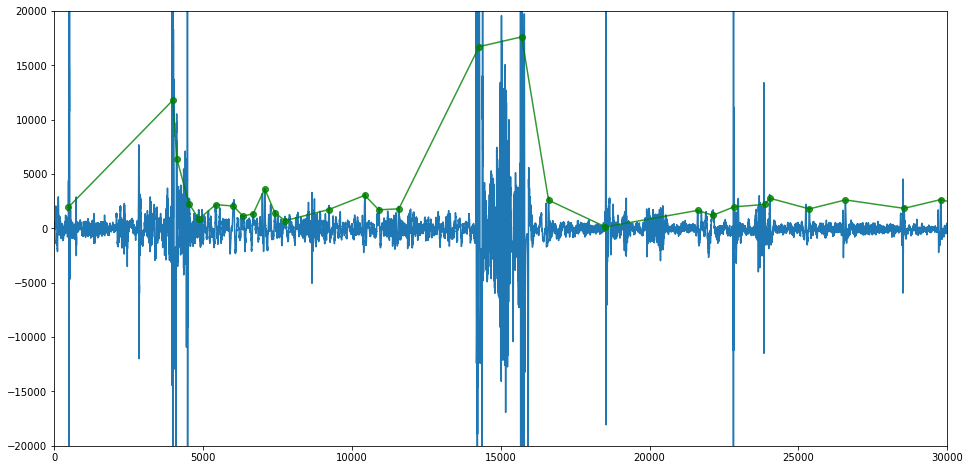

PV 49561_PV.wav
[   366    870   2108   4248   5527   8172   9398  11347  12642  15277
  16546  19118  20362  21986  23238  24624  25886  28548  29854  32704
  33991  35686  36953  39318  40607  43226  44497  46523  47782  50154
  51446  54061  55312  56775  57963  59673  60955  63596  64851  67016
  68245  70074  71357  73869  75134  77288  78702  80150  81331  82970
  84243  85579  86725  89263  90532  93348  94585  96838  98032  99589
 100831 103185 104414 106678 107884 108077 109401 110636 112038 113290
 113802 114245 114568 115809]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


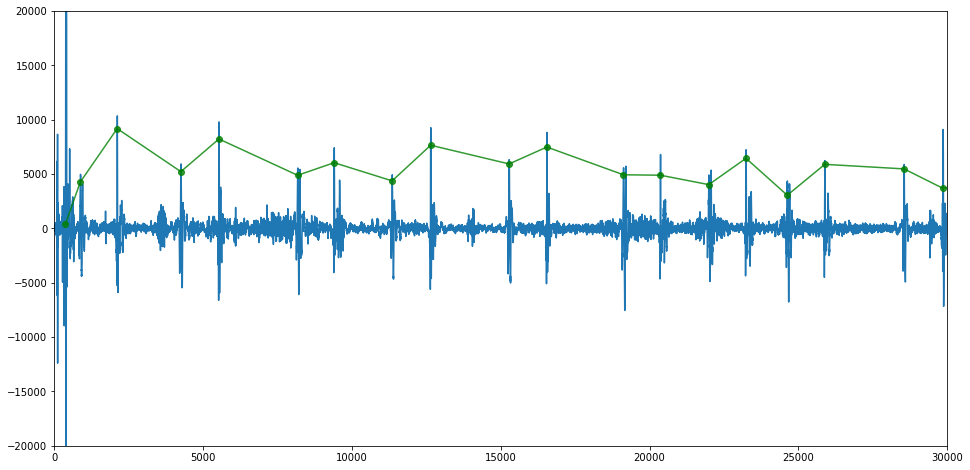

TV 49561_TV.wav
[   374    740   1648   4278   5524   7725   8907  10334  11586  13570
  14850  17557  18819  21297  22511  24228  25467  27729  29009  31468
  32702  34292  35518  37165  38432  40943  42180  44075  45288  47595
  48851  51469  52601  53986  55214  57659  60921  63477  64689  66306
  67630  70164  73441  74786  75768  77285  78543  80281  81527  83310
  84571  87195  90578  91857  94165  95393  97844  99159 101411 102679
 104928 106162 108561 109878 111948 112039 113230 114771 116016 118369
 119192 119632]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


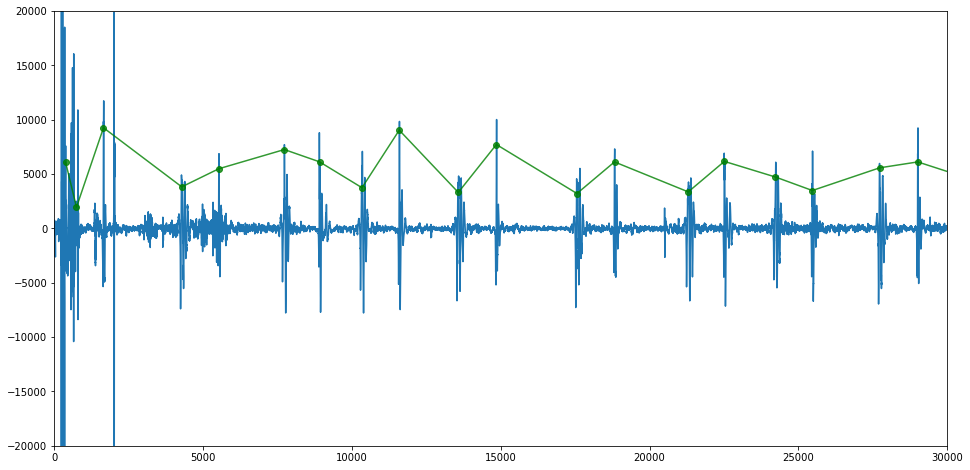

MV 49561_MV.wav
[   212   1314   4351   5557   7058   8223  10740  14401  15618  17270
  18493  19175  19804  22731  26647  28105  30299  31436  33073  34297
  36096  40073  41234  43737  44848  46611  47761  49131  52975  56731
  60143  61363  63126  64363  66394  70191  71403  73221  73954  74426
  75851  77079  78931  80200  82801  83112  84043  86337  87548  87931
  89312  90585  92926  96784  97093  98021  98613  99945 100071 101291
 102829 104113 105639 105979 106982 107558 108352 109581 110830 112168
 112708 113221 113572 114467 116252 116553 117289 118449 119131 119615
 119989 120065 120381 121220 122532 123692 124897 125344 126460]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  

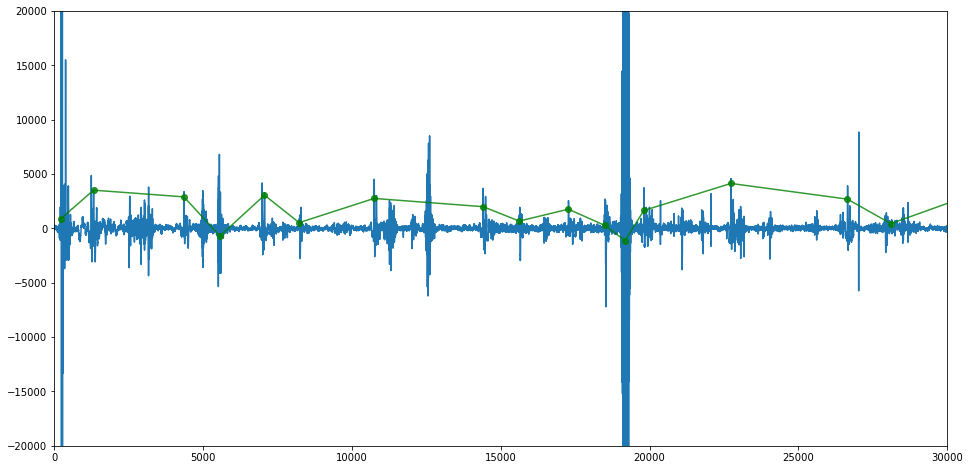

In [241]:
check_ith(29)

49562 4 4000
AV 49562_AV.hea 49562_AV.wav 49562_AV.tsv
PV 49562_PV.hea 49562_PV.wav 49562_PV.tsv
TV 49562_TV.hea 49562_TV.wav 49562_TV.tsv
MV 49562_MV.hea 49562_MV.wav 49562_MV.tsv
#Age: Child
#Sex: Male
#Height: 122.0
#Weight: 24.2
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

AV 49562_AV.wav
[   778   2337   3345   4611   5692   7190   8202   9878  10877  12147
  13199  14770  17309  18292  19577  20600  22041  23033  24457  25432
  26686  27711  28971  30033  31520  32620  34104  35077  36363  38675
  41197  43776  44753  46055  47095  48456  49386  50643  51637  52928
  55368  56429  58008 

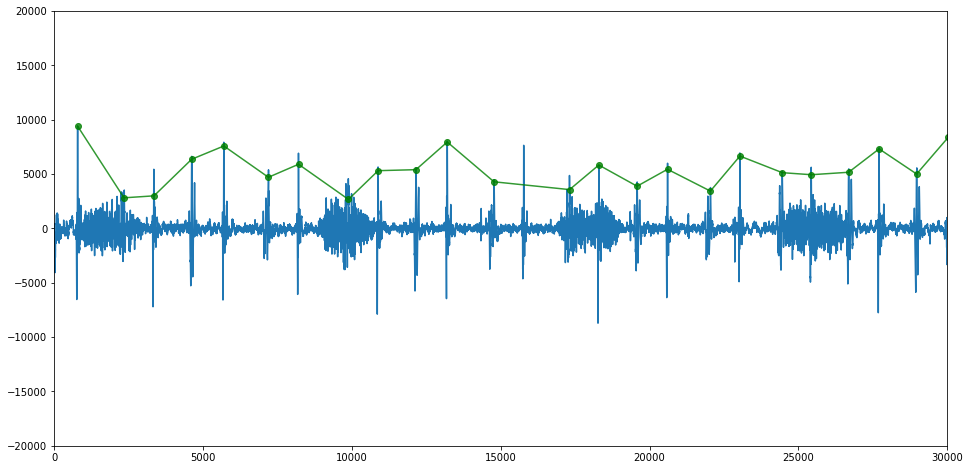

PV 49562_PV.wav
[   527   2080   3207   4720   5808   7063   8138   9540  10646  12065
  13151  14414  15438  16720  17810  19046  20123  21409  22517  23963
  25063  26500  27568  28859  29923  31363  32472  34296  35410  36973
  38054  39391  40457  42054  43184  44780  45888  47286  48360  49876
  51014  52473  53578  54880  55968  57376  58507  60206  61327  62674
  63734  65091  66223  67564  68651  69892  70969  72304  73393  74898
  75989  77044  77346  78397  79777  80869  82303  83385  84767  85814
  87105  88179  89609  90711  92168  93246  94484  95557  96838  97940
  99228 100305 101570 102624 103967 105059 106461 107523 108860 109918
 111343 112454 113898 114516 114976]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  32

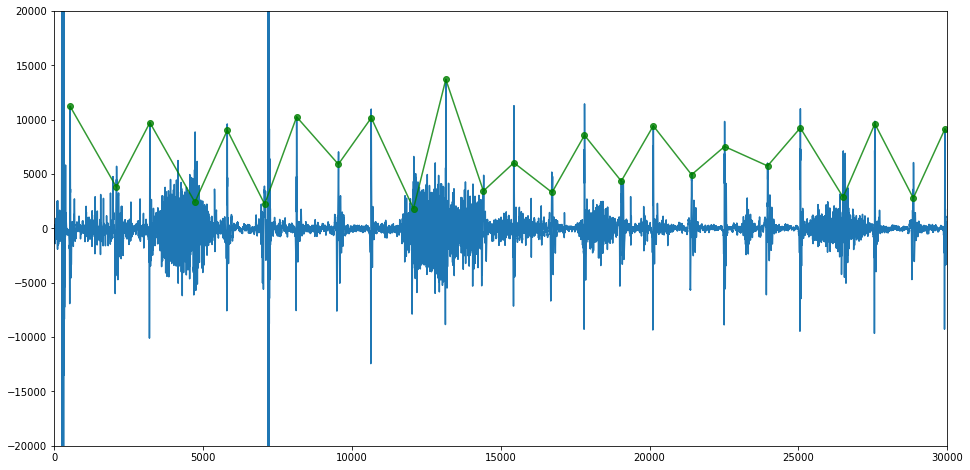

TV 49562_TV.wav
[   366   7707   8622  10139  14786  17036  18029  19253  19724  20433
  21660  22493  22800  23701  25886  28124  30378  32513  34824  37192
  39472  41930  44367  46209  46635  47695  49038  51367  53557  55956
  58353  60704  61703  62974  65310  67654  68412  69904  70879  71982
  72150  74472  76831  79036  81303  82314  83644  86184  88582  89181
  90868  93119  95387  97668 102279 104748 106889 109226 111695 112636
 113938 114908 115975]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


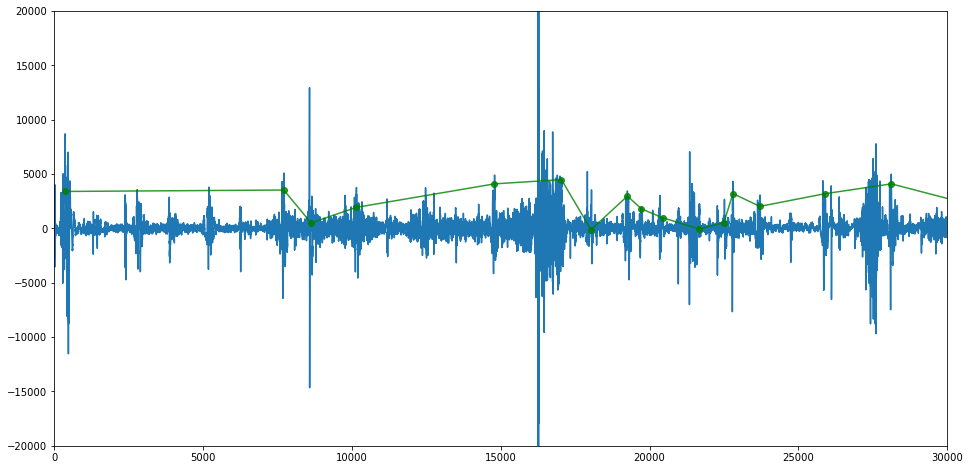

MV 49562_MV.wav
[    20    347   1707   2915   4312   5504   6879   7924   9157  10357
  11517  12695  13773  14917  16091  17352  18384  19561  20688  21852
  23269  24438  25768  26913  28131  29313  30808  32013  33489  34674
  35913  37087  38453  39668  41030  42229  43459  44622  45810  47000
  48316  49526  50937  52135  53337  54500  55687  58039  59224  60420
  61576  62718  63898  65092  66280  67575  68753  70036  71113  72397
  73221  73580  74815  77469  77813  78640  81029  82350  83560  85061
  86262  87662  88831  90120  91321  92983  94195  95972  96110  97077
  98376  99572 101069 102287 103816 104058 104501 105099 105737 106289
 106600 107021 107465 107796 108880 110018 111422 112629 113115 113973
 115150]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2

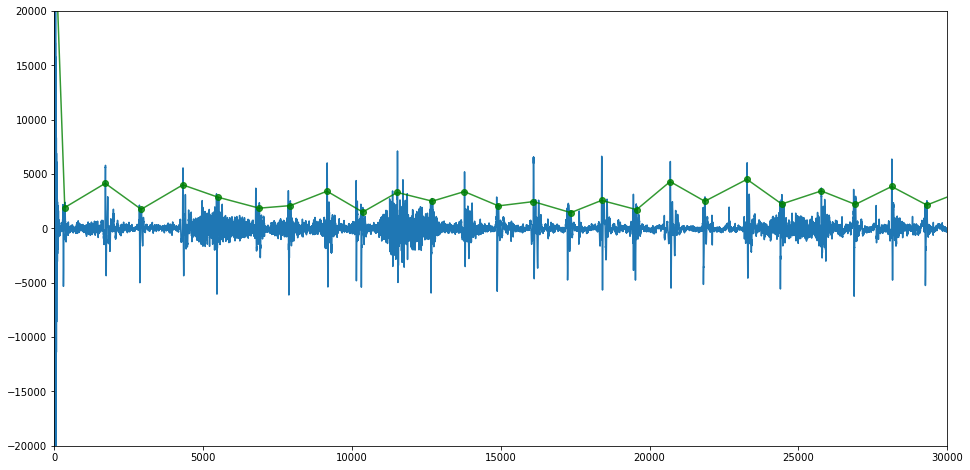

In [242]:
check_ith(30)

49568 4 4000
AV 49568_AV.hea 49568_AV.wav 49568_AV.tsv
PV 49568_PV.hea 49568_PV.wav 49568_PV.tsv
TV 49568_TV.hea 49568_TV.wav 49568_TV.tsv
MV 49568_MV.hea 49568_MV.wav 49568_MV.tsv
#Age: Child
#Sex: Male
#Height: 141.0
#Weight: 37.5
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

AV 49568_AV.wav
[   148   6544   8223   9468  10500  13746  15342  16285  17109  17497
  17871  18261  19425  19936  21803  23644  25412  26177  28198  28706
  29181  29547  30906  31978  32064  33443  34653  35486  36408  37505
  39055  39442  40538  41641  43962  44064  44672  45120  45718  46078
  46406  46871  47516  4

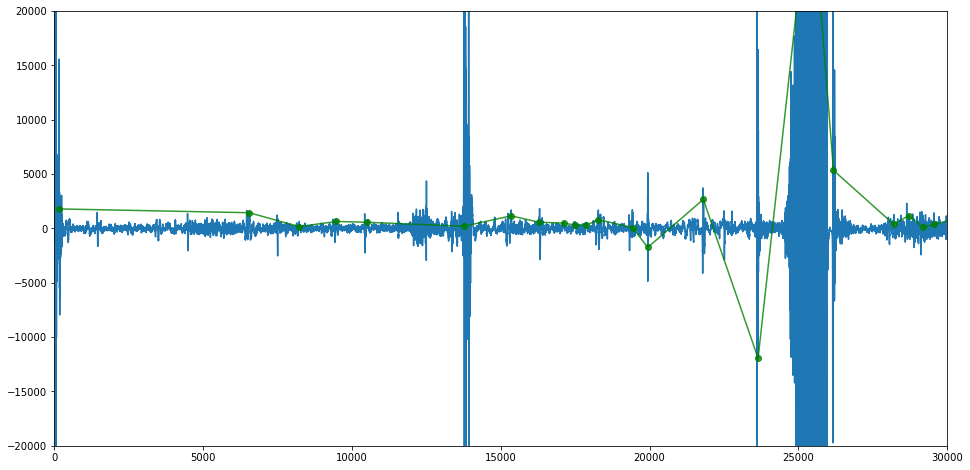

PV 49568_PV.wav
[   111   2663   4570   5201   6284   7752   8879  10350  11482  13112
  14232  16355  17452  19769  20498  20871  22888  23980  25515  26574
  29236  30922  32110  34595  35797  37897  39063  40934  42142  44358
  45565  47494  48661  50319  51500  53391  54581  56234  57428  59213
  60421  62756  63982  64099  65731  66916  68475  69673  72540  73738
  76458  77658  79764  80943  82859  84048  85997  87165  88822  89956
  91429  92586  94134  95291  97218  98364 101127 102764 103871 105918
 107019 108719 109837 111625]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


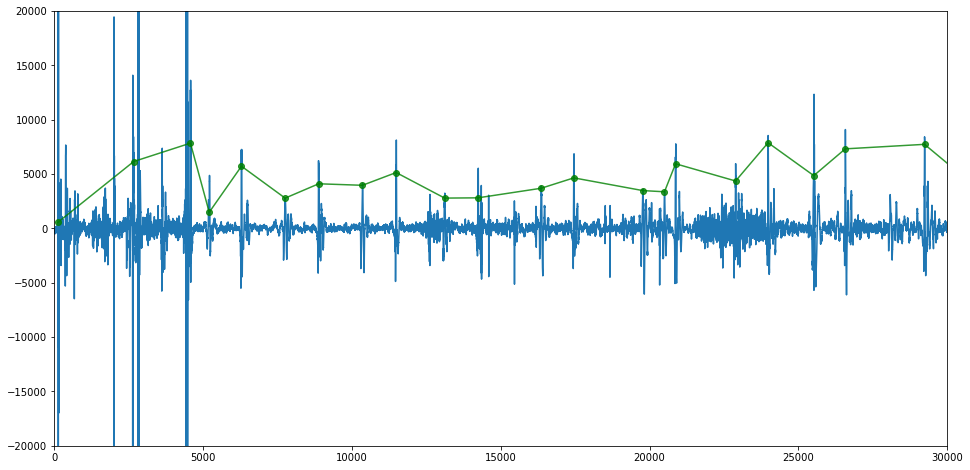

TV 49568_TV.wav
[   403   7539   8612   9737  11194  12389  14053  15237  17161  18339
  20267  21310  23390  24573  26398  27570  29077  30194  31643  32840
  33780  35013  36236  38517  38984  39916  40141  41705  42375  43029
  44522  44951  45390  45727  46360  47051  47654  48661  50539  51730
  53351  54533  55961  56006  57213  58877  60020  62128  62511  63518
  65392  66576  68242  69507  71257  72442  73867  75061  76516  77737
  80156  80534  81569  84150  85405  87046  88325  89733  90049  91017
  91368  92901  94136  96624  97876  98506  98899 100407 100753 101676
 103615 103941 104107 105137 106700 107904 109479 110693 112244 112639
 113642 115474 116653 118192 119399 120958 121352 122370 124481 124871
 125889 127019 127856]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  9

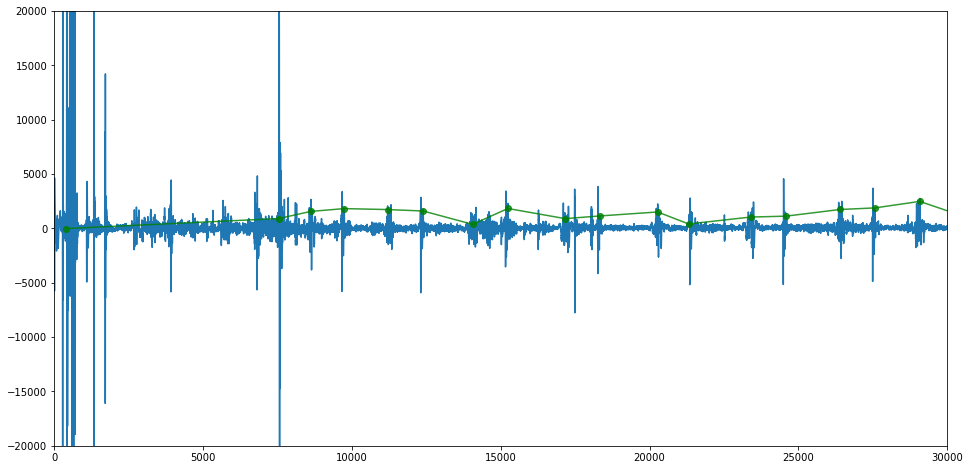

MV 49568_MV.wav
[   214   4277   6333   9176  10454  11467  13237  15222  16536  18503
  19328  19755  21749  23016  25014  26191  27417  27898  28127  29210
  30184  30995  31789  32251  33120  33644  33993  34540  35762  36086
  37800  38470  38971  39540  40575  41079  43451  43805  44222  44730
  49736  50949  52963  53312  54181  54501  55171  56401  57683  58493
  59937  60678  61197  63288  64459  66134  67280  67749  68804  70078
  71739  73024  74807  75947  77413  78544  79934  81145  82608  83826
  85505  88822  90027  91735  92960  94971  96190  98245  99444 101023
 102224 103764 104992 105688 106851 110214 111509 113049 114265 115748
 116929 118490 119799]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  6

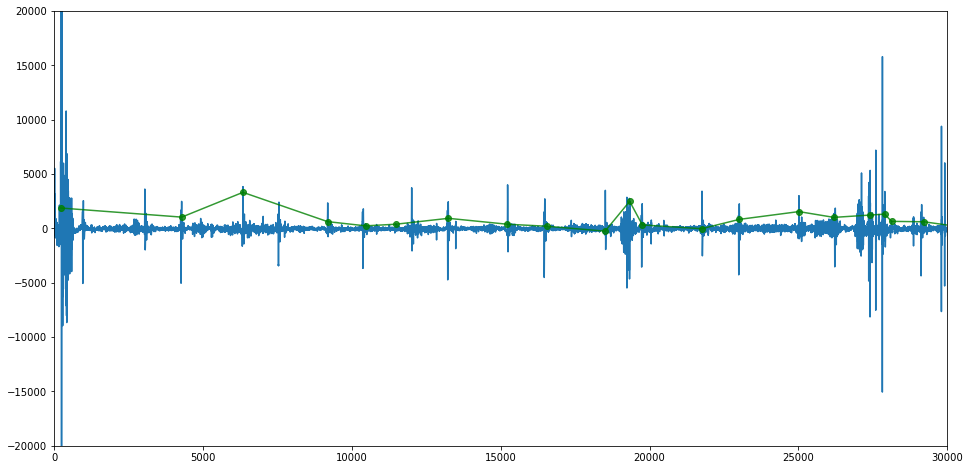

In [243]:
check_ith(31)

49572 3 4000
PV 49572_PV.hea 49572_PV.wav 49572_PV.tsv
TV 49572_TV.hea 49572_TV.wav 49572_TV.tsv
MV 49572_MV.hea 49572_MV.wav 49572_MV.tsv
#Age: Child
#Sex: Female
#Height: 95.0
#Weight: 15.4
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV+PV
#Most audible location: MV
#Systolic murmur timing: Early-systolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

PV 49572_PV.wav
[    73    968   2009   3010   4035   5022   5945   6882   7832   8799
   9790  10789  11760  12747  13752  14732  15749  16724  17761  18732
  19734  20676  21594  22545  23535  24527  25537  26532  27622  28598
  29543  30499  31537  32545  33552  34553  35731  36638  37619  38564
  39534  40518  41623  42550  43594  44591 

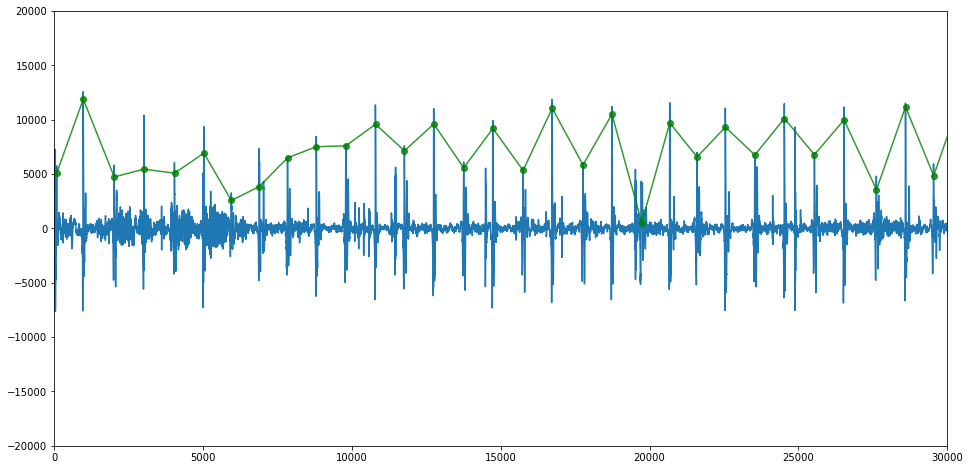

TV 49572_TV.wav
[   412   1409   2161   2529   3367   4416   5438   6465   7473   9557
  10577  11511  13595  13937  14607  15631  16731  17753  19037  19988
  21075  22039  24164  25235  26261  27411  28432  29497  30445  31500
  32469  33427  34451  35540  36576  37700  38729  39934  40896  42905
  44056  45098  46169  47181  48334  49284  50257  51203  52182  53351
  54225  55252  57457  58728  59690  60743  61716  62795  63831  64907
  65939  66300  67104  68124  69162  70105  72147  73253  74287  75387
  76414  77598  78558  80546  81633  82670  83983  84184  84809  86002
  87021  88082  89032  91050  92049  93076  94058  95073  97076  98016
  98944  99255  99898 100324 100881 101408 101799 102807 103969 104127
 104794 105850 106681 107250 107627]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 111

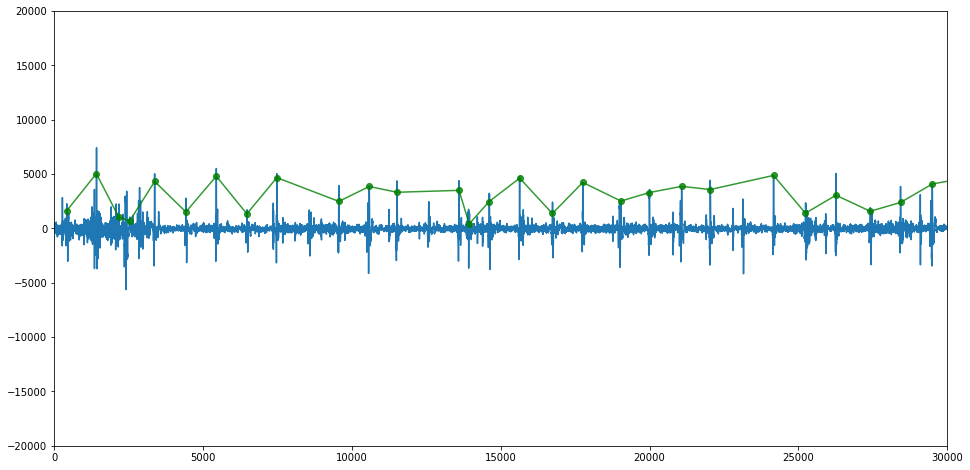

MV 49572_MV.wav
[     4    928   1965   2945   3854   4040   4869   5912   6867   8880
  10961  12842  13760  14670  15685  16631  18607  20584  21597  22504
  23403  24348  26281  27363  28285  29379  30485  31424  32444  33043
  33367  34572  35624  36649  37307  37627  38052  38915  39294  39949
  40062  41133  42081  43050  44192  45206  46260  47200  49198  50127
  51081  52198  53161  54280  55421  57724  59766  60709  61717  62862
  63808  65867  66988  67939  69068  70075  71156  71939  73025  73792
  74891  75745  76838  77800  79957  80172  80907  81835  82860  83977
  85039  86073  87197  88436  89526  90487  91436  92449  92756  93594
  94654  96834  97973  99182 100150 101192 102162 103122 104251 105250
 106374 107461 108427 109468 110440 111523 112650 113670 114796 115653]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542

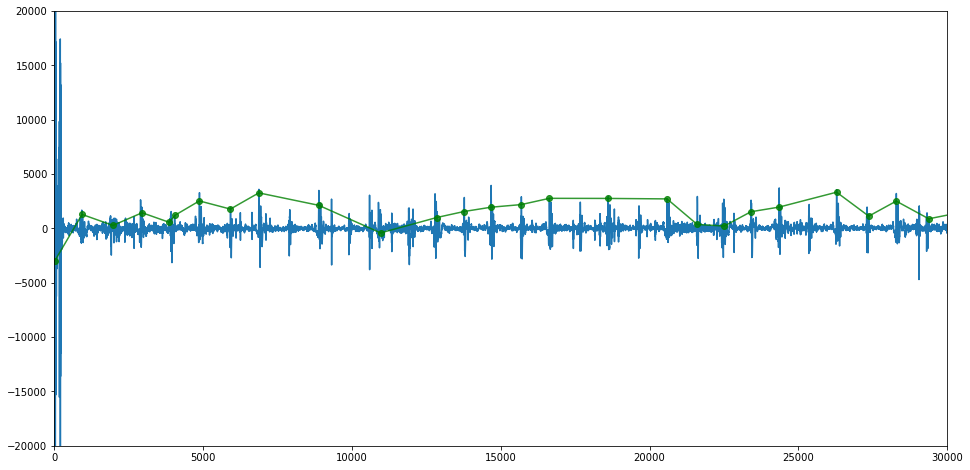

In [244]:
check_ith(32)

49574 4 4000
AV 49574_AV.hea 49574_AV.wav 49574_AV.tsv
PV 49574_PV.hea 49574_PV.wav 49574_PV.tsv
TV 49574_TV.hea 49574_TV.wav 49574_TV.tsv
MV 49574_MV.hea 49574_MV.wav 49574_MV.tsv
#Age: Child
#Sex: Male
#Height: 129.0
#Weight: 20.0
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV+PV+TV
#Most audible location: TV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: III/VI
#Systolic murmur pitch: High
#Systolic murmur quality: Harsh
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: 69068

AV 49574_AV.wav
[   17   668  1424  2908  3735  4051  5039  6178  7172  8186  9374 10437
 11640 12037 12405 12710 13292 13879 14330 15032 15470 15922 16013 16955
 18122 19039 20221 21186 22370 23414 24584 25696 26772 27793 28874 29780
 30965 31866 33054 33992 35167 36039 37300 38280 39358 402

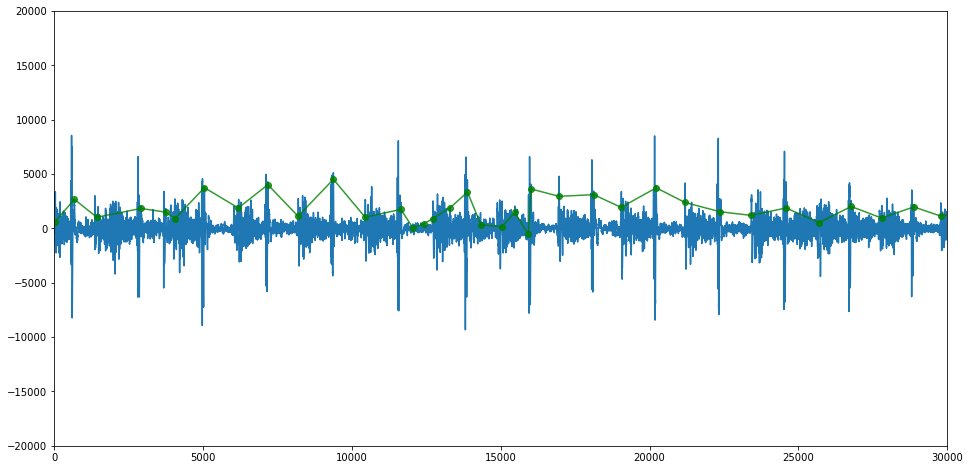

PV 49574_PV.wav
[   18  4604  5554  6681  7726  8875 10106 11065 12172 12725 13238 14400
 15069 15443 16400 17558 18503 19647 20640 21784 22826 23339 23904 24982
 26047 27100 28244 29188 30326 31340 32490 33536 34685 35740 36894 37993
 38970 40106 41286 42072 43176 44167 45304 46275 47030 47417 48340 50358
 52327 53379 54317 55446 56369 57445 58464 59205 59764]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


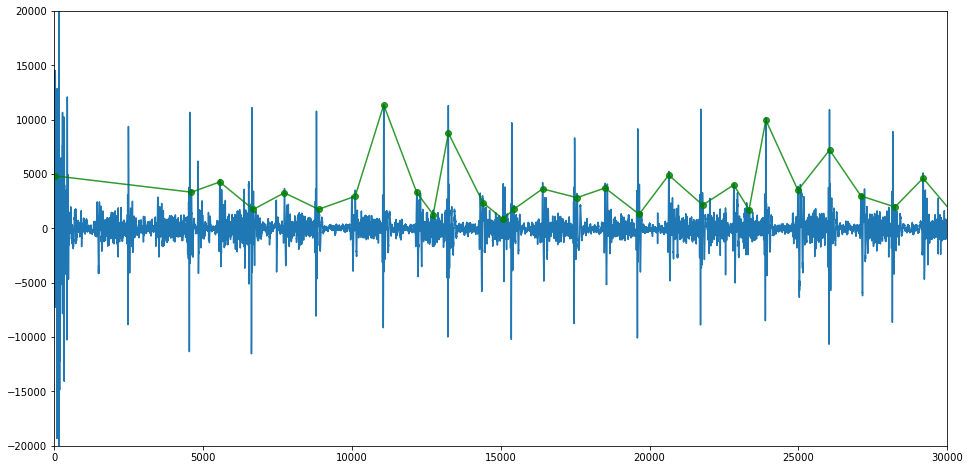

TV 49574_TV.wav
[   69   645  1082  2194  4455  5582  6674  7732  9020  9954 11158 12106
 13222 14355 15508 16643 17856 18921 20252 20626 21306 22522 23470 24586
 25762 26749 27883 28941 31142 33363 34407 35493 37624 42256 43232 44681
 45758 46973 47945 49082 50265 51374 52529 53857 54453 54943 56103 58338
 59406 60539 61693 62802 65076 67241 68285 69334 71460 73647 75862 76791
 78038 80197 82428 84848 86010 87050 89235 90287 91381]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


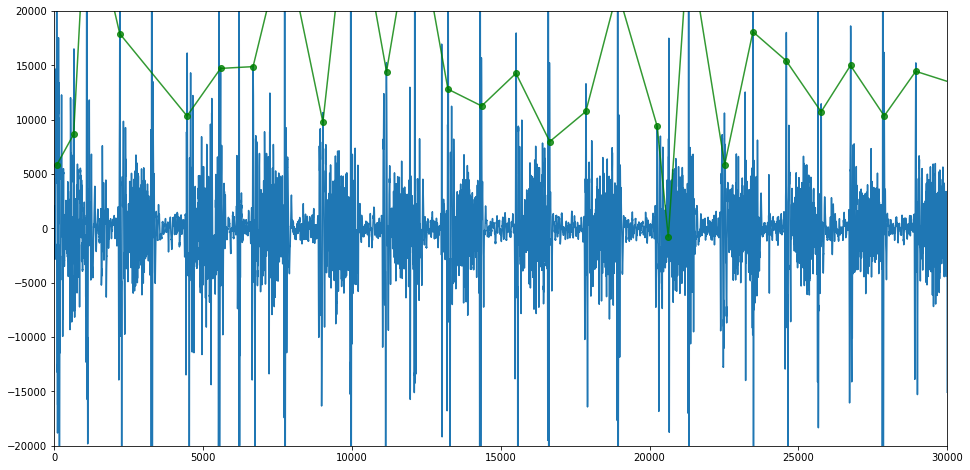

MV 49574_MV.wav
[  106  3359  4498  5517  7668  8789  9907 11883 12118 13017 14025 14491
 15080 15834 16312 18704 21081 23260 24200 25317 26475 27534 29888 32223
 33368 34482 35410 36585 37526 38612 39931 40805 43074 44221 45351 46507
 47447 49452 51603 53833 56020 58256 59170 60316 61349 62256 64367 66540
 66915 67283 67675 68734 70786 72726 74823 76797 77123 77733 78130 79203
 83081 83491 83887 84251 85269 87522 88657 89362 89778 90913 91708]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


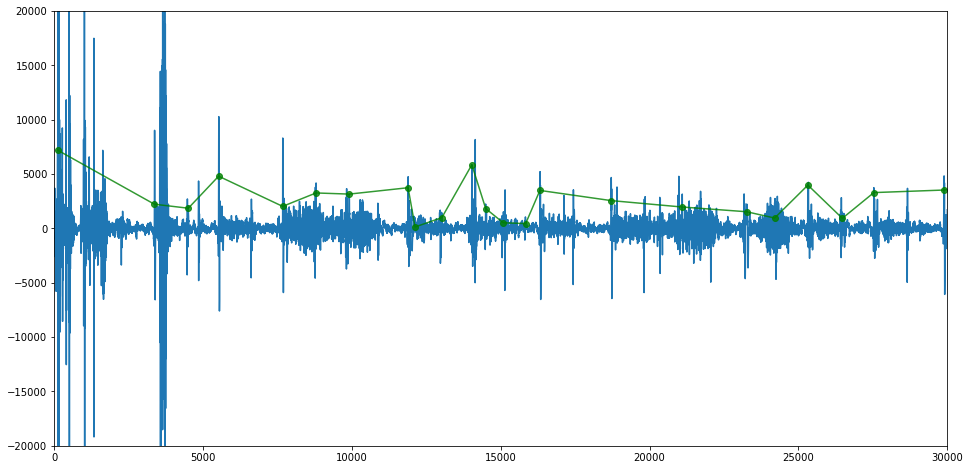

In [245]:
check_ith(33)

49577 4 4000
AV 49577_AV.hea 49577_AV.wav 49577_AV.tsv
PV 49577_PV.hea 49577_PV.wav 49577_PV.tsv
TV 49577_TV.hea 49577_TV.wav 49577_TV.tsv
MV 49577_MV.hea 49577_MV.wav 49577_MV.tsv
#Age: Child
#Sex: Female
#Height: 130.0
#Weight: 36.7
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

AV 49577_AV.wav
[   247   4366   5262   6576   7483   8745   9780  10999  11922  12040
  13381  14301  15798  16722  18252  19191  20653  21645  22945  23894
  24013  25160  25505  25959  26459  26856  27932  28025  28979  30539
  31502  32934  33989  35349  36435  37995  38974  40636  41622  42701
  43482  44395  46025 

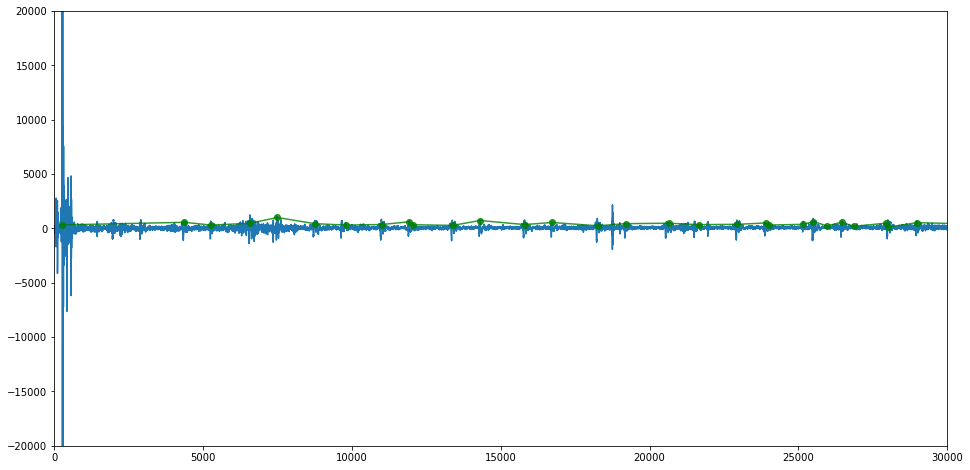

PV 49577_PV.wav
[   497   2064   2981   4253   5173   6333   7277   8468  10767  13112
  16247  17520  18481  19568  20510  21629  23811  24516  25992  26922
  28069  29017  30184  32394  34831  36976  37921  39134  41305  43478
  44419  45718  46668  47890  50088  52293  54543  55484  56790  57751
  59099  60079  61543  62521  64011  64983  66406  67375  68637  73287
  75475  76421  77557  78506  79756  80802  82032  83704  84298  86454
  87380  88482  89409  90497  92579  94720  96886  97804  98933  99852
 100994 102963 105072 107175 108092 109229 110163 111342 113656 116092
 117036 118487 119360]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


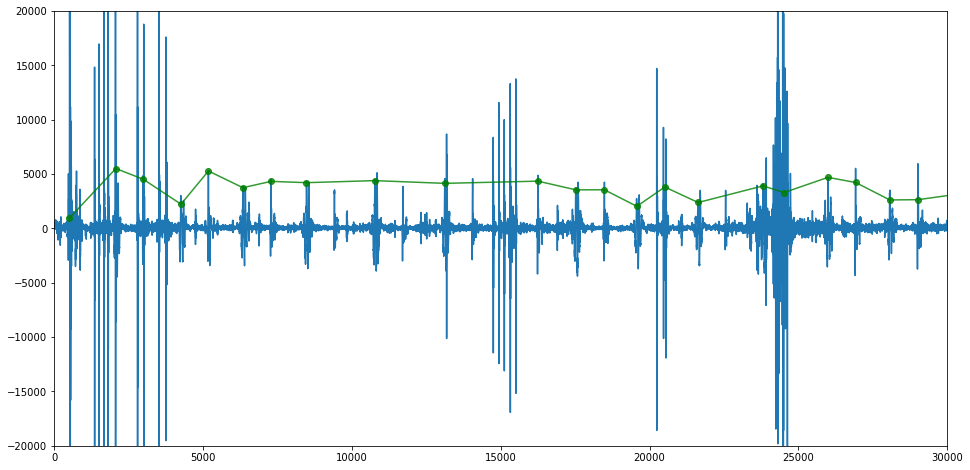

TV 49577_TV.wav
[     5    792   4433   6559   8873  10638  11018  13167  15228  17260
  19480  21787  22681  23918  26401  28854  31575  32603  34282  34921
  35231  36777  37373  39266  41181  41715  44113  46396  48661  51102
  53520  55784  58103  60427  61236  64807  66983  69240  71568  72665
  73355  73752  75985  78217  80515  82875  85113  87329  89596  91948
  92137  93032  94321  95236  96554  98861 101257 103525 105899 108359
 110791 113151 115362 117610 119877 120536 120964 122128 124262 126366
 127445 128496 130731 133184 135656 138055 140513 143048 145531 147916]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


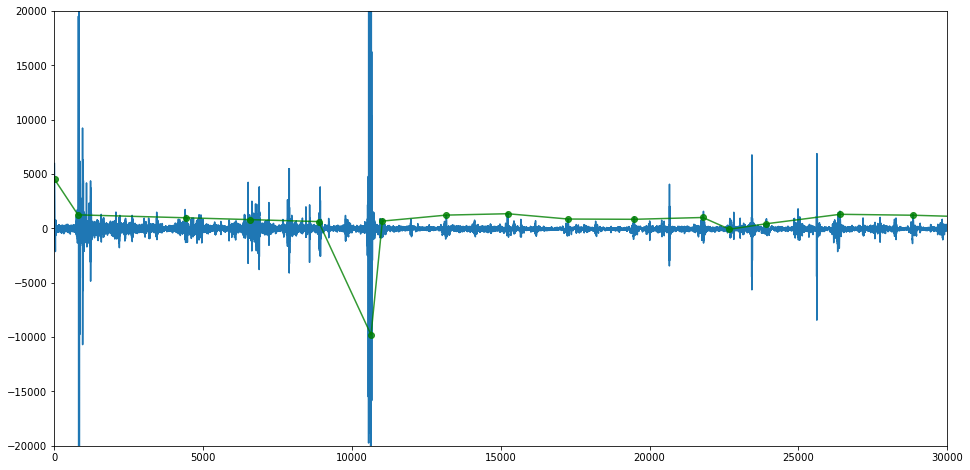

MV 49577_MV.wav
[   371   2280   4016   4923   5899   6927   9033  11248  13569  15660
  16645  17781  18977  20106  22538  24472  24824  26998  29248  31597
  34058  36433  38810  41159  43566  46010  48362  50648  52951  55318
  57533  58529  59617  61736  63931  64930  66246  66895  68565  73082
  75381  77572  78663  79744  81996  84293  86502  87575  88495  90489
  91469  92539  94641  95805  96920  99225 100302 101397 102480 103572
 104757 105786 108050 110269 111345 112409 113485 113875 114442 115540
 116446 116763 117160 117521 118460 118764 119620 120483 121541 122458
 123518 123975 124413 125479 126427 128521 130852 134753]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 20

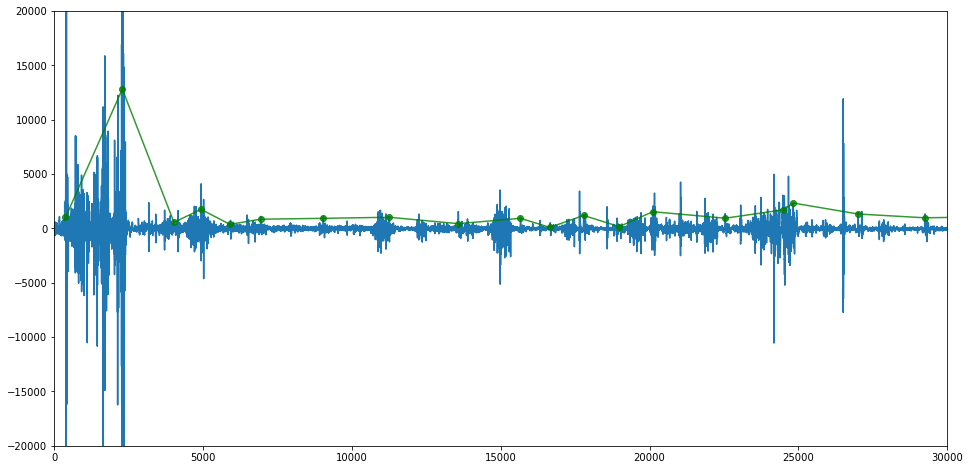

In [246]:
check_ith(34)

49585 4 4000
AV 49585_AV.hea 49585_AV.wav 49585_AV.tsv
PV 49585_PV.hea 49585_PV.wav 49585_PV.tsv
TV 49585_TV.hea 49585_TV.wav 49585_TV.tsv
MV 49585_MV.hea 49585_MV.wav 49585_MV.tsv
#Age: Child
#Sex: Female
#Height: 114.0
#Weight: 16.5
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: nan

AV 49585_AV.wav
[   493   5347   6517   7958   8079   9232   9734  10595  11730  12910
  14051  15627  16764  19393  20538  22894  24078  26747  27896  29152
  30307  31424  32571  33801  34952  37814  38994  40052  41571  42723
  43036  43344  43908  44036  45200  46344  47504  48692  49978  51640
  52781  53659  5410

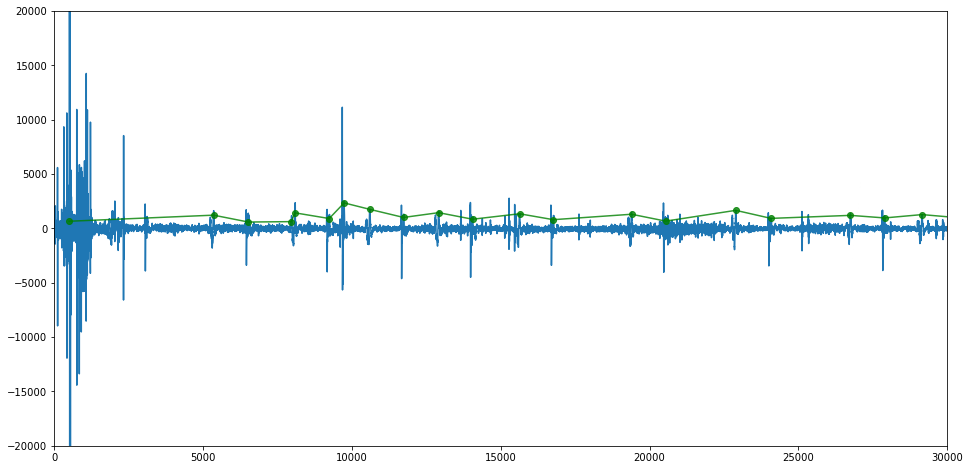

PV 49585_PV.wav
[   158   1256   2414   4614   5944   7496   8549  11259  12737  14021
  15441  16722  18148  19323  20488  21498  22845  23973  25115  26354
  27812  28969  31375  32532  34079  35119  36373  37685  38744  39928
  40992  42161  43784  44965  47695  48861  50754  51800  53116  54151
  55370  56590  57758  58890  60549  61680  63206  64327  66861  69236
  70406  71514  72581  73669  74688  75770  76786  77984  78951  80048
  81533  82748  84479  85599  86896  87985  88156  89197  90317  91467
  91968  92694  93891  95108  96662  97787 100717 103180 105769 108453
 111490 112996 114212 115346]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572  447  601  687  422  916 1203  765  394
 2005 1933]


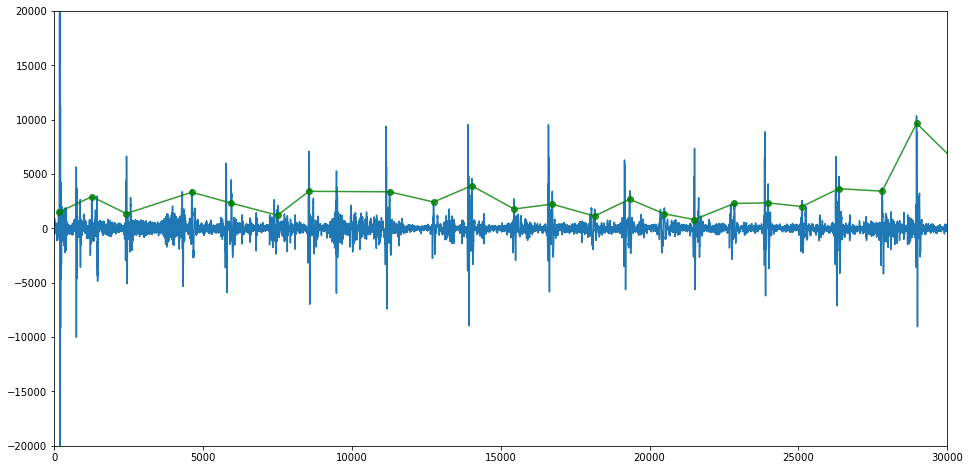

TV 49585_TV.wav
[   184    517   1220   1737   2850   4292   5285   6552   7676   8896
   9998  11288  12265  13458  14567  15800  16904  18182  19286  20619
  21599  22780  23883  25046  26155  27623  28730  30103  31207  32579
  33583  34852  35984  36091  37512  38645  40317  41445  42829  43970
  44098  45446  46575  48055  49176  50465  51597  52923  54051  55382
  56488  57745  58865  60264  61385  62800  63928  64113  65144  66389
  67562  70087  71200  72436  73563  74833  75961  77312  78426  79779
  80792  82002  83231  86149  88640  89697  91227  92506  95171  96246
  97827  99029 100364 101533 102760 103792 104950 106091 107259 109847
 112141 113380 114534 115677]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  965 1089 3911 2933 1060  383  407
  363  319  391  378  322  572 

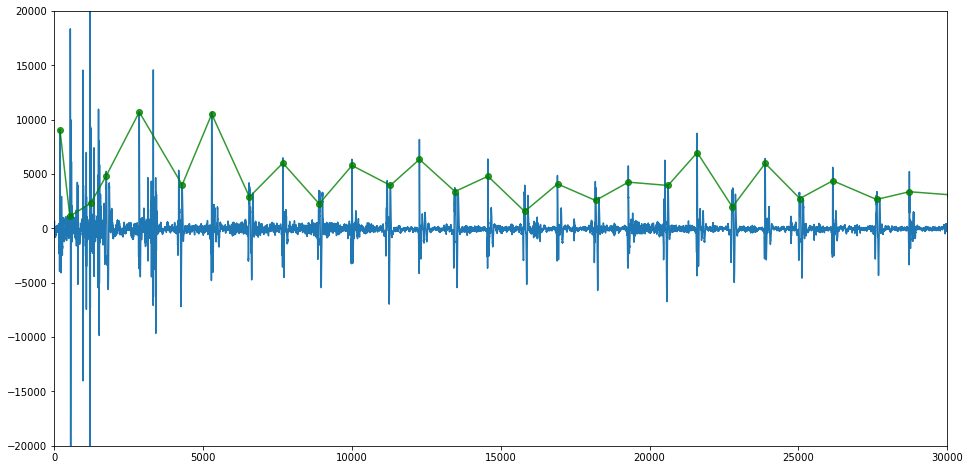

MV 49585_MV.wav
[   592   2404   3307   4672   5809   6972   8111   9336  10476  11984
  12449  13134  14699  15733  17104  18343  19956  20026  21195  23977
  24051  25434  26608  28199  29362  30837  31877  32054  33300  34471
  36099  37261  38929  39970  40140  41299  42527  44077  45240  46805
  47953  49391  50431  51815  52867  54377  55606  57692  58862  60293
  61342  62841  63569  63897  65154  65680  66322  67669  68906  70512
  71761  73680  74753  76036  77096  78816  80074  81594  82197  82833
  83877  84342  87809  88223  88526  89532  90773  92140  93352  94593
  95822  96523  97199  98423  99741 100950 102081 103293 104441 105650
 106901 108108 109397 110422 111489 112687 113796 114996 116214 116806
 117111 117413 118021 118614 118920 119498 119800 120037 121426 123917]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542

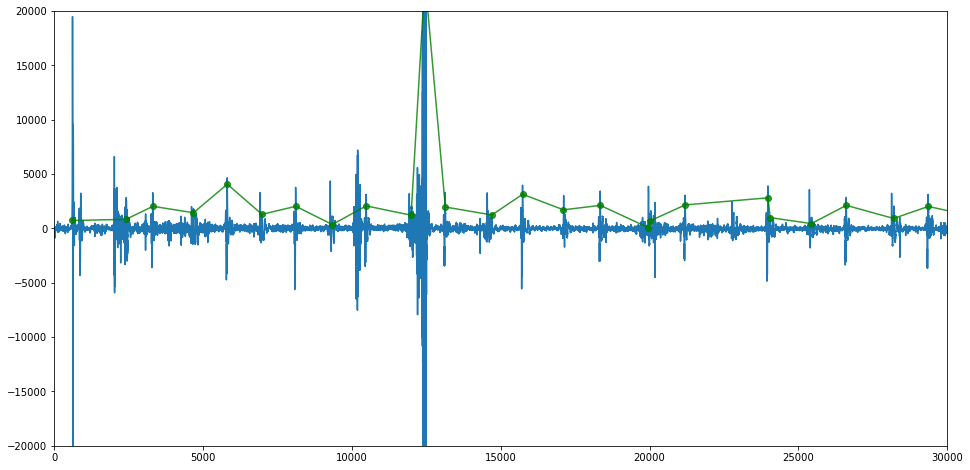

In [247]:
check_ith(35)

49595 2 4000
AV 49595_AV.hea 49595_AV.wav 49595_AV.tsv
MV 49595_MV.hea 49595_MV.wav 49595_MV.tsv
#Age: Child
#Sex: Female
#Height: 89.0
#Weight: 13.8
#Pregnancy status: False
#Murmur: Present
#Murmur locations: AV+MV
#Most audible location: AV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Diamond
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Medium
#Systolic murmur quality: Blowing
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Abnormal
#Campaign: CC2014
#Additional ID: 69079

AV 49595_AV.wav
[   667   4685   5884   6769   7947  10197  11023  12118  12982  14975
  15972  16036  16835  17881  18724  19761  20715  21631  22076  22500
  23433  23893  24283  27200  28060  28515  29013  29320  29850  30825
  31670  32744  33598  34500  35332  36344  37139  38173  38957  40846
  41829  42652  43748  44545  45524  46318  47316  49934  50530  51965
  52040  

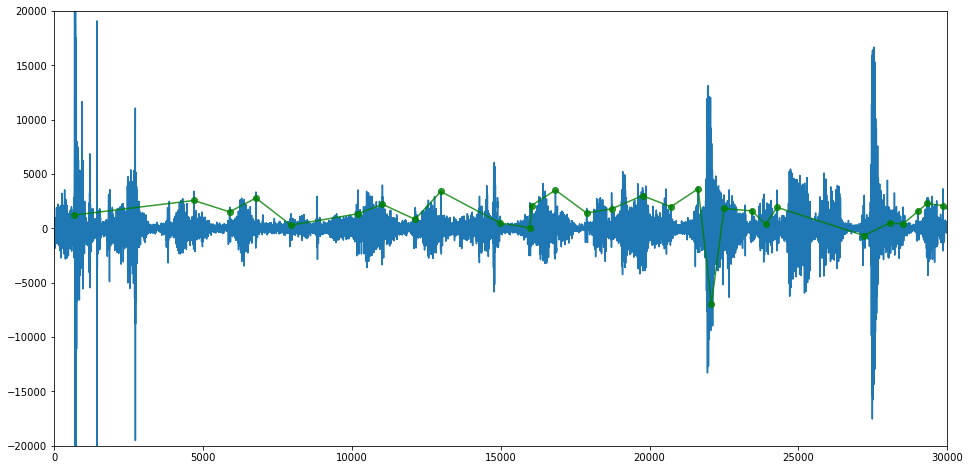

MV 49595_MV.wav
[   517   4024   4364   4788   5279   5931   6259   7220  11620  12119
  13032  14025  14994  15970  16934  17921  18816  19807  20740  21724
  22670  23645  24578  26489  27488  28415  29410  30313  32216  33190
  34351  35131  36082  37938  38935  39795  40277  40774  41211  41800
  42785  43758  44536  48564  49510  50519  51408  52433  53260  54269
  55169  56173  57290  59459  61447  62029  64560  65632  67665  68561
  69845  70858  71252  71903  72095  72902  73852  75836  76742  78001
  79042  80176  80665  81190  82184  83094  84137  86155  87165  90208
  92177  94192  95198  96181  98098  99122 100041 101039 101469 102067
 102974 107342 110234 110606 114600 115970 116037 117058 117585 117921
 120993 121924 123886]
[1915 4032 1817  655  949 1135 3707 2642 1007  607  517  725 1473 2031
 2298 1922 1076 1239  404  576 1095  449  535 1180 2184 1074 1281  880
 1079  588  461  475  344  423  492  332 1433 1245 2719  542  416  511
  635  997 1121 1075 1115 1062  984  9

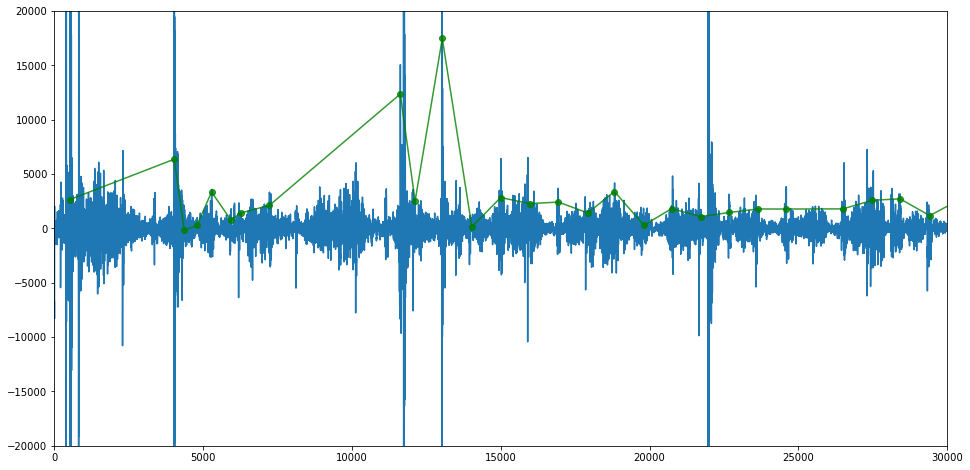

In [248]:
check_ith(36)

49598 2 4000
AV 49598_AV.hea 49598_AV.wav 49598_AV.tsv
MV 49598_MV.hea 49598_MV.wav 49598_MV.tsv
#Age: Child
#Sex: Male
#Height: 83.0
#Weight: 13.8
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2014
#Additional ID: nan

AV 49598_AV.wav
[   144    861   1881   2833   4261   5110   6573   7429   8765   9713
  10975  11925  12032  13216  14072  15282  16236  17442  18373  20435
  21581  22537  23179  23597  24428  25733  26547  27767  30728  31258
  32045  32856  34080  34909  36120  36950  38118  39035  40174  41098
  41608  42269  43114  44178  45099  46164  47098  48074  48995  50051
  50963  51981  52897  53841  54751  5

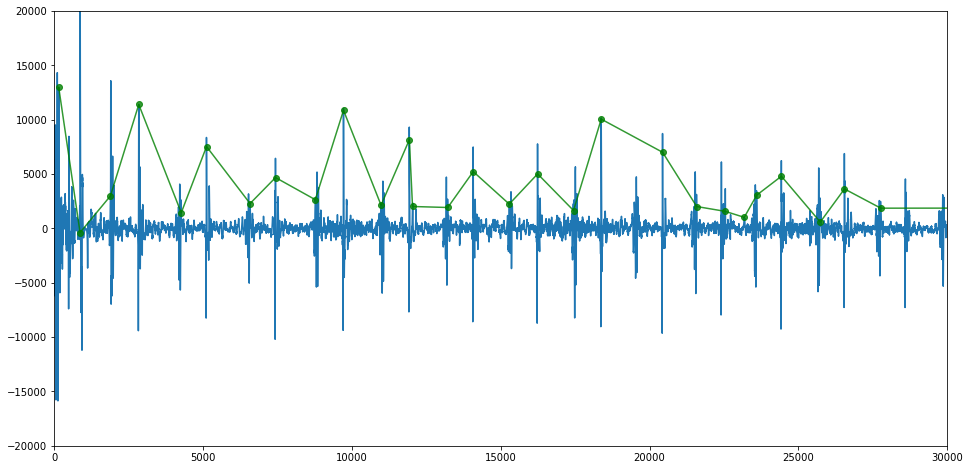

MV 49598_MV.wav
[   212    552   1367   1740   2701   3709   4053   5027   6336   7318
   8511   9471   9974  10645  11618  12679  13649  14489  14853  15717
  16218  16883  17748  18747  19700  20708  21654  22655  23590  24531
  25457  26419  27633  28353  29272  30217  31140  32037  32961  33921
  34850  35829  36742  37672  38580  39501  40405  41341  42240  43141
  44036  45006  45911  46406  46935  47835  48837  49755  50660  51567
  52511  53419  54353  55718  56137  57048  57918  58829  59720  60617
  61527  62432  63372  64298  65213  66126  66988  67880  68736  69624
  70496  71370  72283  73182  74115  75032  76901  77855  78767  79666
  80575  81557  82479  83491  84411  85406  86328  87273  88203  89235
  90181  90484  91321  92251  92757  93354  93889  94300  95352  96305
  97603  98556  99819 100054 100766 101877 102839 104051 105008 106218
 107162 108248 109203 110193 111204 112363 113078 114098 115019 115429
 116013 116947 117921 118859 119838 120760 121736 122665 1236

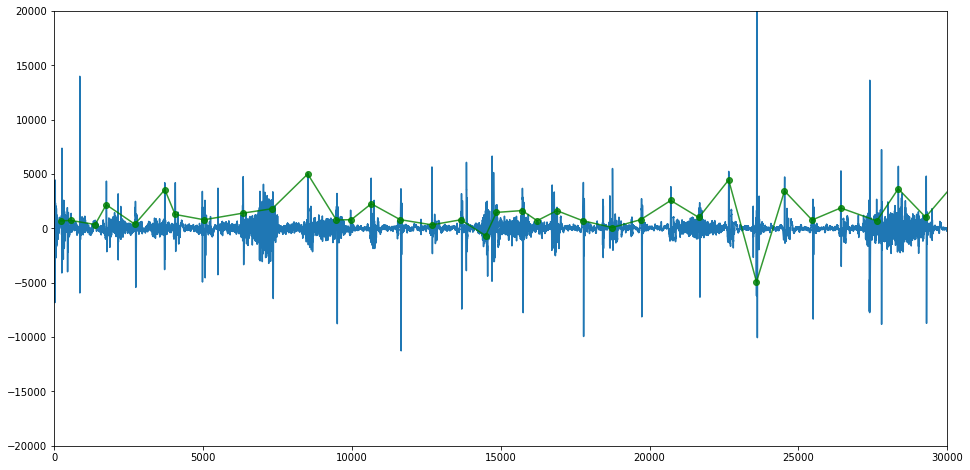

In [249]:
check_ith(37)